In [2]:
import numpy as np
%matplotlib inline

import importlib
import sys
import pickle
from RodeoMethods import *
importlib.reload(sys.modules['RodeoMethods'])
from OutdatedMethods import search_spectrum, process_data
from qiskit import IBMQ
from qiskit.circuit import QuantumCircuit
from qiskit.compiler import transpile

ibmqfactory.load_account:WARNING:2023-01-22 18:03:35,155: Credentials are already in use. The existing account in the session will be replaced.


General form of the 2-qubit Hamiltonian is
$$ H = xMod X_0 Z_1 + zMod Z_0 X_1 $$.

For testing, $xMod = 2.5$, $zMod = 1.5$ with $\lambda = -4, -1, 1, 4$. For actual runs, I use $xMod =
2.7395604855596334$ and $zMod = -0.6112156024794768$.

Qiskit initializes all qubits to 0 before the Hadamard gates. This has overlap with all eigenvalues.

I use $\sigma = 2, 7, 12$ for the first, second, and third pass respectively with three cycles of the rodeo algorithm per pass.

In [2]:
#eigenvalues of -3.350776088039110, -2.128344883080157, 2.128344883080156, 3.350776088039110]
mods = np.random.default_rng(42)

prodXMod = (mods.random() - 0.5) * 10
prodZMod = (mods.random() - 0.5) * 10
print(prodXMod)
print(prodZMod)

2.7395604855596334
-0.6112156024794768


In [3]:
print(provider.backends())

backendJakarta = provider.get_backend('ibmq_jakarta')
# backendCasablanca = provider.get_backend('ibmq_jakarta')
# casablanca was retired
backendQuito = provider.get_backend('ibmq_quito')
backendBelem = provider.get_backend('ibmq_belem')
backendPerth = provider.get_backend('ibm_perth')
backendQASM = provider.get_backend('ibmq_qasm_simulator')
# backendStatevector = provider.get_backend('simulator_statevector')
backendStatevector = Aer.get_backend('aer_simulator')
backend = backendPerth
print(backend)

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q-resea

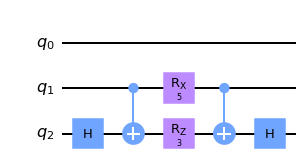

In [3]:
# make a test circuit and draw it
temp = QuantumCircuit(3)
temp.compose(make_cont_sys_circ(1, 2.5, 1.5), [0, 1, 2], inplace=True)
temp.draw('mpl')

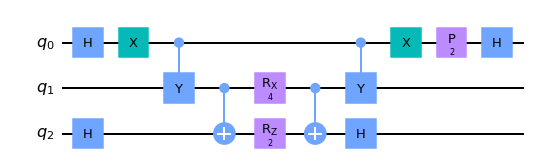

In [9]:
# make a circuit with 1 cycle of the rodeo algorithm
test = QuantumCircuit(3)
test.compose(make_cycle(1, 1, 2, 1), [0, 1, 2], inplace=True)
test.draw('mpl')

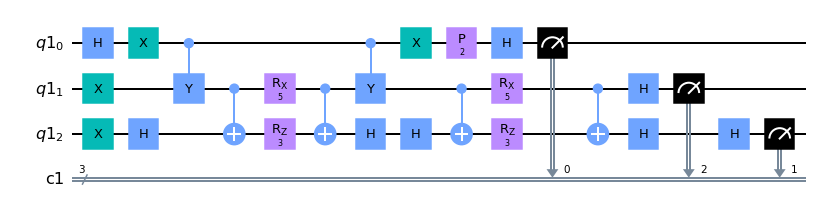

In [10]:
# make and draw a test circuit
cycleTest = run_rodeo([1], 1, 1, 2.5, 1.5, twoStateTime=1, measurements="xx")
cycleTest.draw('mpl')

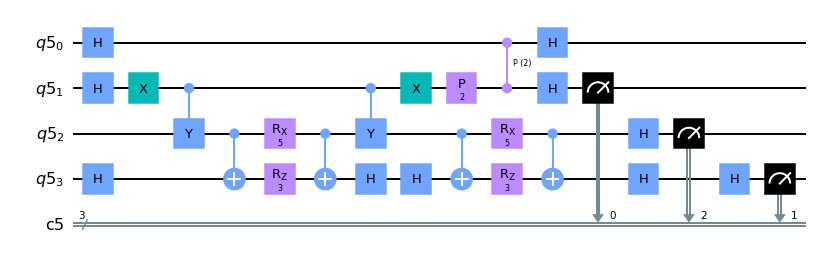

In [12]:
twoStateTest = run_two_state_rodeo([1], 1, 1, 2, 2.5, 1.5, 1, "xx")
twoStateTest.draw('mpl')

In [11]:
counts = [8, 4, 1, 1, 4, 7, 8, 7, 3, 2, 5, 9, 3, 1]
energies = [8, 4, 1, 1, 4, 7, 8, 7, 3, 2, 5, 9, 3, 1]
print(find_second_peaks(counts, energies, 3))

[8, 8, 9]


first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-4.0, -1.0, 2.0, 4.0, 5.0]
done w/ second pass
2
[[[-4.5, 88.44], [-4.45, 147.12], [-4.4, 117.24], [-4.35, 119.32], [-4.3, 143.84], [-4.25, 99.52], [-4.2, 114.64], [-4.15, 187.32], [-4.1, 82.8], [-4.05, 145.68], [-4.0, 168.24], [-3.95, 132.24], [-3.9, 169.0], [-3.85, 142.16], [-3.8, 79.76], [-3.75, 123.36], [-3.7, 120.84], [-3.65, 122.28], [-3.6, 145.12], [-3.55, 142.92], [-3.5, 88.2]], [[-1.5, 148.44], [-1.4500000000000002, 168.0], [-1.4, 160.12], [-1.35, 142.64], [-1.3, 119.52], [-1.25, 164.48], [-1.2000000000000002, 104.84], [-1.15, 160.64], [-1.1, 205.08], [-1.05, 457.28], [-1.0, 616.48], [-0.95, 415.48], [-0.9, 216.08], [-0.8500000000000001, 145.44], [-0.8, 127.8], [-0.75, 60.36], [-0.7, 129.16], [-0.65, 160.24], [-0.6, 92.6], [-0.55, 112.6], [-0.5, 144.76]], [[1.5, 147.04], [1.5499999999999998, 194.48], [1.6, 94.68], [1.65, 144.88], [1.7, 148.24], [1.75, 100.08], [1.7999999999999998, 172.2

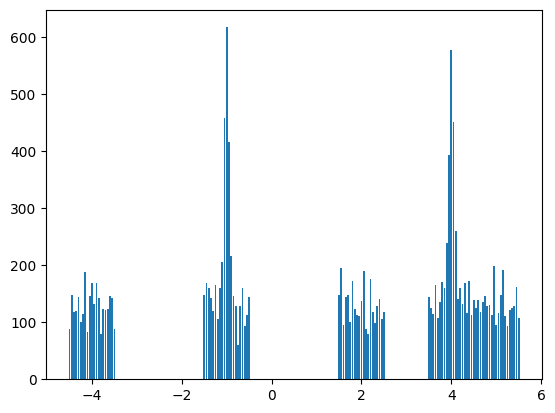

In [14]:
threeCycleOut = search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, 2.5, 1.5)
# print(threeCycleOut)
print(len(threeCycleOut[1][1]))
threeCycle2 = process_data(threeCycleOut, 1)
print(threeCycle2)

plot_scans(threeCycle2)

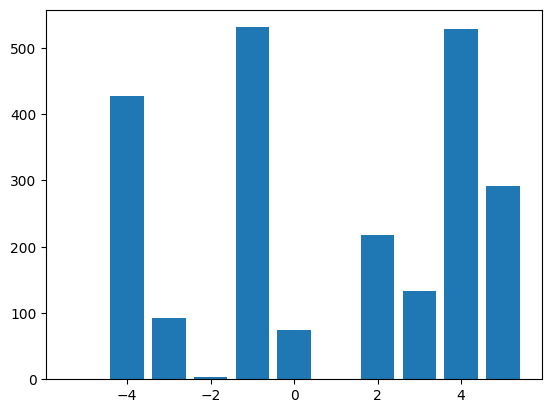

In [15]:
threeCycle1 = process_data(threeCycleOut, 0)
plot_scans(threeCycle1)

In [12]:
xmod1 = 1#.3359430644
zmod1 = 2.7803609513

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-2.0, 0.0, 2.0, 3.0, 4.0, 5.0]
done w/ second pass
[[[-2.5, 140.52], [-2.45, 151.12], [-2.4, 174.28], [-2.35, 101.96], [-2.3, 79.08], [-2.25, 131.04], [-2.2, 117.12], [-2.15, 127.08], [-2.1, 120.2], [-2.05, 114.64], [-2.0, 109.2], [-1.95, 113.96], [-1.9, 157.6], [-1.85, 154.84], [-1.8, 162.96], [-1.75, 205.48], [-1.7, 138.24], [-1.65, 119.72], [-1.6, 142.76], [-1.55, 175.4], [-1.5, 107.28]], [[-0.5, 79.0], [-0.45000000000000007, 71.92], [-0.4, 146.88], [-0.3500000000000001, 97.8], [-0.30000000000000004, 120.96], [-0.25, 127.6], [-0.20000000000000007, 100.96], [-0.15000000000000002, 112.64], [-0.10000000000000009, 119.56], [-0.050000000000000044, 118.64], [0.0, 126.76], [0.04999999999999999, 132.92], [0.09999999999999998, 104.52], [0.14999999999999997, 156.72], [0.19999999999999996, 111.4], [0.25, 66.16], [0.3, 110.8], [0.35, 149.96], [0.4, 114.0], [0.45, 112.44], [0.5, 124.92]], [[1.5, 120.52], 

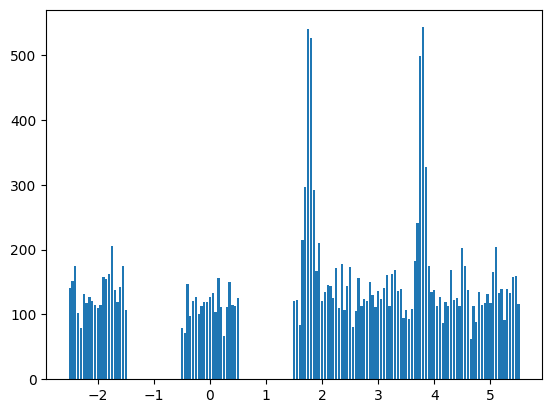

In [18]:
randomTest = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTest)
plot_scans(randomTest)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-5.0, -2.0, -1.0, 2.0, 3.0, 4.0, 5.0]


managedjob._async_submit:WARNING:2021-10-22 15:10:56,110: Job limit reached, waiting for job 61730cb5731fe680eebce245 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:13:57,821: Job limit reached, waiting for job 61730cb8976ff9693281c634 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:14:28,294: Job limit reached, waiting for job 61730cba976ff983b481c635 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:14:56,945: Job limit reached, waiting for job 61730cbc976ff9bfea81c636 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:15:29,063: Job limit reached, waiting for job 61730cbe706f42c99d432c01 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:15:59,461: Job limit reached, waiting for job 61730d73731fe6551cbce24a to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10

done w/ second pass
[[[-5.5, 129.12], [-5.45, 165.8], [-5.4, 127.2], [-5.35, 111.0], [-5.3, 124.8], [-5.25, 130.16], [-5.2, 144.2], [-5.15, 144.24], [-5.1, 171.32], [-5.05, 141.12], [-5.0, 156.4], [-4.95, 146.72], [-4.9, 127.2], [-4.85, 131.16], [-4.8, 120.8], [-4.75, 127.8], [-4.7, 153.56], [-4.65, 135.88], [-4.6, 134.36], [-4.55, 123.16], [-4.5, 144.32]], [[-2.5, 149.16], [-2.45, 147.88], [-2.4, 108.6], [-2.35, 149.48], [-2.3, 155.72], [-2.25, 114.36], [-2.2, 148.56], [-2.15, 147.96], [-2.1, 133.28], [-2.05, 172.88], [-2.0, 112.44], [-1.95, 113.52], [-1.9, 124.64], [-1.85, 134.32], [-1.8, 166.96], [-1.75, 185.36], [-1.7, 168.2], [-1.65, 139.52], [-1.6, 169.16], [-1.55, 105.76], [-1.5, 129.2]], [[-1.5, 138.36], [-1.4500000000000002, 135.2], [-1.4, 142.44], [-1.35, 132.88], [-1.3, 120.6], [-1.25, 151.44], [-1.2000000000000002, 165.28], [-1.15, 119.56], [-1.1, 154.08], [-1.05, 113.72], [-1.0, 153.44], [-0.95, 148.28], [-0.9, 130.16], [-0.8500000000000001, 160.4], [-0.8, 165.08], [-0.75,

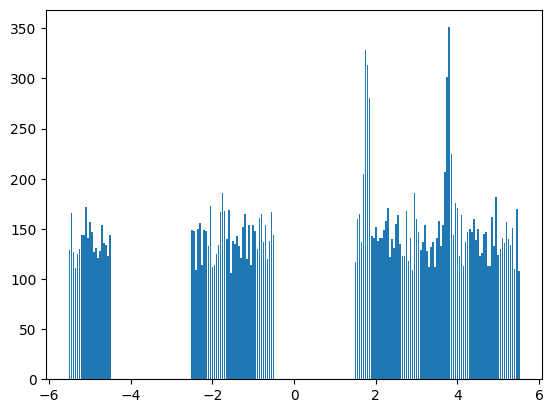

In [20]:
randomTestQ = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTestQ)
plot_scans(randomTestQ)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-4.0, -2.0, -1.0, 1.0, 2.0, 3.0, 4.0, 5.0]


managedjob._async_submit:WARNING:2021-10-24 00:52:39,735: Job limit reached, waiting for job 6174e68d731fe62419bcf1b5 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:53:14,194: Job limit reached, waiting for job 6174e68f706f426d59433b60 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:53:43,384: Job limit reached, waiting for job 6174e6909e07dd733b57995b to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:54:11,400: Job limit reached, waiting for job 6174e6924829a00a7616262b to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:54:39,980: Job limit reached, waiting for job 6174e6946ab940b0d710ed9d to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:55:08,083: Job limit reached, waiting for job 6174e6b69e07ddb09257995d to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10

done w/ second pass
[[[-4.5, 250.92], [-4.45, 243.44], [-4.4, 314.52], [-4.35, 259.6], [-4.3, 207.16], [-4.25, 302.76], [-4.2, 245.92], [-4.15, 274.44], [-4.1, 253.52], [-4.05, 262.0], [-4.0, 271.2], [-3.95, 251.2], [-3.9, 230.48], [-3.85, 270.8], [-3.8, 267.64], [-3.75, 298.68], [-3.7, 298.36], [-3.65, 244.88], [-3.6, 209.24], [-3.55, 329.04], [-3.5, 336.72]], [[-2.5, 273.36], [-2.45, 258.12], [-2.4, 312.72], [-2.35, 316.96], [-2.3, 323.68], [-2.25, 266.4], [-2.2, 261.72], [-2.15, 283.08], [-2.1, 297.24], [-2.05, 280.36], [-2.0, 241.08], [-1.95, 275.68], [-1.9, 243.16], [-1.85, 281.92], [-1.8, 287.96], [-1.75, 253.88], [-1.7, 226.16], [-1.65, 278.4], [-1.6, 282.16], [-1.55, 314.64], [-1.5, 262.12]], [[-1.5, 243.6], [-1.4500000000000002, 256.92], [-1.4, 333.04], [-1.35, 290.84], [-1.3, 301.04], [-1.25, 270.52], [-1.2000000000000002, 282.64], [-1.15, 264.28], [-1.1, 310.84], [-1.05, 277.12], [-1.0, 328.56], [-0.95, 308.56], [-0.9, 262.68], [-0.8500000000000001, 316.16], [-0.8, 243.32], 

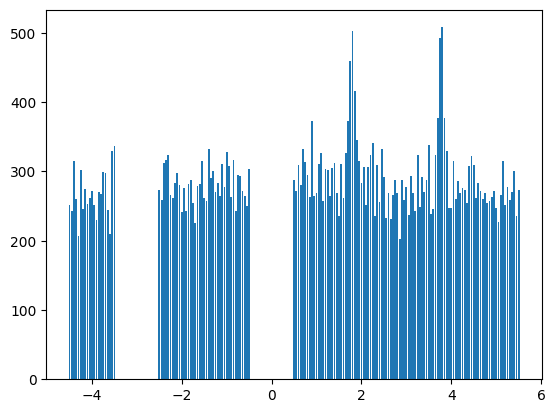

In [12]:
randomTestQ2 = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 2, 21, 25, xmod1, zmod1), 1)
print(randomTestQ2)
plot_scans(randomTestQ2)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-5.0, -2.0, 0.0, 1.0, 2.0, 4.0]
done w/ second pass
[[[-5.5, 122.76], [-5.45, 143.56], [-5.4, 101.76], [-5.35, 159.52], [-5.3, 137.76], [-5.25, 123.12], [-5.2, 136.6], [-5.15, 147.0], [-5.1, 116.64], [-5.05, 156.88], [-5.0, 127.36], [-4.95, 125.4], [-4.9, 183.44], [-4.85, 139.28], [-4.8, 120.8], [-4.75, 123.8], [-4.7, 145.48], [-4.65, 96.32], [-4.6, 136.36], [-4.55, 108.64], [-4.5, 111.08]], [[-2.5, 112.84], [-2.45, 161.72], [-2.4, 121.68], [-2.35, 142.88], [-2.3, 106.36], [-2.25, 107.32], [-2.2, 135.8], [-2.15, 106.4], [-2.1, 172.64], [-2.05, 99.44], [-2.0, 143.36], [-1.95, 123.12], [-1.9, 147.0], [-1.85, 100.64], [-1.8, 164.6], [-1.75, 174.52], [-1.7, 159.52], [-1.65, 137.04], [-1.6, 134.88], [-1.55, 139.6], [-1.5, 143.48]], [[-0.5, 108.84], [-0.45000000000000007, 147.24], [-0.4, 120.4], [-0.3500000000000001, 149.56], [-0.30000000000000004, 110.28], [-0.25, 116.52], [-0.20000000000000007, 152.

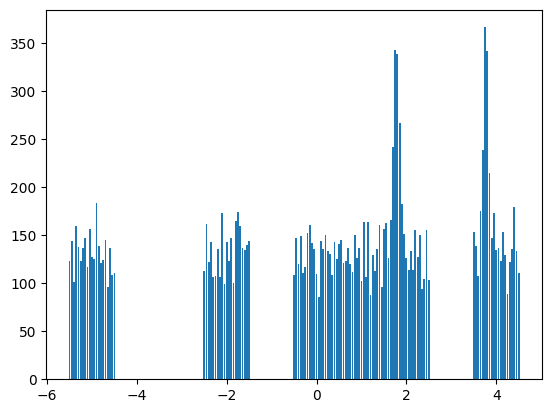

In [19]:
randomTestCasablanca = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTestCasablanca)
plot_scans(randomTestCasablanca)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-3.0, 1.0, 2.0, 3.0, 4.0, 5.0]
done w/ second pass
[[[-3.5, 166.32], [-3.45, 106.68], [-3.4, 131.28], [-3.35, 173.36], [-3.3, 144.44], [-3.25, 114.56], [-3.2, 136.72], [-3.15, 149.04], [-3.1, 111.2], [-3.05, 121.4], [-3.0, 104.16], [-2.95, 127.12], [-2.9, 136.4], [-2.85, 131.96], [-2.8, 113.72], [-2.75, 99.44], [-2.7, 132.6], [-2.65, 99.88], [-2.6, 126.16], [-2.55, 118.24], [-2.5, 128.72]], [[0.5, 141.76], [0.5499999999999999, 141.52], [0.6, 151.96], [0.6499999999999999, 122.8], [0.7, 163.12], [0.75, 110.72], [0.7999999999999999, 127.44], [0.85, 178.0], [0.8999999999999999, 117.36], [0.95, 150.72], [1.0, 104.96], [1.05, 129.52], [1.1, 137.04], [1.15, 153.0], [1.2, 166.84], [1.25, 134.92], [1.3, 177.8], [1.35, 118.92], [1.4, 121.4], [1.45, 133.76], [1.5, 140.04]], [[1.5, 124.32], [1.5499999999999998, 140.92], [1.6, 157.4], [1.65, 210.48], [1.7, 220.44], [1.75, 320.16], [1.7999999999999998, 347.8]

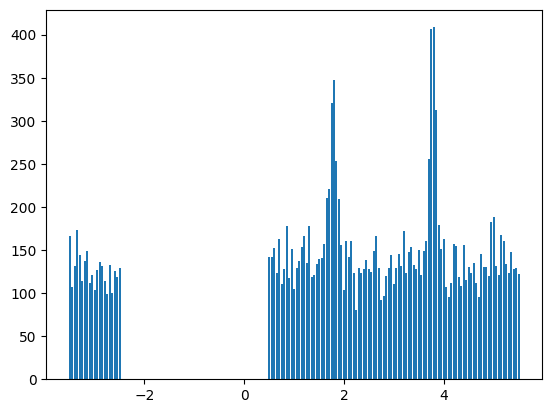

In [21]:
randomTestJakarta = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTestJakarta)
plot_scans(randomTestJakarta)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[2.0, 4.0]
done w/ second pass
[[<qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002677D7C5340>, <qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002677E781880>], [array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]), [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 

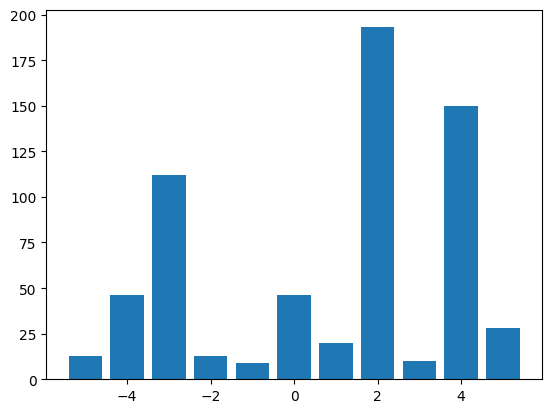

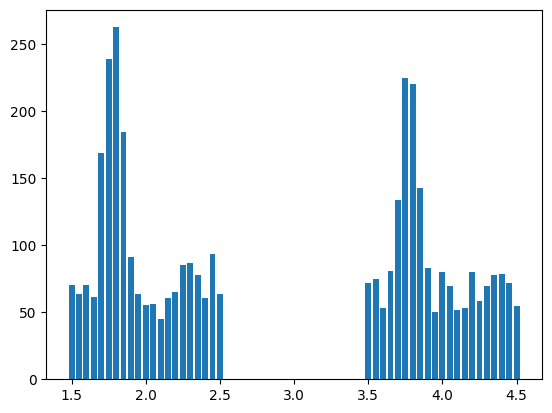

In [14]:
randomTestJakarta4Cycle = search_spectrum(np.linspace(-5, 5, 11), 150, 4, 21, 25, xmod1, zmod1)
randomTestJakarta4CycleInitial = process_data(randomTestJakarta4Cycle, 0)
randomTestJakarta4CycleFinal = process_data(randomTestJakarta4Cycle, 1)
print(randomTestJakarta4Cycle)
plot_scans(randomTestJakarta4CycleInitial)
plot_scans(randomTestJakarta4CycleFinal)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-2.0, -1.0, 2.0, 4.0]
done w/ second pass
[[<qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002677EA93AC0>, <qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002671AF84D60>], [array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]), [-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65

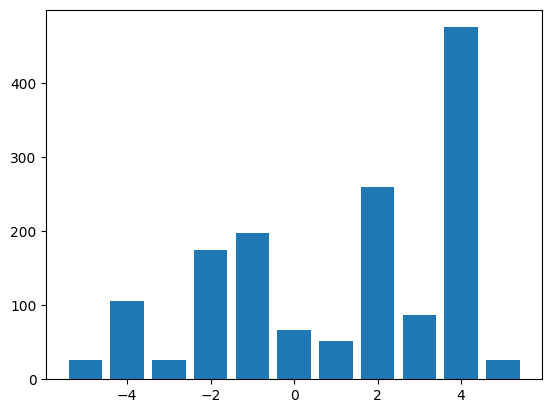

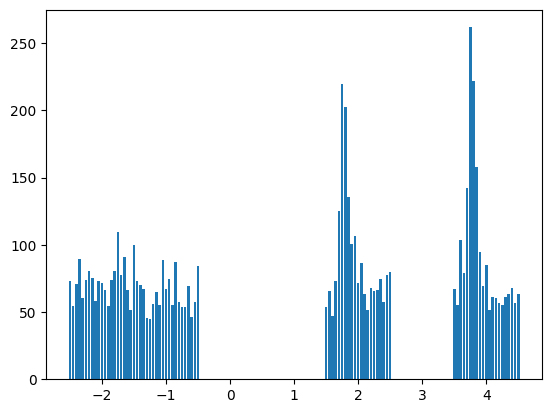

In [15]:
randomTestJakarta4Cycle2 = search_spectrum(np.linspace(-5, 5, 11), 150, 4, 21, 25, xmod1, zmod1)
randomTestJakarta4CycleInitial2 = process_data(randomTestJakarta4Cycle2, 0)
randomTestJakarta4CycleFinal2 = process_data(randomTestJakarta4Cycle2, 1)
print(randomTestJakarta4Cycle2)
plot_scans(randomTestJakarta4CycleInitial2)
plot_scans(randomTestJakarta4CycleFinal2)



In [24]:
fourRange = list(range(100))
fourRange[:] = [x / 25 for x in fourRange]

# fourJob = run_two_state(3, fourRange, 2.5, 1.5, -1, 4)
fourJob = jobManager.retrieve_job_set('eb379bacddad4a89a4efef94e987f0bd-1636140982352417', provider)
print(fourJob.job_set_id())
fourResults = fourJob.results()

C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjobset.py:195: DeprecationWarning: The ``IBMQJob.qobj()`` method is deprecated and will be removed in a future release. You can now pass circuits to ``IBMQBackend.run()`` and use ``IBMQJob.circuits()``, ``IBMQJob.backend_options()``, and ``IBMQJob.header()`` to retrieve circuits, run configuration, and Qobj header, respectively.
  experiments_count=len(job.qobj().experiments),


eb379bacddad4a89a4efef94e987f0bd-1636140982352417


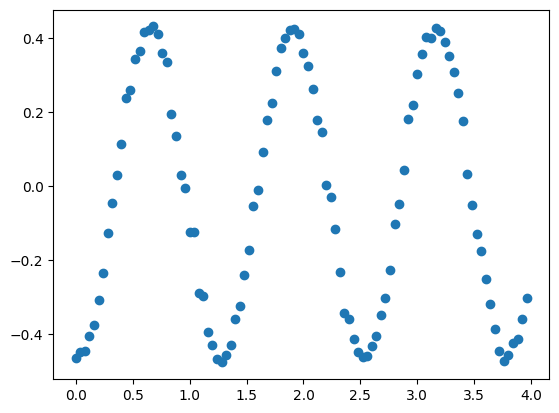

In [15]:
plt.scatter(fourRange, process_two_state(fourResults, "0000"))
plt.show()

In [28]:
fourJob2 = run_two_state(3, fourRange, 2.5, 1.5, -1, 4)
print(fourJob2.job_set_id())
fourResults2 = fourJob2.results()

14fc1ae7d2494aa3850c76af70c4d411-16376708627117543


[435, 412, 453, 409, 422, 443, 400, 407, 400, 430, 415, 405, 439, 410, 422, 425, 386, 419, 407, 392, 422, 452, 420, 420, 456, 432, 387, 430, 443, 415, 435, 403, 428, 417, 415, 439, 418, 424, 443, 407, 418, 426, 401, 419, 437, 421, 415, 409, 389, 414, 422, 412, 395, 431, 426, 417, 414, 455, 404, 413, 402, 405, 410, 439, 441, 395, 416, 429, 401, 410, 398, 400, 438, 407, 421, 427, 445, 428, 407, 425, 410, 404, 406, 414, 416, 409, 426, 399, 434, 418, 429, 414, 406, 412, 407, 441, 417, 429, 427, 418]


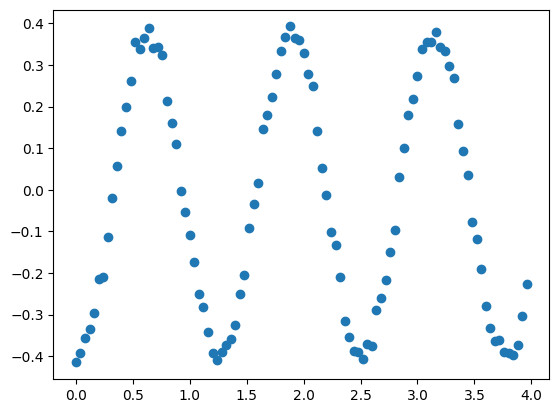

In [30]:
plt.scatter(fourRange, process_two_state(fourResults2, "0000"))
plt.show()

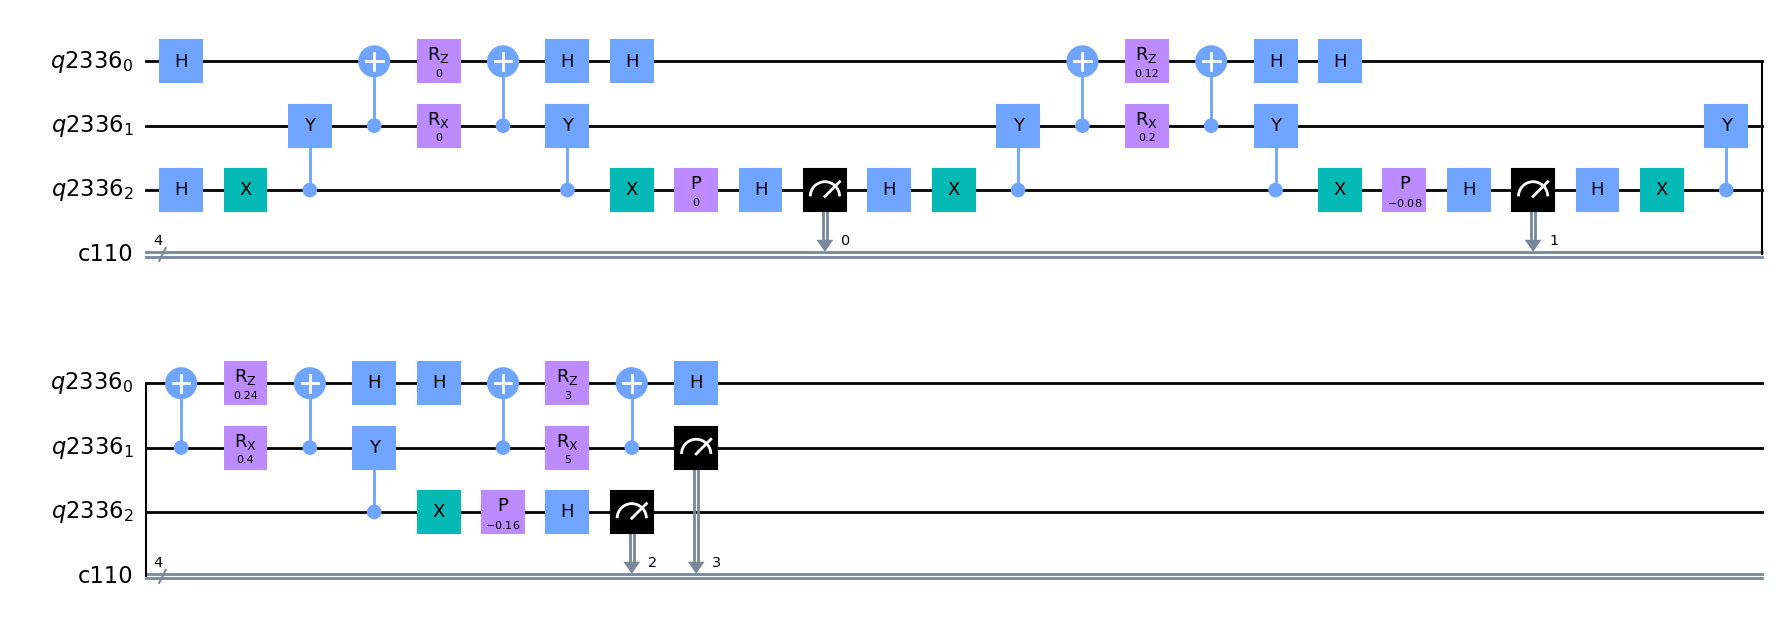

In [29]:
circ = run_rodeo(fourRange, 3, -1, 2.5, 1.5, 1)
circ.draw('mpl')

In [31]:
run1Range = list(range(100))
run1Range[:] = [x / 10 for x in run1Range]

# run1Job = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
run1Job = jobManager.retrieve_job_set('0113f01d576942539ef3e6db95e581ca-1636258522398855', provider)
print(run1Job.job_set_id())
run1Results = run1Job.results()

C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjobset.py:195: DeprecationWarning: The ``IBMQJob.qobj()`` method is deprecated and will be removed in a future release. You can now pass circuits to ``IBMQBackend.run()`` and use ``IBMQJob.circuits()``, ``IBMQJob.backend_options()``, and ``IBMQJob.header()`` to retrieve circuits, run configuration, and Qobj header, respectively.
  experiments_count=len(job.qobj().experiments),


0113f01d576942539ef3e6db95e581ca-1636258522398855


[-0.4662921348314607, -0.42911392405063287, -0.27142857142857146, -0.04225352112676062, 0.2071428571428571, 0.3619854721549637, 0.44063926940639275, 0.4282296650717703, 0.2780487804878049, 0.10563380281690146, -0.08392434988179664, -0.33114035087719296, -0.45707070707070707, -0.4634703196347032, -0.3443396226415094, -0.1772616136919315, 0.04952830188679247, 0.24634146341463414, 0.3886138613861386, 0.4250585480093677, 0.3906605922551253, 0.19194312796208532, -0.001187648456057011, -0.19844789356984482, -0.38809523809523805, -0.4578454332552693, -0.42396313364055305, -0.31861575178997614, -0.06896551724137934, 0.1244343891402715, 0.33521444695259595, 0.42700729927007297, 0.42592592592592593, 0.3089887640449438, 0.14186046511627912, -0.07894736842105265, -0.3009367681498829, -0.42874109263657956, -0.458128078817734, -0.3789346246973365, -0.19047619047619047, 0.04629629629629628, 0.2396061269146608, 0.3883720930232558, 0.44736842105263164, 0.41034482758620694, 0.22817955112219448, 0.004587

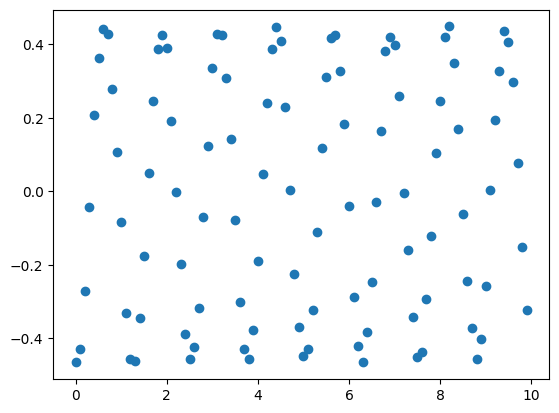

In [20]:
print(process_two_state(run1Results, "0000"))
plt.scatter(run1Range, process_two_state(run1Results, "0000"))
plt.show()

In [24]:
#run with hadamard on 1st qubit for time evolution; bad data
run2Range = list(range(100))
run2Range[:] = [x / 10 for x in run2Range]

run2Job = run_two_state(3, run2Range, 2.5, 1.5, 1, 4, backendJakarta)
print(run2Job.job_set_id())
run2Results = run2Job.results()

d453bb67ce3f45aa8ada23f0ddac1426-16362952522716198


[-0.46445497630331756, -0.4451371571072319, -0.3811369509043928, -0.2766990291262136, -0.19417475728155342, -0.06521739130434778, 0.057213930348258724, 0.18226600985221675, 0.3045977011494253, 0.408641975308642, 0.41183879093198994, 0.42091836734693877, 0.3987341772151899, 0.3163265306122449, 0.2153846153846154, 0.09114583333333329, -0.08968058968058967, -0.15159574468085102, -0.2931034482758621, -0.38916256157635465, -0.43041237113402064, -0.4362244897959183, -0.4363867684478372, -0.38601036269430056, -0.3075, -0.1633663366336634, -0.04707379134860046, 0.10447761194029856, 0.2021276595744681, 0.29104477611940305, 0.37760416666666663, 0.39973614775725597, 0.4285714285714286, 0.3850855745721271, 0.2777777777777778, 0.17766497461928932, 0.06973995271867614, -0.08695652173913049, -0.15263157894736845, -0.30052493438320205, -0.35121951219512193, -0.4251870324189526, -0.45663265306122447, -0.4151670951156813, -0.3307692307692308, -0.3112244897959183, -0.2132530120481928, -0.0808823529411765

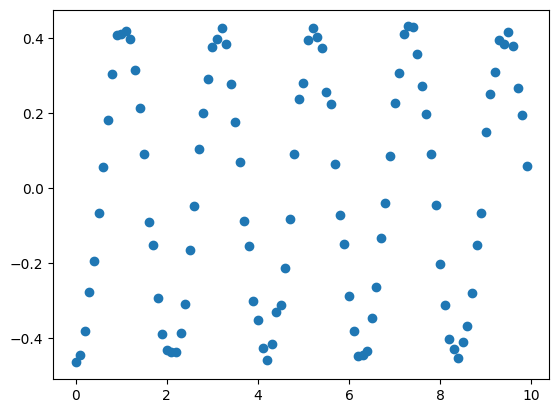

In [25]:
#run with hadamard on 1st qubit for time evolution; bad data
print(process_two_state(run2Results, "0000"))
plt.scatter(run2Range, process_two_state(run2Results, "0000"))
plt.show()

In [27]:
run3Range = list(range(100))
run3Range[:] = [x / 10 for x in run3Range]

# run3Job = run_two_state(3, run3Range, 2.5, 1.5, 1, 4, backendCasablanca)
run3Job = jobManager.retrieve_job_set('e68c0f9ee75a4bc688bd5773baa84cb5-1636295587006089', provider)
print(run3Job.job_set_id())
run3Results = run3Job.results()

e68c0f9ee75a4bc688bd5773baa84cb5-1636295587006089


[0.09999999999999998, -0.025925925925925908, -0.026717557251908386, -0.017985611510791366, -0.020270270270270285, -0.03076923076923077, 0.0, -0.05737704918032782, 0.04263565891472873, -0.011450381679389277, -0.06944444444444442, -0.02941176470588236, -0.0798319327731093, 0.02941176470588236, -0.05639097744360899, 0.017730496453900707, -0.07046979865771807, -0.0037037037037036535, -0.023809523809523836, -0.020325203252032575, -0.011811023622047223, -0.07241379310344831, -0.03125, -0.021739130434782594, -0.08461538461538465, -0.0703125, -0.05147058823529416, 0.02517985611510795, -0.020000000000000018, 0.0, 0.04014598540145986, 0.018796992481203034, 0.024590163934426257, -0.02941176470588236, -0.04014598540145986, -0.04744525547445255, -0.10483870967741937, -0.06060606060606055, 0.038461538461538436, 0.044378698224852076, 0.14347826086956525, -0.04471544715447151, 0.057046979865771785, -0.026717557251908386, 0.02892561983471076, -0.0234375, -0.011811023622047223, -0.0855855855855856, -0.0

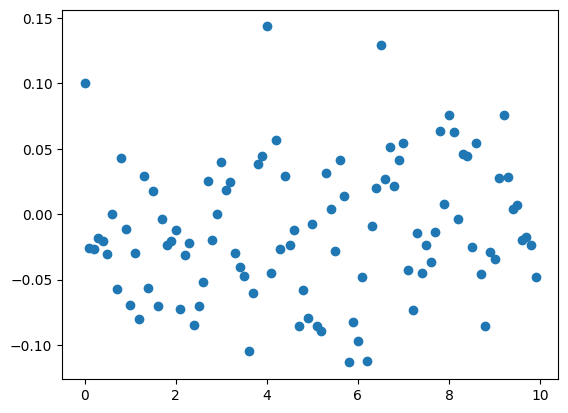

In [28]:
print(process_two_state(run3Results, "0000"))
plt.scatter(run3Range, process_two_state(run3Results, "0000"))
plt.show()

In [35]:
run4Job1Cycle = run_two_state(1, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
print(run4Job1Cycle.job_set_id())
run41CycleResults = run4Job1Cycle.results()

run4Job2Cycle = run_two_state(2, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
print(run4Job2Cycle.job_set_id())
run42CycleResults = run4Job2Cycle.results()

run4Job3Cycle = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
print(run4Job3Cycle.job_set_id())
run43CycleResults = run4Job3Cycle.results()

run4Job4Cycle = run_two_state(4, run1Range, 2.5, 1.5, -1, 4, backendJakarta)
print(run4Job4Cycle.job_set_id())
run44CycleResults = run4Job4Cycle.results()

10faa0f1091d47449b460a910ca6f038-1636297440729653
8c64b883b944451599ff6287a1215316-1636297529660125
3eadafa198e248de891631d862105eb4-16362975861800056
175939a699f14141b8956b96c21e6ab5-16362976478864727


[-0.48080614203454897, -0.40751445086705207, -0.25183823529411764, -0.012670565302144277, 0.2288461538461539, 0.36837294332723947, 0.4343629343629344, 0.40858208955223885, 0.23567467652495377, 0.024436090225563922, -0.19739478957915835, -0.376425855513308, -0.46953405017921146, -0.44609665427509293, -0.31056466302367947, -0.12407407407407411, 0.11481481481481481, 0.30996309963099633, 0.428698752228164, 0.42871287128712876, 0.3349514563106796, 0.14165103189493433, -0.08674463937621835, -0.25806451612903225, -0.43398058252427185, -0.48378378378378384, -0.3809946714031972, -0.25529865125240847, -0.051656920077972734, 0.17041198501872665, 0.3798449612403101, 0.4444444444444444, 0.41204588910133844, 0.26717557251908397, 0.05555555555555558, -0.16666666666666663, -0.35144927536231885, -0.4595375722543352, -0.4467680608365019, -0.3176691729323309, -0.17463235294117652, 0.07090909090909092, 0.2657142857142857, 0.412621359223301, 0.43482309124767227, 0.34980237154150196, 0.13068181818181815, -0

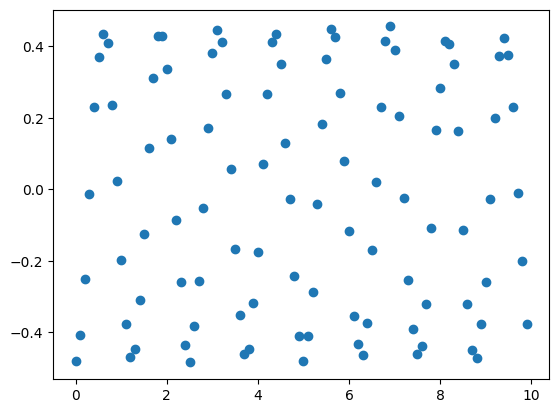

In [41]:
print(process_two_state(run41CycleResults, "00"))
plt.scatter(run3Range, process_two_state(run41CycleResults, "00"))
plt.show()

[-0.47836166924265844, -0.4296407185628742, -0.323170731707317, -0.09829059829059827, 0.12462006079027355, 0.2840579710144928, 0.4532428355957767, 0.4329268292682926, 0.34259259259259256, 0.09907120743034056, -0.09398496240601506, -0.31008902077151335, -0.4370314842578711, -0.4687034277198212, -0.3802395209580839, -0.2305389221556886, 0.008371385083713906, 0.2360482654600302, 0.3734567901234568, 0.44298921417565484, 0.3830409356725146, 0.23806078147612156, 0.038226299694189586, -0.17391304347826086, -0.3748137108792846, -0.46711509715994026, -0.4499241274658573, -0.31818181818181823, -0.11180124223602483, 0.09848484848484851, 0.31060606060606055, 0.420704845814978, 0.4323899371069182, 0.35053929121725735, 0.13931888544891644, -0.09661495063469672, -0.3130699088145896, -0.41594202898550725, -0.4709480122324159, -0.3923766816143498, -0.25113808801213966, -0.03055141579731746, 0.20044052863436124, 0.3533333333333333, 0.4420970266040689, 0.3973607038123167, 0.2436281859070465, 0.0598290598

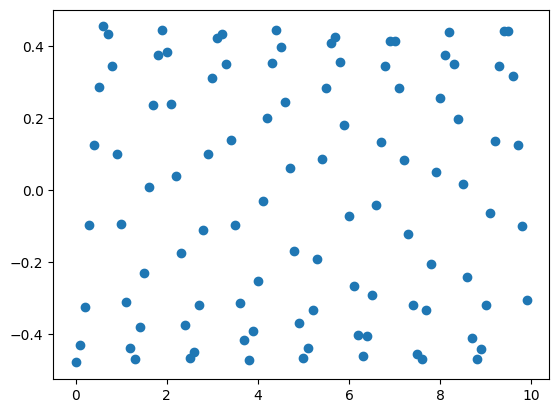

In [42]:
print(process_two_state(run42CycleResults, "000"))
plt.scatter(run3Range, process_two_state(run42CycleResults, "000"))
plt.show()

[553, 545, 541, 508, 508, 550, 521, 541, 550, 526, 553, 526, 526, 535, 554, 525, 508, 549, 521, 535, 537, 517, 571, 533, 537, 534, 555, 536, 564, 539, 546, 550, 558, 535, 527, 510, 535, 510, 506, 528, 560, 502, 527, 535, 532, 544, 548, 560, 529, 546, 542, 555, 520, 557, 549, 533, 543, 507, 535, 530, 546, 536, 560, 516, 510, 538, 551, 541, 525, 526, 564, 550, 557, 538, 522, 535, 554, 535, 547, 522, 541, 568, 516, 561, 542, 538, 550, 557, 568, 531, 515, 530, 538, 525, 539, 537, 545, 519, 535, 525]
[-0.4529837251356239, -0.41559633027522935, -0.27264325323475047, -0.017716535433070835, 0.17716535433070868, 0.3218181818181818, 0.41938579654510555, 0.422365988909427, 0.26727272727272733, 0.09695817490494296, -0.14918625678119346, -0.31558935361216733, -0.4505703422053232, -0.4495327102803738, -0.3592057761732852, -0.17047619047619045, 0.025590551181102345, 0.25045537340619306, 0.3963531669865643, 0.4214953271028037, 0.36592178770949724, 0.19632495164410058, 0.004378283712784592, -0.25046904

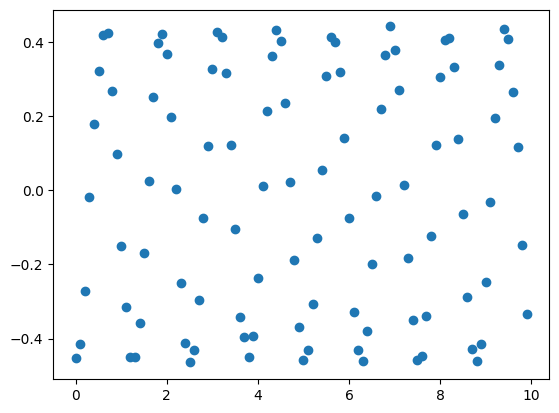

In [66]:
print(process_two_state(run43CycleResults, "0000"))
plt.scatter(run3Range, process_two_state(run43CycleResults, "0000"))
plt.show()

[410, 415, 404, 398, 394, 394, 416, 404, 387, 374, 389, 386, 414, 401, 387, 388, 408, 401, 402, 404, 388, 405, 360, 412, 377, 434, 394, 379, 348, 385, 367, 393, 410, 393, 346, 398, 399, 379, 389, 357, 391, 349, 399, 409, 378, 360, 370, 393, 389, 374, 398, 392, 382, 396, 394, 408, 371, 387, 417, 402, 384, 390, 420, 384, 406, 396, 404, 394, 415, 395, 426, 390, 415, 409, 355, 417, 397, 407, 389, 418, 389, 388, 409, 398, 388, 404, 399, 388, 426, 400, 387, 391, 425, 426, 407, 387, 376, 380, 403, 375]
[-0.4463414634146341, -0.4036144578313253, -0.2698019801980198, -0.042713567839196, 0.14467005076142134, 0.35279187817258884, 0.4326923076923077, 0.4331683168316831, 0.28552971576227393, 0.12834224598930485, -0.12724935732647813, -0.3341968911917098, -0.4371980676328503, -0.4625935162094763, -0.3630490956072352, -0.20876288659793818, -0.004901960784313708, 0.24812967581047382, 0.37810945273631846, 0.43811881188118806, 0.3608247422680413, 0.1987654320987654, 0.04722222222222225, -0.2233009708737

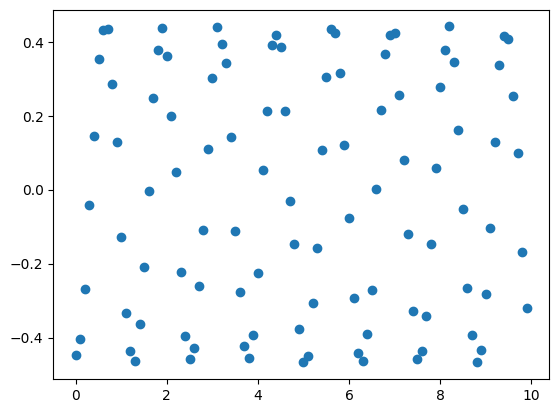

In [65]:
print(process_two_state(run44CycleResults, "00000"))
plt.scatter(run3Range, process_two_state(run44CycleResults, "00000"))
plt.show()

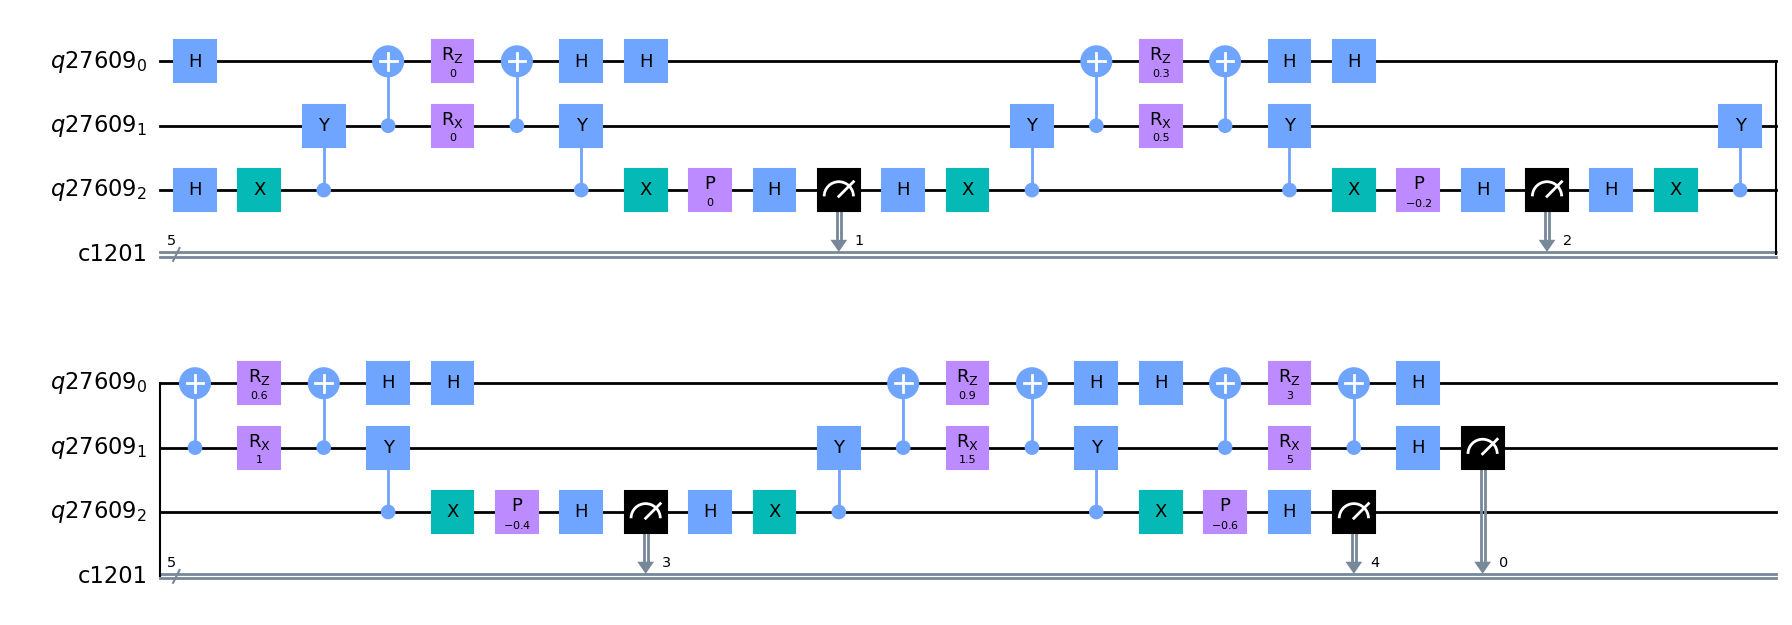

In [47]:
circ = run_rodeo(run1Range, 4, -1, 2.5, 1.5, 1, True)
circ.draw('mpl')

In [50]:
run5Job1Cycle = run_two_state(1, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run5Job1Cycle.job_set_id())
run51CycleResults = run5Job1Cycle.results()

run5Job2Cycle = run_two_state(2, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run5Job2Cycle.job_set_id())
run52CycleResults = run5Job2Cycle.results()

run5Job3Cycle = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run5Job3Cycle.job_set_id())
run53CycleResults = run5Job3Cycle.results()

run5Job4Cycle = run_two_state(4, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run5Job4Cycle.job_set_id())
run54CycleResults = run5Job4Cycle.results()

6eebabcf8686434984bec5f4fdefaefb-16362992230827897
065efc482ce64d96b6cdddb1ee1bf01b-16362992711233456
f9631d5b3172421e951eded7f1badca1-16362993287257757
649fdb61b0994502870d872a6ce321ec-16362993882994504


[0.005119453924914669, 0.03251318101933218, -0.03608247422680411, -0.01488616462346759, -0.017123287671232834, -0.002546689303904892, 0.002617801047120394, 0.0017605633802817156, -0.03344768439108059, -0.04878048780487809, -0.03658536585365857, -0.026936026936026924, -0.03637901861252113, -0.02447552447552448, -0.01832460732984298, 0.009031198686371117, 0.0, -0.028911564625850317, -0.027545909849749584, -0.028239202657807327, 0.014529914529914506, 0.03088480801335558, 0.01960784313725486, 0.06122448979591841, 0.038732394366197215, 0.04166666666666671, -0.03678929765886285, -0.037288135593220306, -0.010526315789473717, -0.00545454545454549, -0.03542009884678743, -0.027491408934707917, -0.04483925549915402, -0.058260869565217366, -0.042314335060449015, -0.0383275261324042, -0.011627906976744207, -0.004273504273504258, -0.04895104895104896, -0.012520868113522488, -0.006734006734006703, 0.032094594594594544, -0.02533783783783783, -0.0050167224080267525, -0.005785123966942196, -0.0017857142

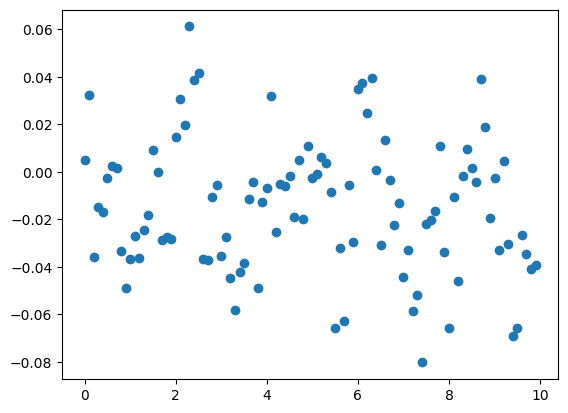

In [51]:
print(process_two_state(run51CycleResults, "00"))
plt.scatter(run3Range, process_two_state(run51CycleResults, "00"))
plt.show()

[0.05353535353535355, 0.007968127490039834, -0.014970059880239472, -0.030487804878048808, -0.022821576763485507, -0.038461538461538436, -0.06262833675564683, -0.12815126050420167, -0.10358565737051795, -0.1015625, -0.04697286012526092, -0.047945205479452024, -0.01807228915662651, -0.012096774193548376, 0.027542372881355942, -0.01650485436893201, 0.03526970954356845, 0.030571992110453666, 0.03725490196078429, 0.04811715481171544, 0.020467836257309968, 0.06972111553784857, 0.015686274509803894, 0.038775510204081653, -0.036821705426356544, -0.007128309572301372, -0.048387096774193505, -0.07113821138211385, -0.09748427672955973, -0.07287449392712553, -0.10912698412698407, -0.0805084745762712, -0.05214723926380371, -0.10236220472440949, -0.030271398747390377, -0.004166666666666652, 0.05397148676171082, 0.05060728744939269, 0.009960159362549792, 0.0353319057815846, 0.030655391120507414, 0.0426829268292683, 0.044910179640718556, 0.01491053677932408, 0.0019379844961240345, -0.05093555093555091

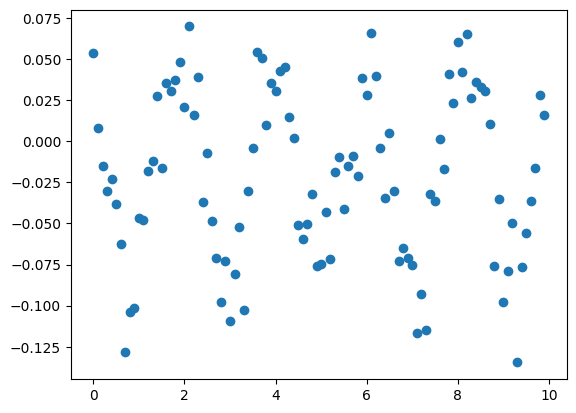

In [52]:
print(process_two_state(run52CycleResults, "000"))
plt.scatter(run3Range, process_two_state(run52CycleResults, "000"))
plt.show()

[-0.0611510791366906, -0.11554192229038851, -0.06762295081967218, -0.046534653465346576, -0.01984877126654061, -0.014227642276422814, 0.03280318091451287, 0.027450980392156876, 0.06673511293634496, 0.05601659751037347, 0.06470588235294117, 0.0506958250497018, 0.04705882352941179, -0.017525773195876337, -0.04417670682730923, -0.005725190839694694, -0.03620352250489234, -0.08522727272727271, -0.05769230769230771, -0.07058823529411762, -0.12523900573613767, -0.0741811175337187, -0.06995884773662553, -0.05900621118012417, -0.033742331288343586, -0.03200000000000003, -0.0031185031185031464, 0.014506769825918725, 0.08895705521472388, 0.07028112449799195, 0.02577319587628868, 0.013238289205702608, -0.019607843137254943, 0.05711422845691383, 0.014099783080260303, -0.007968127490039834, -0.02164948453608251, -0.017034068136272507, -0.06799999999999995, -0.0677799607072691, -0.08283433133732532, -0.06716417910447758, -0.05193482688391038, -0.09631147540983609, -0.044061302681992376, -0.058704453

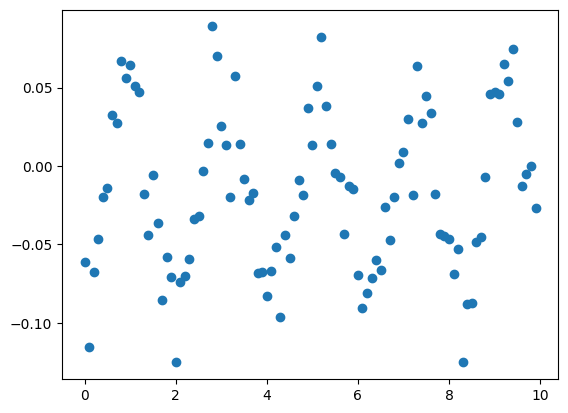

In [53]:
print(process_two_state(run53CycleResults, "0000"))
plt.scatter(run3Range, process_two_state(run53CycleResults, "0000"))
plt.show()

[402, 410, 366, 392, 394, 395, 403, 382, 390, 403, 410, 408, 394, 406, 372, 383, 397, 387, 398, 390, 396, 407, 396, 411, 440, 396, 357, 387, 370, 413, 412, 388, 395, 395, 375, 404, 385, 403, 398, 382, 404, 394, 391, 419, 389, 388, 387, 391, 399, 396, 423, 391, 396, 402, 412, 405, 411, 399, 403, 400, 402, 405, 404, 399, 396, 419, 408, 407, 384, 403, 401, 382, 395, 375, 384, 384, 385, 415, 409, 370, 402, 381, 405, 383, 391, 382, 357, 390, 373, 382, 387, 402, 372, 394, 394, 393, 423, 382, 412, 403]
[0.04726368159203978, 0.03170731707317073, 0.010928961748633892, 0.020408163265306145, -0.0025380710659898, -0.01898734177215189, -0.06079404466501237, -0.03926701570680624, -0.02051282051282055, -0.053349875930521096, -0.060975609756097615, -0.0759803921568627, -0.06598984771573602, -0.007389162561576401, -0.07526881720430112, 0.011749347258485643, -0.041561712846347576, 0.003875968992248069, 0.02010050251256279, 0.023076923076923023, -0.002525252525252486, -0.023341523341523396, 0.00252525252

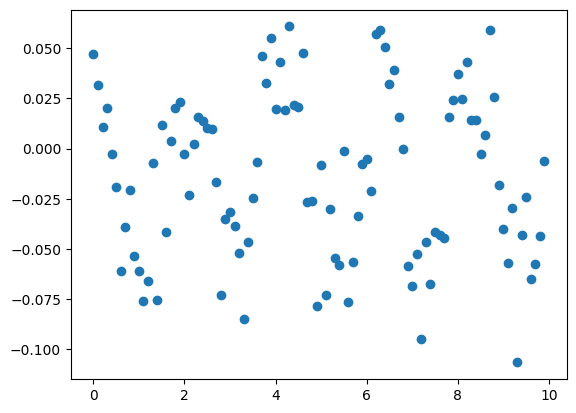

In [64]:
print(process_two_state(run54CycleResults, "00000"))
plt.scatter(run3Range, process_two_state(run54CycleResults, "00000"))
plt.show()

In [56]:
run6Job0Cycle = run_two_state(0, run1Range, 2.5, 1.5, -1, 4, backendJakarta, True)
print(run6Job0Cycle.job_set_id())
run60CycleResults = run6Job0Cycle.results()

9bf1de8f3e5847b0a50bea540ecffcaf-16362997508717487


[-0.0400390625, -0.0146484375, -0.0205078125, -0.0048828125, -0.0263671875, -0.046875, -0.044921875, -0.0595703125, -0.0048828125, -0.013671875, -0.0361328125, -0.001953125, -0.001953125, -0.01171875, 0.01171875, -0.005859375, -0.0068359375, 0.00390625, -0.02734375, -0.0087890625, -0.0234375, 0.0166015625, 0.0087890625, 0.005859375, 0.00390625, -0.0078125, -0.0068359375, -0.017578125, -0.0244140625, 0.0009765625, -0.013671875, -0.0517578125, -0.0224609375, -0.03125, -0.05078125, -0.01171875, -0.0166015625, -0.01953125, -0.0009765625, -0.037109375, -0.0390625, 0.001953125, -0.0234375, -0.0263671875, -0.0224609375, -0.0234375, -0.0205078125, -0.009765625, 0.00390625, -0.015625, -0.00390625, 0.0048828125, 0.017578125, 0.0068359375, 0.0302734375, -0.017578125, -0.05859375, -0.017578125, -0.005859375, 0.00390625, -0.0341796875, 0.009765625, -0.001953125, -0.005859375, -0.03515625, -0.0126953125, -0.0419921875, -0.048828125, -0.0029296875, -0.0166015625, -0.0439453125, -0.0478515625, -0.0390

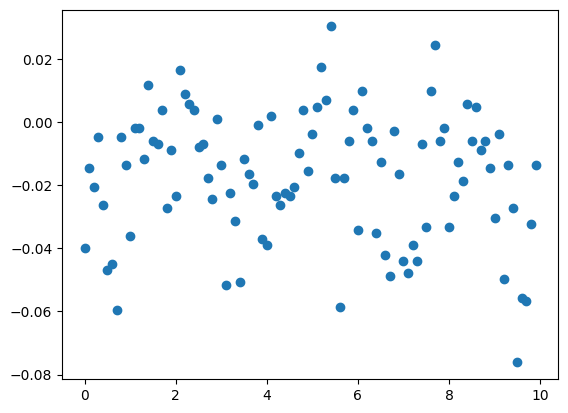

In [58]:
print(process_two_state(run60CycleResults, "0"))
plt.scatter(run3Range, process_two_state(run60CycleResults, "0"))
plt.show()

In [60]:
run7Job0Cycle = run_two_state(0, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False)
print(run7Job0Cycle.job_set_id())
run70CycleResults = run7Job0Cycle.results()

df9cfcdb300a4a8091d59bba493df85e-16363002101311603


[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
[-0.490234375, -0.4306640625, -0.279296875, -0.0810546875, 0.1630859375, 0.3681640625, 0.4501953125, 0.4267578125, 0.2783203125, 0.0927734375, -0.166015625, -0.353515625, -0.4736328125, -0.46875, -0.3701171875, -0.1318359375, 0.0341796875, 0.244140625, 0.416015625, 0.46484375, 0.392578125, 0.1982421875, 0.0107421875, -0.232421875, -0.408203125, -0.4931640625, -0.443359375, -0.302734375, -0.0625, 

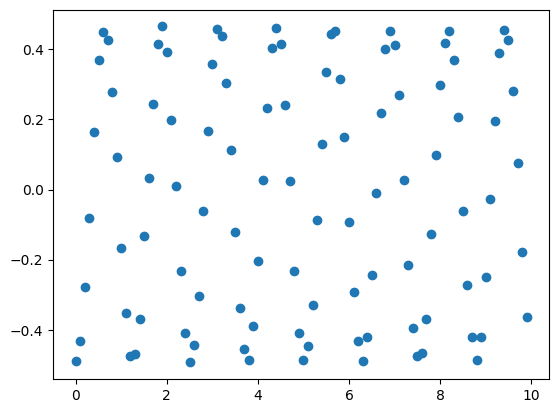

In [63]:
print(process_two_state(run70CycleResults, "0"))
plt.scatter(run3Range, process_two_state(run70CycleResults, "0"))
plt.show()

In [67]:
run8Job1Cycle = run_two_state(1, run1Range, 2.5, 1.5, 1, 4, backendJakarta, True)
print(run8Job1Cycle.job_set_id())
run81CycleResults = run8Job1Cycle.results()

run8Job2Cycle = run_two_state(2, run1Range, 2.5, 1.5, 1, 4, backendJakarta, True)
print(run8Job2Cycle.job_set_id())
run82CycleResults = run8Job2Cycle.results()

run8Job3Cycle = run_two_state(3, run1Range, 2.5, 1.5, 1, 4, backendJakarta, True)
print(run8Job3Cycle.job_set_id())
run83CycleResults = run8Job3Cycle.results()

run8Job4Cycle = run_two_state(4, run1Range, 2.5, 1.5, 1, 4, backendJakarta, True)
print(run8Job4Cycle.job_set_id())
run84CycleResults = run8Job4Cycle.results()

ab197678dab44fe0b9c8da1a7168d3ec-1636301096413536
313800d9d95d41379a3cacc7e727f980-16363013051810856
68f092d040de4053bfc10018533738fe-16363015443579872
88f34879305048b1a7169acb80131183-1636301739849467


[652, 672, 662, 648, 659, 640, 693, 644, 642, 674, 653, 657, 655, 659, 646, 666, 651, 628, 643, 653, 677, 663, 669, 662, 671, 673, 664, 682, 665, 672, 657, 656, 686, 643, 654, 658, 669, 666, 646, 674, 677, 643, 642, 660, 657, 640, 657, 647, 658, 665, 681, 673, 643, 666, 658, 647, 669, 667, 642, 652, 656, 670, 664, 679, 644, 669, 650, 668, 669, 629, 638, 673, 651, 669, 648, 652, 655, 669, 638, 650, 664, 665, 652, 645, 661, 668, 638, 682, 655, 670, 638, 682, 661, 627, 623, 669, 622, 666, 659, 649]
[-0.32515337423312884, -0.28869047619047616, -0.24773413897280971, -0.17901234567901236, -0.11001517450682852, -0.03281250000000002, 0.039682539682539736, 0.12267080745341616, 0.16043613707165114, 0.2537091988130564, 0.2718223583460949, 0.28234398782343995, 0.22366412213740453, 0.19802731411229135, 0.14241486068111453, 0.08858858858858862, -0.025345622119815614, -0.05095541401273884, -0.19673405909797825, -0.20903522205206737, -0.2991137370753324, -0.2737556561085973, -0.26681614349775784, -0.2

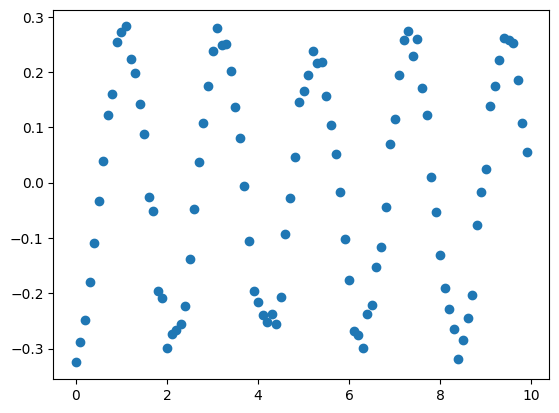

In [68]:
print(process_two_state(run81CycleResults, "00"))
plt.scatter(run3Range, process_two_state(run81CycleResults, "00"))
plt.show()

[387, 381, 373, 391, 403, 366, 366, 397, 350, 377, 411, 372, 398, 371, 366, 367, 336, 405, 367, 363, 355, 360, 384, 365, 374, 371, 369, 383, 367, 353, 388, 376, 380, 366, 366, 362, 392, 380, 384, 364, 368, 372, 374, 350, 361, 342, 400, 356, 384, 377, 371, 368, 369, 378, 373, 348, 408, 377, 399, 390, 353, 378, 377, 358, 361, 382, 373, 382, 382, 382, 386, 364, 360, 373, 358, 373, 375, 395, 364, 375, 361, 352, 365, 349, 374, 352, 390, 391, 382, 379, 405, 395, 384, 360, 371, 376, 408, 376, 362, 399]
[0.07881136950904397, 0.03280839895013121, -0.06836461126005366, -0.02941176470588236, -0.1253101736972705, -0.08743169398907102, -0.12295081967213117, -0.13476070528967254, -0.14857142857142858, -0.1816976127320955, -0.0888077858880778, -0.09139784946236562, -0.002512562814070307, -0.01752021563342321, 0.08469945355191255, 0.08583106267029972, 0.09226190476190477, 0.08518518518518522, 0.11580381471389645, 0.14462809917355376, 0.1507042253521127, 0.07222222222222222, 0.05989583333333329, 0.0013

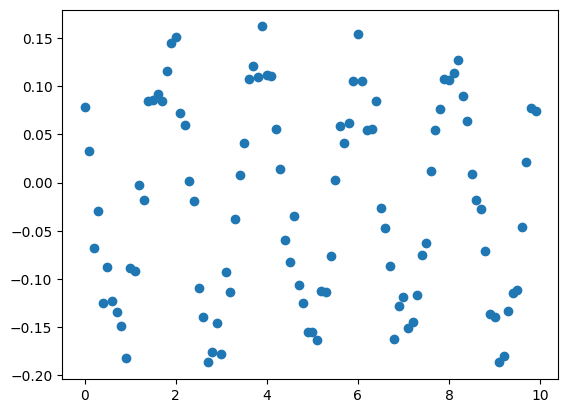

In [69]:
print(process_two_state(run82CycleResults, "000"))
plt.scatter(run3Range, process_two_state(run82CycleResults, "000"))
plt.show()

[286, 274, 277, 274, 283, 295, 263, 293, 308, 293, 272, 279, 304, 280, 258, 291, 280, 284, 285, 287, 294, 279, 268, 278, 251, 279, 313, 282, 295, 305, 272, 274, 285, 302, 286, 327, 281, 279, 296, 294, 302, 265, 277, 302, 301, 341, 288, 265, 257, 277, 284, 292, 246, 310, 271, 310, 287, 296, 295, 301, 273, 304, 295, 281, 289, 281, 292, 302, 292, 278, 313, 289, 309, 286, 315, 293, 280, 285, 294, 260, 286, 286, 297, 290, 271, 306, 270, 278, 286, 299, 284, 294, 253, 314, 302, 296, 292, 309, 295, 260]
[0.16083916083916083, 0.19343065693430653, 0.10649819494584836, 0.0948905109489051, -0.026501766784452263, -0.07288135593220335, -0.13498098859315588, -0.20989761092150172, -0.2727272727272727, -0.26791808873720135, -0.21691176470588236, -0.2060931899641577, -0.14802631578947367, -0.11428571428571432, -0.03100775193798455, 0.015463917525773169, 0.11071428571428574, 0.13028169014084504, 0.17368421052631577, 0.2073170731707317, 0.20068027210884354, 0.20967741935483872, 0.18283582089552233, 0.1043

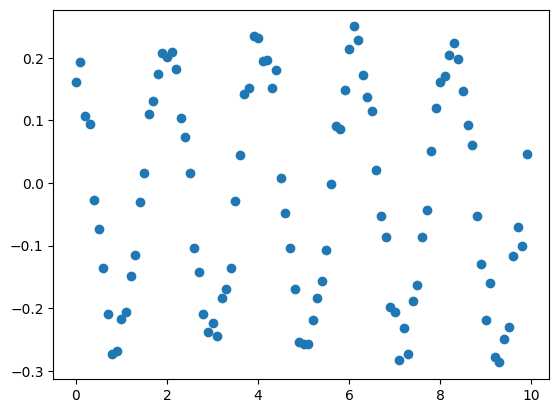

In [70]:
print(process_two_state(run83CycleResults, "0000"))
plt.scatter(run3Range, process_two_state(run83CycleResults, "0000"))
plt.show()

[286, 285, 278, 294, 273, 314, 308, 295, 277, 279, 282, 307, 309, 317, 313, 296, 303, 281, 312, 287, 267, 297, 289, 262, 295, 273, 273, 303, 293, 303, 305, 283, 291, 270, 313, 284, 311, 275, 278, 289, 287, 290, 285, 289, 270, 317, 313, 303, 273, 289, 283, 287, 298, 274, 290, 308, 305, 270, 295, 267, 321, 274, 277, 278, 291, 281, 280, 315, 281, 277, 297, 296, 307, 294, 299, 324, 324, 282, 285, 309, 284, 284, 290, 289, 297, 264, 277, 288, 286, 297, 289, 294, 285, 296, 298, 285, 283, 298, 266, 281]
[0.006993006993006978, 0.015789473684210548, 0.07194244604316546, 0.09183673469387754, 0.07142857142857142, 0.08917197452229297, 0.09415584415584413, 0.05254237288135591, -0.016245487364620947, 0.0017921146953405465, 0.007092198581560294, -0.021172638436482094, -0.1181229773462783, -0.08359621451104104, -0.07507987220447288, -0.10810810810810811, -0.05775577557755773, 0.008896797153024938, -0.022435897435897467, -0.06794425087108014, -0.028089887640449396, 0.06902356902356901, 0.043252595155709

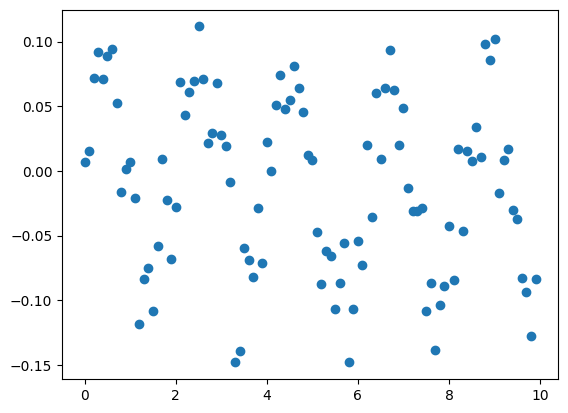

In [71]:
print(process_two_state(run84CycleResults, "00000"))
plt.scatter(run3Range, process_two_state(run84CycleResults, "00000"))
plt.show()

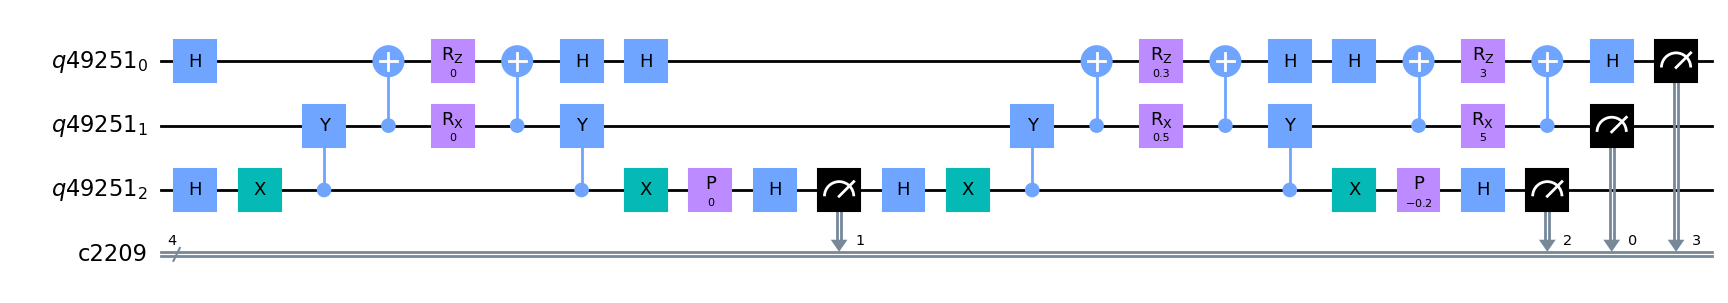

In [80]:
circ = run_rodeo(run1Range, 2, -1, 2.5, 1.5, 1, False, True)
circ.draw('mpl')

In [82]:
run9Job = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run9Job.job_set_id())
run9Results = run9Job.results()

cd7f8c76063642b7825e524d3abcaf21-16363457514317062


[640, 611, 608, 590, 586, 598, 612, 605, 588, 602, 605, 635, 599, 618, 590, 594, 583, 627, 588, 619, 606, 627, 576, 600, 619, 626, 609, 616, 636, 612, 614, 616, 629, 607, 631, 618, 599, 629, 632, 625, 605, 599, 604, 591, 582, 553, 583, 626, 599, 591, 609, 602, 610, 609, 608, 612, 586, 605, 619, 596, 595, 614, 633, 607, 616, 609, 599, 598, 598, 606, 616, 631, 589, 593, 586, 627, 608, 611, 631, 609, 617, 604, 626, 597, 623, 609, 591, 604, 612, 628, 619, 607, 605, 594, 613, 576, 620, 607, 601, 629]
[-0.5109374999999999, -0.46153846153846156, -0.2993421052631579, -0.07288135593220335, 0.18259385665529007, 0.37625418060200666, 0.4852941176470589, 0.4413223140495868, 0.3282312925170068, 0.207641196013289, -0.047933884297520546, -0.3181102362204724, -0.38397328881469106, -0.4692556634304207, -0.34915254237288135, -0.22558922558922556, -0.005145797598627766, 0.17703349282296643, 0.30102040816326525, 0.3570274636510501, 0.34818481848184824, 0.164274322169059, -0.05034722222222221, -0.1849999999

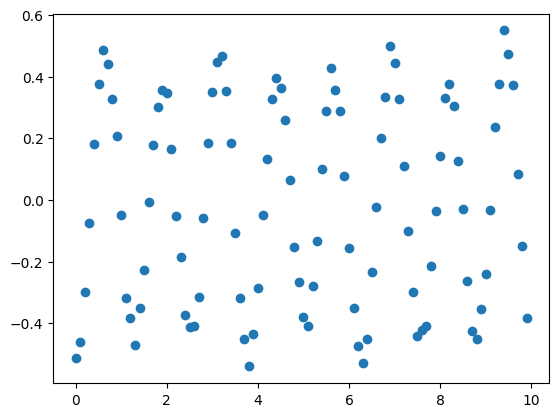

In [83]:
print(process_two_state_dual(run9Results, "00000"))
plt.scatter(run1Range, process_two_state_dual(run9Results, "00000"))
plt.show()

In [32]:
run9Job2 = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run9Job2.job_set_id())
run9Results2 = run9Job2.results()

2b92619e0f7c4cfaa574806f45fb48dd-16376710896343613


[445, 424, 445, 432, 466, 430, 439, 440, 448, 457, 448, 430, 435, 460, 439, 427, 467, 436, 452, 431, 458, 431, 424, 417, 440, 434, 432, 432, 415, 451, 433, 420, 436, 428, 437, 451, 443, 423, 414, 423, 456, 420, 446, 453, 418, 449, 439, 424, 412, 425, 434, 456, 443, 438, 481, 447, 435, 423, 413, 399, 423, 448, 467, 434, 431, 465, 456, 454, 440, 427, 470, 411, 445, 444, 440, 484, 440, 436, 444, 431, 452, 445, 452, 452, 432, 443, 415, 434, 458, 467, 453, 445, 471, 434, 434, 438, 430, 473, 435, 452]
[-0.4876404494382022, -0.5306603773584906, -0.3303370786516853, -0.12037037037037035, 0.1201716738197425, 0.32558139534883734, 0.48747152619589973, 0.4772727272727273, 0.3705357142857143, 0.19256017505470457, -0.024553571428571508, -0.17906976744186043, -0.3655172413793103, -0.417391304347826, -0.3644646924829158, -0.20843091334894615, -0.0770877944325482, 0.15825688073394495, 0.2588495575221238, 0.30626450116009285, 0.29694323144104795, 0.18561484918793503, -0.04952830188679247, -0.30215827338

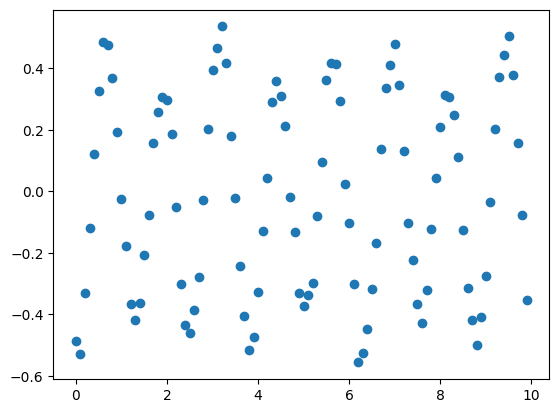

In [33]:
print(process_two_state_dual(run9Results2, "00000"))
plt.scatter(run1Range, process_two_state_dual(run9Results2, "00000"))
plt.show()

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
first run job id: 31b41e1412514a22bb2bd1c4c43fa237-16363468422700083
second pass w/ peaks:
[-4.0, -1.0, 0.0, 1.0, 3.0, 4.0]
first run job id: 8e8a8f99e91341b09c2312eb6298b6c1-16363471783677413
done w/ second pass


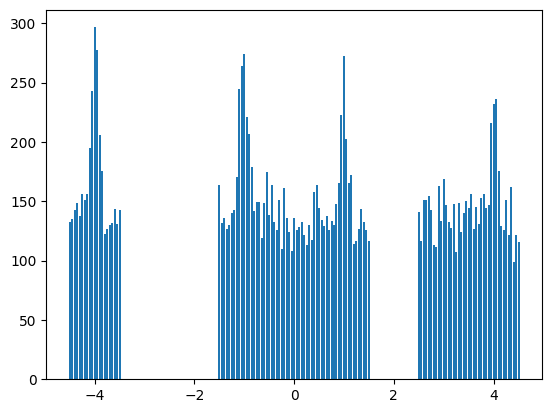

In [86]:
allOverlapSpec = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, 2.5, 1.5, backend=backendJakarta), 1)
plot_scans(allOverlapSpec)

In [87]:
print(allOverlapSpec)

[[[-4.5, 132.84], [-4.45, 135.12], [-4.4, 142.92], [-4.35, 148.2], [-4.3, 137.8], [-4.25, 155.88], [-4.2, 151.08], [-4.15, 156.24], [-4.1, 195.0], [-4.05, 243.0], [-4.0, 296.64], [-3.95, 277.48], [-3.9, 206.12], [-3.85, 175.52], [-3.8, 122.28], [-3.75, 126.32], [-3.7, 129.8], [-3.65, 132.12], [-3.6, 143.48], [-3.55, 131.0], [-3.5, 142.84]], [[-1.5, 163.6], [-1.4500000000000002, 131.72], [-1.4, 135.96], [-1.35, 126.44], [-1.3, 129.68], [-1.25, 140.32], [-1.2000000000000002, 143.0], [-1.15, 170.84], [-1.1, 244.24], [-1.05, 264.32], [-1.0, 274.32], [-0.95, 221.36], [-0.9, 206.56], [-0.8500000000000001, 179.0], [-0.8, 141.4], [-0.75, 149.32], [-0.7, 149.24], [-0.65, 118.88], [-0.6, 148.4], [-0.55, 174.92], [-0.5, 138.72]], [[-0.5, 129.12], [-0.45000000000000007, 163.72], [-0.4, 132.36], [-0.3500000000000001, 125.76], [-0.30000000000000004, 151.4], [-0.25, 109.52], [-0.20000000000000007, 161.6], [-0.15000000000000002, 136.32], [-0.10000000000000009, 123.84], [-0.050000000000000044, 108.2], 

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
first run job id: c88acbca74134a7e9655fd3c85d8e7c4-16363487498615456
second pass w/ peaks:
[-5.0, -4.0, -2.0, -1.0, 0.0, 1.0, 4.0, 5.0]
first run job id: 810ec2f0fbc04ea6988ad86c53b538e2-1636349046568691
done w/ second pass


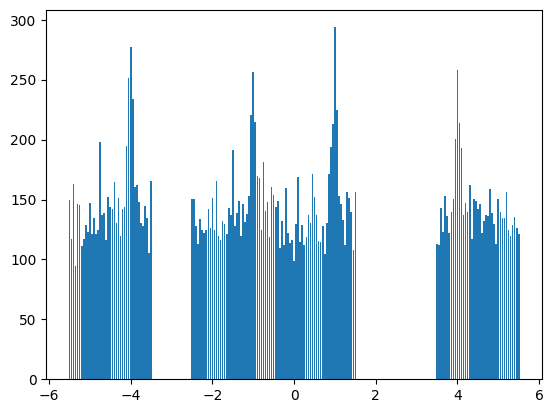

[[[-5.5, 149.36], [-5.45, 117.2], [-5.4, 162.64], [-5.35, 94.72], [-5.3, 146.2], [-5.25, 145.2], [-5.2, 111.6], [-5.15, 117.32], [-5.1, 128.76], [-5.05, 122.72], [-5.0, 147.32], [-4.95, 120.84], [-4.9, 134.32], [-4.85, 121.44], [-4.8, 124.96], [-4.75, 198.32], [-4.7, 136.84], [-4.65, 139.12], [-4.6, 116.56], [-4.55, 152.44], [-4.5, 122.88]], [[-4.5, 143.76], [-4.45, 142.4], [-4.4, 164.48], [-4.35, 130.2], [-4.3, 150.88], [-4.25, 119.68], [-4.2, 142.24], [-4.15, 144.04], [-4.1, 194.36], [-4.05, 251.4], [-4.0, 277.4], [-3.95, 234.16], [-3.9, 160.52], [-3.85, 162.4], [-3.8, 148.04], [-3.75, 130.44], [-3.7, 128.04], [-3.65, 144.88], [-3.6, 134.56], [-3.55, 105.44], [-3.5, 165.16]], [[-2.5, 150.12], [-2.45, 150.2], [-2.4, 128.16], [-2.35, 112.76], [-2.3, 133.8], [-2.25, 124.52], [-2.2, 121.92], [-2.15, 124.76], [-2.1, 141.68], [-2.05, 125.84], [-2.0, 151.16], [-1.95, 124.92], [-1.9, 165.48], [-1.85, 119.36], [-1.8, 116.44], [-1.75, 131.84], [-1.7, 129.76], [-1.65, 121.08], [-1.6, 142.88], [

In [88]:
allOverlapSpec2 = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, 2.5, 1.5, backend=backendJakarta), 1)
plot_scans(allOverlapSpec2)
print(allOverlapSpec2)

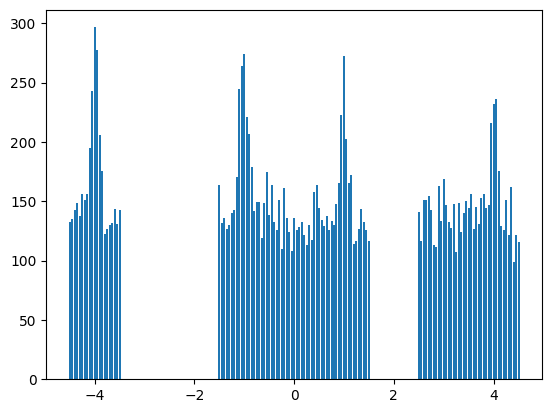

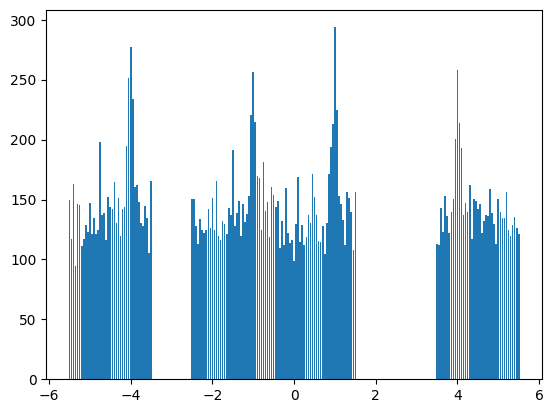

In [89]:
plot_scans(allOverlapSpec)
plot_scans(allOverlapSpec2)

In [90]:
run10Job0 = run_two_state(0, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job0.job_set_id())
run10Results0 = run10Job0.results()

run10Job1 = run_two_state(1, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job1.job_set_id())
run10Results1 = run10Job1.results()

run10Job2 = run_two_state(2, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job2.job_set_id())
run10Results2 = run10Job2.results()

run10Job3 = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job3.job_set_id())
run10Results3 = run10Job3.results()

run10Job4 = run_two_state(4, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job4.job_set_id())
run10Results4 = run10Job4.results()

run10Job5 = run_two_state(5, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run10Job5.job_set_id())
run10Results5 = run10Job5.results()

print("done with all")

4d34aca733c143679372033076bbc461-16363775384703617
14a69ab302b44fa1a2fd369444fb3023-1636377671323529
9041c8fbcecc4f4dbf70c93aa32d4b43-16363778924858296
51d18d3b0f71434aaa1ebd03fcd8239b-16363780891270692
b64dcce65b184b7fa1262875209ad9de-16363782918624887
b9f45b9d0953462195ddb86f76b4d9af-16363784040733578
done with all


[1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024]
[-0.9501953125, -0.8876953125, -0.681640625, -0.4111328125, -0.0625, 0.26171875, 0.501953125, 0.5771484375, 0.529296875, 0.4033203125, 0.2451171875, 0.0361328125, -0.1171875, -0.1669921875, -0.169921875, -0.123046875, -0.0166015625, 0.0244140625, 0.05859375, 0.01171875, -0.1162109375, -0.3115234375, -0.4609375, -0.630859375, -0.7216796875, -0.662109375, -0.5390625, -0.267578125, 0.150390625, 0.42

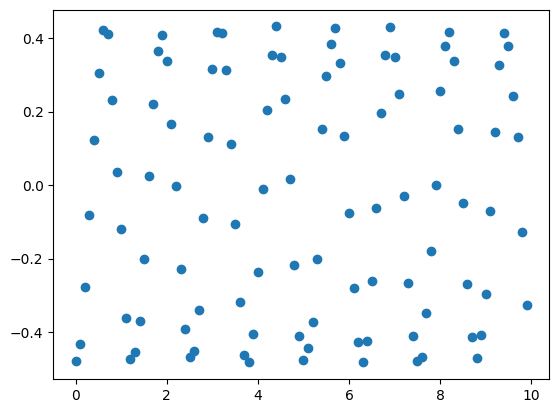

In [92]:
print(process_two_state_dual(run10Results0, "00"))
plt.scatter(run1Range, process_two_state(run10Results0, "00"))
plt.show()

[855, 857, 844, 855, 846, 870, 868, 860, 859, 875, 856, 872, 848, 856, 882, 876, 841, 869, 854, 859, 864, 834, 850, 864, 871, 852, 849, 855, 864, 842, 839, 871, 893, 873, 863, 866, 848, 852, 873, 848, 860, 869, 866, 870, 898, 865, 857, 866, 861, 850, 865, 861, 865, 868, 856, 818, 870, 856, 843, 854, 868, 881, 859, 879, 850, 845, 866, 872, 857, 841, 863, 858, 851, 865, 844, 860, 866, 854, 870, 863, 864, 868, 849, 851, 873, 849, 859, 849, 851, 834, 847, 874, 855, 851, 847, 855, 869, 855, 860, 853]
[-0.10643274853801166, -0.037339556592765444, 0.08530805687203802, 0.20701754385964913, 0.2836879432624114, 0.3275862068965517, 0.2569124423963134, 0.13372093023255816, -0.14435389988358557, -0.3931428571428571, -0.6565420560747663, -0.8165137614678899, -0.8761792452830189, -0.8014018691588785, -0.5419501133786848, -0.23972602739726023, 0.13793103448275865, 0.4131185270425777, 0.6241217798594847, 0.7217694994179278, 0.6435185185185185, 0.460431654676259, 0.23764705882352943, -0.0243055555555555

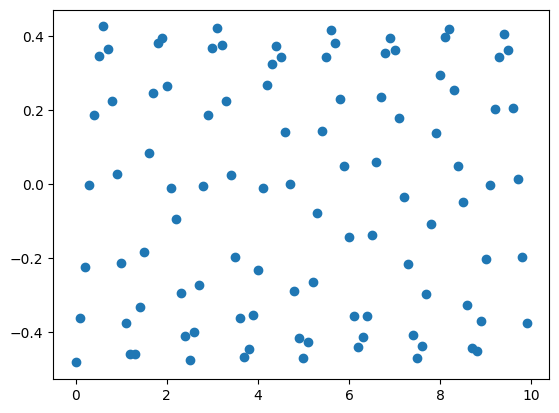

In [91]:
print(process_two_state_dual(run10Results1, "000"))
plt.scatter(run1Range, process_two_state(run10Results1, "000"))
plt.show()

[579, 581, 559, 523, 552, 553, 555, 582, 597, 554, 562, 559, 593, 553, 549, 570, 560, 566, 539, 530, 555, 550, 579, 570, 555, 597, 551, 540, 584, 564, 566, 592, 547, 547, 557, 546, 560, 569, 554, 558, 567, 565, 580, 561, 557, 535, 569, 562, 562, 550, 568, 569, 558, 552, 552, 550, 534, 548, 559, 546, 547, 581, 575, 519, 534, 520, 563, 546, 556, 574, 570, 588, 534, 558, 582, 528, 558, 530, 560, 565, 577, 544, 552, 559, 522, 566, 539, 543, 527, 576, 562, 545, 561, 564, 564, 562, 575, 574, 554, 543]
[-0.3367875647668394, -0.2512908777969018, -0.16994633273703041, 0.030592734225621476, 0.10144927536231885, 0.3309222423146474, 0.28828828828828834, 0.23024054982817876, 0.06030150753768837, -0.14259927797833938, -0.32562277580071175, -0.5456171735241503, -0.5699831365935919, -0.6292947558770343, -0.4954462659380693, -0.3070175438596492, -0.0357142857142857, 0.21378091872791516, 0.4452690166975881, 0.539622641509434, 0.4396396396396396, 0.3563636363636364, 0.17616580310880828, -0.09824561403508

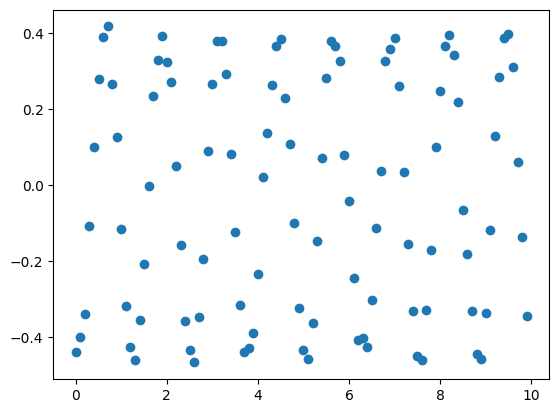

In [93]:
print(process_two_state_dual(run10Results2, "0000"))
plt.scatter(run1Range, process_two_state(run10Results2, "0000"))
plt.show()

[659, 605, 629, 630, 639, 648, 595, 629, 644, 653, 628, 641, 641, 623, 640, 638, 627, 610, 630, 643, 638, 615, 644, 634, 642, 615, 625, 649, 650, 656, 618, 634, 636, 619, 635, 618, 598, 600, 643, 647, 601, 627, 640, 664, 613, 627, 651, 648, 630, 629, 628, 634, 612, 643, 651, 637, 631, 650, 632, 640, 620, 634, 649, 600, 621, 646, 648, 634, 642, 644, 614, 658, 629, 631, 630, 650, 639, 638, 589, 610, 622, 626, 638, 645, 627, 633, 620, 623, 629, 631, 625, 642, 614, 650, 609, 640, 630, 639, 615, 612]
[-0.7223065250379364, -0.7388429752066116, -0.5659777424483308, -0.3396825396825396, -0.1408450704225352, 0.18055555555555558, 0.3445378151260504, 0.3926868044515104, 0.3555900621118012, 0.2679938744257274, 0.019108280254777066, -0.03744149765990645, -0.17472698907956324, -0.24558587479935784, -0.221875, -0.11442006269592475, 0.07177033492822962, 0.13770491803278684, 0.14761904761904765, 0.20684292379471225, 0.08307210031347956, -0.07642276422764227, -0.2515527950310559, -0.4700315457413249, -0

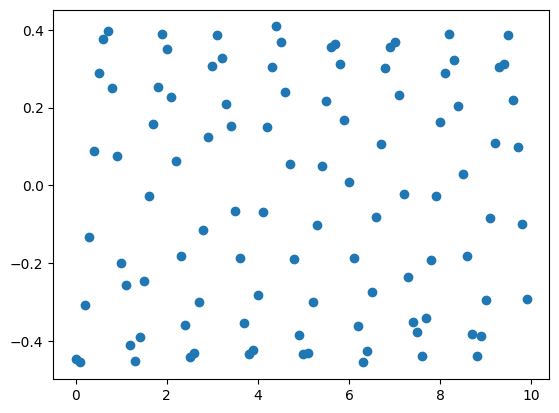

In [94]:
print(process_two_state_dual(run10Results3, "00000"))
plt.scatter(run1Range, process_two_state(run10Results3, "00000"))
plt.show()

[390, 325, 342, 358, 361, 352, 341, 345, 352, 311, 334, 357, 355, 361, 354, 365, 366, 349, 359, 338, 346, 340, 376, 355, 354, 347, 377, 353, 350, 366, 348, 349, 335, 352, 381, 373, 351, 345, 351, 346, 388, 353, 329, 323, 352, 336, 349, 353, 361, 343, 331, 363, 353, 320, 350, 330, 328, 364, 351, 330, 350, 353, 344, 362, 377, 372, 354, 344, 348, 362, 361, 355, 320, 355, 351, 335, 355, 354, 367, 355, 347, 356, 327, 336, 388, 351, 367, 307, 324, 363, 348, 342, 359, 361, 364, 360, 361, 354, 350, 346]
[-0.4743589743589743, -0.4523076923076924, -0.34795321637426907, -0.07541899441340782, 0.14127423822714688, 0.2755681818181819, 0.3812316715542522, 0.36811594202898557, 0.2414772727272728, 0.022508038585209028, -0.14071856287425144, -0.42296918767507, -0.4929577464788732, -0.5567867036011079, -0.4096045197740113, -0.32602739726027397, 0.0, 0.0515759312320917, 0.2339832869080779, 0.3017751479289942, 0.2774566473988439, 0.18529411764705883, -0.007978723404255261, -0.22535211267605626, -0.32203389

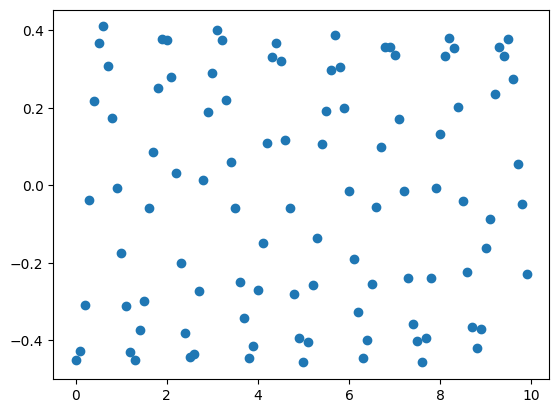

In [95]:
print(process_two_state_dual(run10Results4, "000000"))
plt.scatter(run1Range, process_two_state(run10Results4, "000000"))
plt.show()

[374, 340, 383, 351, 364, 376, 365, 372, 363, 399, 379, 370, 345, 388, 365, 378, 387, 358, 363, 379, 373, 371, 361, 373, 402, 356, 365, 338, 371, 365, 351, 357, 351, 342, 368, 393, 362, 384, 339, 365, 360, 376, 369, 348, 367, 383, 333, 365, 368, 375, 344, 368, 355, 386, 381, 356, 371, 353, 362, 383, 367, 386, 361, 372, 365, 346, 370, 397, 352, 334, 395, 341, 380, 374, 392, 344, 368, 372, 358, 373, 356, 367, 373, 361, 355, 350, 376, 369, 372, 385, 343, 370, 349, 377, 374, 361, 351, 349, 359, 353]
[-0.4919786096256684, -0.4088235294117647, -0.2898172323759792, -0.11396011396011396, 0.07142857142857148, 0.29255319148936165, 0.3671232876712329, 0.3978494623655914, 0.23691460055096425, 0.040100250626566414, -0.12928759894459096, -0.33513513513513504, -0.45507246376811594, -0.5025773195876289, -0.3616438356164384, -0.2063492063492064, -0.031007751937984523, 0.16480446927374304, 0.27548209366391185, 0.36939313984168864, 0.2654155495978553, 0.2048517520215634, -0.08033240997229918, -0.25469168

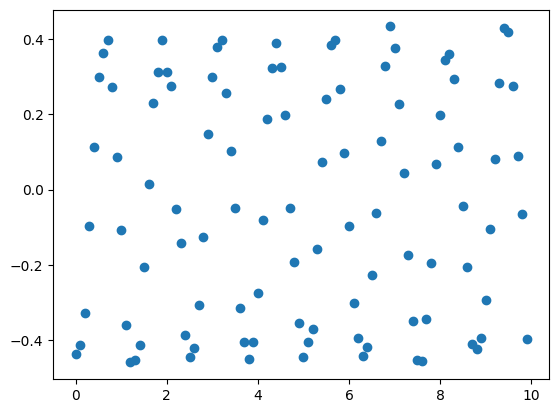

In [96]:
print(process_two_state_dual(run10Results5, "0000000"))
plt.scatter(run1Range, process_two_state(run10Results5, "0000000"))
plt.show()

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
first run job id: 37bf87c6569e40fb85bd1be1df538073-16365684427928798
second pass w/ peaks:
[-1.0, 4.0]
second run job id: 08ac3e41242c463e940fe5a4fa3e204f-16365685470063767
done w/ second pass
[[[-1.5, 29.96], [-1.4500000000000002, 33.4], [-1.4, 31.2], [-1.35, 32.08], [-1.3, 33.8], [-1.25, 31.72], [-1.2000000000000002, 27.12], [-1.15, 62.6], [-1.1, 52.96], [-1.05, 127.64], [-1.0, 204.52], [-0.95, 149.72], [-0.9, 61.56], [-0.8500000000000001, 33.32], [-0.8, 33.28], [-0.75, 43.44], [-0.7, 46.24], [-0.65, 32.6], [-0.6, 32.08], [-0.55, 35.68], [-0.5, 37.28]], [[3.5, 44.4], [3.55, 29.44], [3.6, 37.52], [3.65, 38.0], [3.7, 40.72], [3.75, 27.8], [3.8, 41.36], [3.85, 66.6], [3.9, 75.04], [3.95, 159.08], [4.0, 204.44], [4.05, 132.16], [4.1, 63.64], [4.15, 47.84], [4.2, 31.76], [4.25, 27.0], [4.3, 23.84], [4.35, 42.24], [4.4, 38.36], [4.45, 33.8], [4.5, 37.56]]]


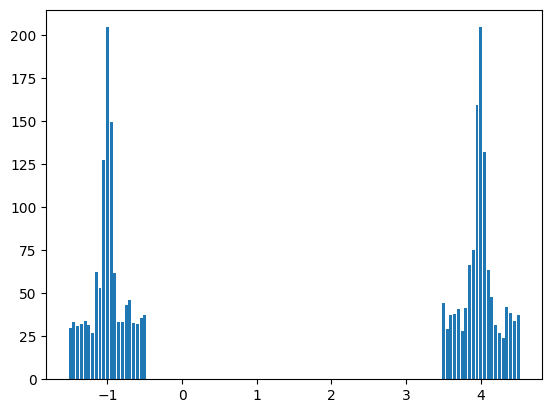

In [12]:
fiveCycle = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 5, 21, 25, 2.5, 1.5, backendJakarta), 1)
print(fiveCycle)
plot_scans(fiveCycle)

In [18]:
run11Job = run_two_state(3, run1Range, 2.5, 1.5, -1, 4, backendJakarta, False, True)
print(run11Job.job_set_id())
run11Results = run11Job.results()

08074e7d650643138c8a7aa7374a04bc-1637047850140956


[453, 434, 463, 459, 468, 465, 455, 461, 454, 483, 453, 476, 417, 425, 483, 474, 451, 461, 456, 453, 448, 457, 440, 475, 441, 467, 446, 462, 456, 449, 479, 419, 448, 453, 456, 466, 448, 470, 448, 455, 444, 461, 452, 434, 455, 443, 446, 423, 473, 440, 442, 453, 446, 465, 461, 455, 440, 465, 476, 449, 480, 477, 453, 460, 433, 455, 471, 425, 466, 438, 483, 460, 460, 464, 481, 434, 449, 446, 444, 435, 448, 449, 458, 469, 476, 444, 458, 412, 461, 459, 438, 444, 467, 427, 463, 447, 477, 452, 435, 441]
[-0.4922737306843266, -0.47695852534562216, -0.35205183585313177, -0.08932461873638342, 0.14316239316239313, 0.34838709677419355, 0.41538461538461546, 0.4490238611713666, 0.29074889867841414, 0.062111801242235976, -0.13024282560706402, -0.2836134453781513, -0.4100719424460432, -0.4376470588235294, -0.3581780538302277, -0.23839662447257381, 0.05321507760532154, 0.19956616052060736, 0.3157894736842105, 0.4370860927152318, 0.3258928571428571, 0.17067833698030632, -0.11818181818181817, -0.223157894

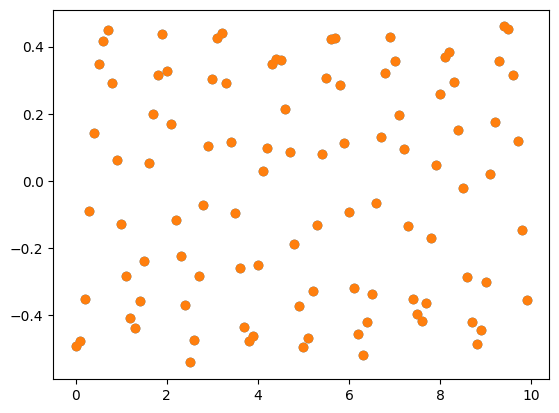

In [20]:
print(process_two_state_dual(run11Results, "00000"))
plt.scatter(run1Range, process_two_state_dual(run11Results, "00000"))
plt.show()

In [21]:
averageSuccesses = list()
times = []
state = '0'
for i in range(6):
    state = state + '0'
    times.append(np.random.normal(0, 7))
    circs = []
    for j in range(25):
        circs.append(run_rodeo(times, i+1, 4, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend, shots=1024)
    temp = 0
    for k in range(25):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/25
    averageSuccesses.append(temp)

In [23]:
#ids (1 up through 6):
#619361c01fe02d2167c3eea7
#619361e20fca888fe20f3768
#619361f9fc46da11868e725d
#619362169c22c3f1cee61a24
#6193622b0b2c1277b1701458
#619362444633b702742235fb

print(averageSuccesses)

[644.6, 493.56, 248.28, 113.24, 87.12, 58.16]


In [26]:
averageSuccesses2 = list()
times = []
state = '0'
for i in range(6):
    state = state + '0'
    times.append(np.random.normal(0, 7))
    circs = []
    for j in range(25):
        circs.append(run_rodeo(times, i+1, 2.5, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend, shots=1024)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(25):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/25
    averageSuccesses2.append(temp)

job: 1
84711b3e56f449dc9579f7468b8cd6ff-163704998959255
job: 2
d0794fba60424ebdaf4575a1569e3dae-16370500839235544
job: 3
6861e92acce94ef4aa83a6b8a56e8d70-163705010457876
job: 4
2bd0c45e86ec44a0be02027147c33b4d-16370501583886209
job: 5
8dd98c6866524ff6878e0813ad6b2d8b-163705018155113
job: 6
61bff71621bb4a73a102602729c6df5a-16370502049272296


In [27]:
print(averageSuccesses2)

[508.24, 296.04, 52.28, 26.32, 12.88, 6.8]


In [15]:
averageSuccesses3 = list()
times = []
state = '0'

jobs = list()

jobs.append(jobManager.retrieve_job_set('0e56a8df1b224e4f92b18ca855104744-16372231264776256', provider))
jobs.append(jobManager.retrieve_job_set('63302af4e3fe40ad8910e2ae6d380c4c-16372249336051407', provider))
jobs.append(jobManager.retrieve_job_set('6395aa665d78446286670d913b9f2076-16372259460399103', provider))
jobs.append(jobManager.retrieve_job_set('48568c9bc07c4368bbb086b9a71854da-16372273729760299', provider))
jobs.append(jobManager.retrieve_job_set('9bec5554c33f4490af279f794b2cf32c-1637249220195117', provider))
jobs.append(jobManager.retrieve_job_set('9aa760561b164f5bbfb152b3b123877f-1637288351876479', provider))
for job in jobs:
    state = state + '0'
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses3.append(temp)
print("done with -1")
print(averageSuccesses3)

C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjobset.py:195: DeprecationWarning: The ``IBMQJob.qobj()`` method is deprecated and will be removed in a future release. You can now pass circuits to ``IBMQBackend.run()`` and use ``IBMQJob.circuits()``, ``IBMQJob.backend_options()``, and ``IBMQJob.header()`` to retrieve circuits, run configuration, and Qobj header, respectively.
  experiments_count=len(job.qobj().experiments),


done with -1
[769.0498046875, 388.673828125, 230.4833984375, 143.1318359375, 81.1552734375, 50.728515625]


In [19]:
averageSuccesses4 = list()
state = '0'
times = []
jobs = []

jobs.append(jobManager.retrieve_job_set('2f09f0c2d91f4e4d8d34293b803058f0-16372961681295235', provider))
jobs.append(jobManager.retrieve_job_set('5745882d47ed46c88950fbdebe985d89-1637297152964673', provider))
jobs.append(jobManager.retrieve_job_set('13fe7dda81dd4920af4cba9b951fe01e-16372986311821728', provider))
jobs.append(jobManager.retrieve_job_set('316f45cc39844f6087174f1d2a70cdce-1637308077648706', provider))
jobs.append(jobManager.retrieve_job_set('eefbc8c1eebe4f2396018cb0f1859ea5-16373402735990226', provider))

for i in range(6):
    times.append(np.random.normal(0,7))

circs = []
for i in range(1024):
    circs.append(run_rodeo(times, 6, 4, 2.5, 1.5))
circs = transpile(circs, backend=backend)
print('running job 6')
jobs.append(jobManager.run(circs, backend=backend, shots=1024))
print(jobs[5].job_set_id())

for job in jobs:
    state = state + '0'
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses4.append(temp)
print("done with 4")
print(averageSuccesses4)

running job 6
e289686fe44042dc8750e6666404bd9d-16373468899512572
done with 4
[891.8251953125, 568.8251953125, 348.107421875, 289.6630859375, 226.8125, 53.8662109375]


In [20]:
averageSuccesses5 = list()
times = []
state = '0'
for i in range(6):
    state = state + '0'
    times.append(np.random.normal(0, 7))
    circs = []
    for j in range(1024):
        circs.append(run_rodeo(times, i+1, 0, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend, shots=1024)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses5.append(temp)
print("done with 0")
print(averageSuccesses5)

job: 1
7831710778854a80bb8cf84f36a75c96-16373486879670866
job: 2
b2e99bcd3a1740e993143153c6c25cde-1637349096627502
job: 3
7d328130b1a04aaa8690f74905a5cbb1-1637349544450923
job: 4
d893b6f43e1d4e5bbee02ce8f33490db-16373500005959709
job: 5
bb57a7873d994b34a2973118c4e3f920-16373506392842793
job: 6
ddc50af8a8ab44b29cfa1d9155514a36-163735130612608
done with 0
[415.205078125, 212.314453125, 73.693359375, 46.95703125, 40.6181640625, 31.013671875]


In [23]:
averageSuccesses6 = list()
state = '0'
for i in range(6):
    state = state + '0'
    circs = []
    for j in range(1024):
        times = []
        for k in range(i+1):
            times.append(np.random.normal(0, 7))
        circs.append(run_rodeo(times, i+1, -1, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend, shots=1024)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses6.append(temp)
print("done with -1")
print(averageSuccesses6)

job: 1
d32af01c8bdb41b092df59eb175e1202-16373548709481738
job: 2
1c9c816dcdb441c19c4e0ca2f3aee739-16373602292860484
job: 3
89f1bdec4b274668a05da21f136ab991-16373610499465005
job: 4
1ce0b0568905410eb435918cc4a055d4-16373616630527878
job: 5
cc5d9fb5edf34253973b0942c039ff4b-16373622403380942
job: 6
62660a8254ef4c8e9eab112e86b9dcea-16373628326656618
done with -1
[622.662109375, 390.0224609375, 257.7216796875, 160.5986328125, 111.056640625, 72.1279296875]


In [25]:
averageSuccesses7 = list()
state = '0'
for i in range(6):
    state = state + '0'
    circs = []
    for j in range(1024):
        times = []
        for k in range(i+1):
            times.append(np.random.normal(0, 7))
        circs.append(run_rodeo(times, i+1, 4, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend, shots=1024)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses7.append(temp)
print("done with 4")
print(averageSuccesses7)

job: 1
b294b7e9c7f14f03914bb5899b24c23b-16373637220239582
job: 2
26b8ae8e91914229a33009e3da7f1f3b-16373641766786351
job: 3
47b365ec5b11449bafa915d601e8fbd2-1637364823196747
job: 4
93cca31966b74ab29b2932306024bf95-1637365345773776
job: 5
9ac35cc34c2644ef822901e9cd2e1f4f-16373658722231896
job: 6
af45901057e14777b472b415d34a2112-163736684298813
done with -1
[628.5693359375, 396.435546875, 255.62109375, 176.9287109375, 111.21484375, 79.01953125]
job: 1
9855b76ac46941038737a7831058032b-16373674865824015


C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjob.py:202: UserWarning: Unable to retrieve job result for experiments 0-299, job ID=61983ebf68476d36708a754c: 'Unable to retrieve result for job 61983ebf68476d36708a754c. Job was cancelled.' 
  warnings.warn(
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjob.py:202: UserWarning: Unable to retrieve job result for experiments 300-599, job ID=61983ec2580e75335014e1ef: 'Unable to retrieve result for job 61983ec2580e75335014e1ef. Job was cancelled.' 
  warnings.warn(
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\managed\managedjob.py:202: UserWarning: Unable to retrieve job result for experiments 600-899, job ID=61983ec41db79f776fda279c: 'Unable to retrieve result for job 61983ec41db79f776fda279c. Job was cancelled.' 
  warnings.warn(
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\qiskit\providers\ibmq\manag

IBMQManagedResultDataNotAvailable: 'Result data for experiment 0 is not available.'

In [26]:
averageSuccesses8 = list()
state = '0'
for i in range(6):
    state = state + '0'
    circs = []
    for j in range(1024):
        times = []
        for k in range(i+1):
            times.append(np.random.normal(0, 7))
        circs.append(run_rodeo(times, i+1, 0, 2.5, 1.5))
    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend, shots=1024)
    print('job: ' + str(i+1))
    print(job.job_set_id())
    temp = 0
    for k in range(1024):
        temp = temp + deNone(job.results().get_counts(k).get(state))
    temp = temp/1024
    averageSuccesses8.append(temp)
print("done with 0")
print(averageSuccesses8)

job: 1
39bfe00bccae479aaf5c2033d95a9cb2-16373675615539527
job: 2
cbace1a099ac40b4ad9e2fa73931b06e-16373680348038223
job: 3
b0a161b4c8f54181b8edb7505a6f858a-16373685873499124
job: 4
894c6514321f435f87df842045b2ed97-16373694147475128
job: 5
bb37c346d5f64b79bee57729dbb5dea2-16373699478942406
job: 6
7e319ee32461410292bedcc692df2eac-1637370509874053
done with 0
[504.140625, 256.65234375, 129.1337890625, 67.4716796875, 36.1748046875, 15.171875]


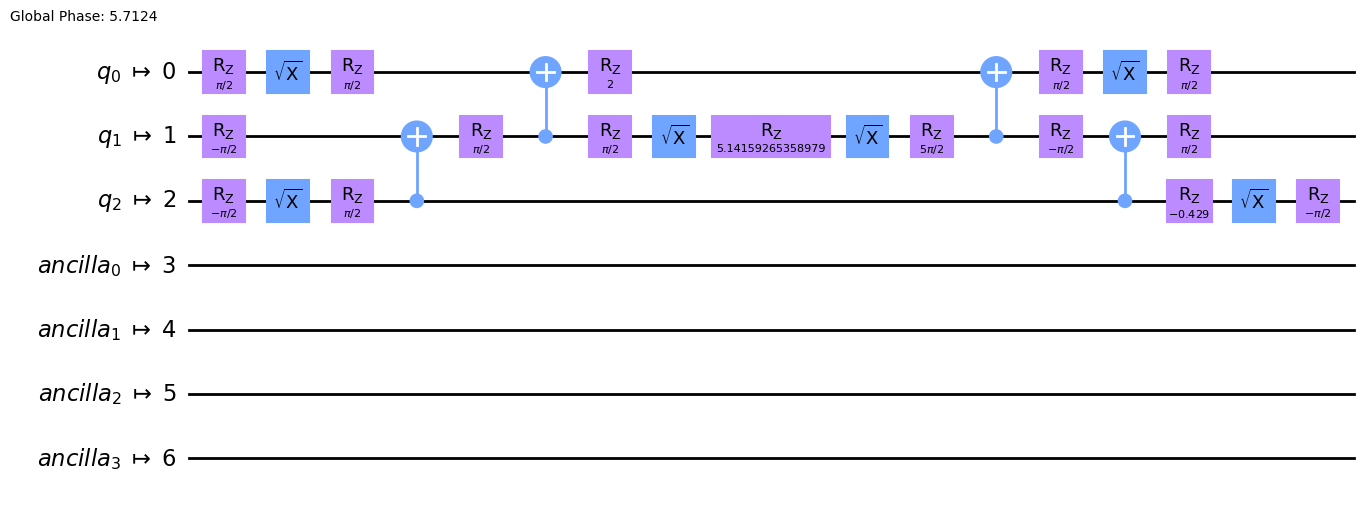

In [34]:
test = make_cycle(1, 1, 1, 1)
test = transpile(test, backend)
test.draw('mpl')

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
first run job id: 3aebd200e01542d18ecb8e352a55a146-16382619247297838
second pass w/ peaks:
[-5.0, -3.0, -2.0, 2.0, 3.0, 5.0]
second run job id: 49ebab28efb84b6f89edd381e971dfae-1638262105883612
done w/ second pass


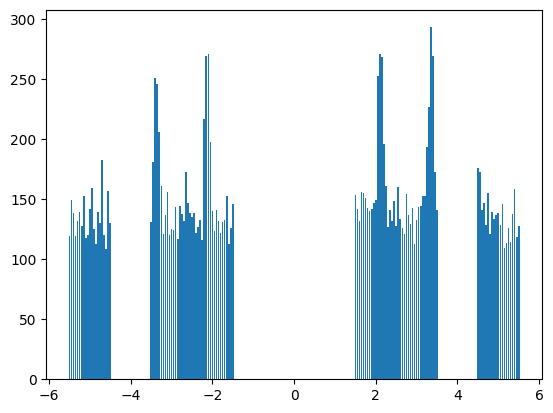

In [32]:
testRun = search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, prodXMod, prodZMod, backendJakarta)
testRunData = process_data(testRun, 1)
plot_scans(testRunData)

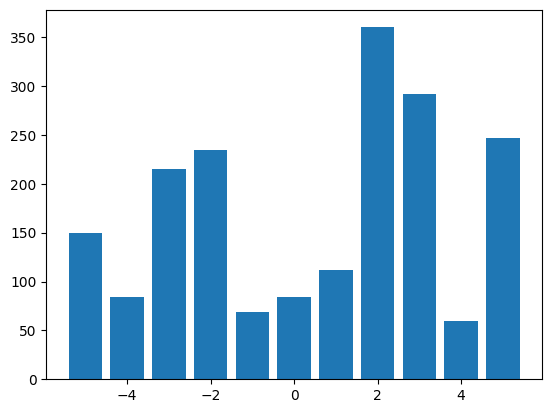

In [33]:
plot_scans(process_data(testRun, 0))

first run job id: 5e8afb88e25a4f008a3994d86e076619-16397677817660146
[-4.0, -1.0, 1.0, 4.0]
[-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -3.5, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999999, -0.7, -0.6, -0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4, 1.5, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5]
second run job id: e584f605d7944746852bcf552737536c-16397677951862838
[-4.0, -1.3, -1.0, 0.9, 3.8]
third run job id: f06a05b1569b4155a10deb23f0f63d33-1639767868285702
[array([  0.,  82.,  34.,  60., 162., 450., 137.,  11., 312., 104.,  13.,
       107., 151., 153.,  65., 203., 312., 260., 207.,  46., 235.,   1.,
         0., 213.,  97.,  40., 255., 241., 153., 144., 102., 253.,   1.,
       214., 229., 155., 259.,  53., 270., 137.,  92.,  15.,  37., 144.]), [-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -3.5, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999999, -0.7, -0.6, -

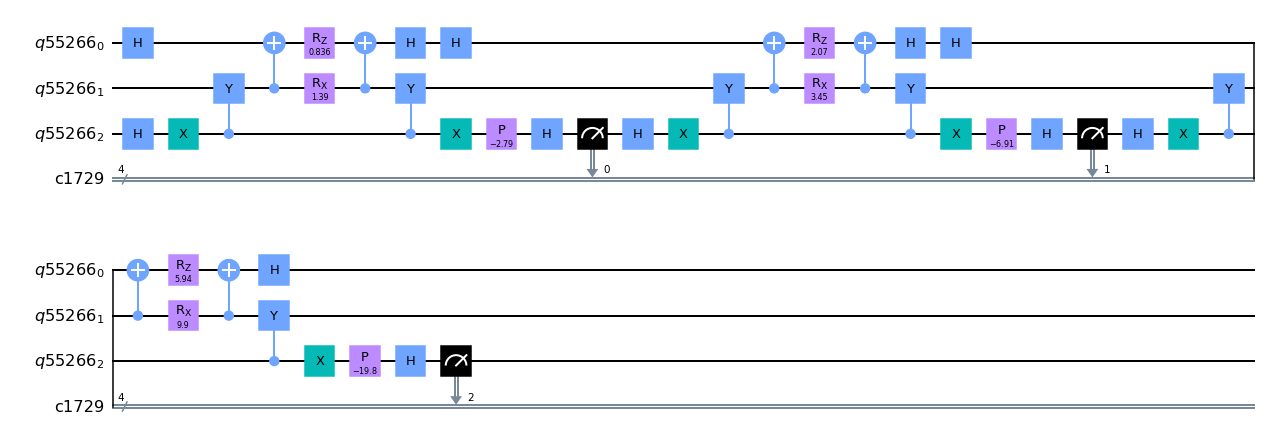

In [18]:
refactorTrial = identify_peaks(2.5, 1.5, 3, [11, 11, 11], 25, backend=backendQASM)
print(refactorTrial)

In [19]:
temp = list()
for i in range(len(refactorTrial[2])):
    temp.append([refactorTrial[4][i], refactorTrial[3][i]])
print(temp)

temp2 = list()
for i in range(len(refactorTrial[1])):
    temp2.append([refactorTrial[1][i], refactorTrial[0][i]])
print(temp2)

[[-4.25, 106.4], [-4.2, 120.56], [-4.15, 121.48], [-4.1, 127.44], [-4.05, 142.76]]
[[-4.5, 0.0], [-4.4, 82.0], [-4.3, 34.0], [-4.2, 60.0], [-4.1, 162.0], [-4.0, 450.0], [-3.9, 137.0], [-3.8, 11.0], [-3.7, 312.0], [-3.6, 104.0], [-3.5, 13.0], [-1.5, 107.0], [-1.4, 151.0], [-1.3, 153.0], [-1.2, 65.0], [-1.1, 203.0], [-1.0, 312.0], [-0.8999999999999999, 260.0], [-0.7999999999999999, 207.0], [-0.7, 46.0], [-0.6, 235.0], [-0.5, 1.0], [0.5, 0.0], [0.6, 213.0], [0.7, 97.0], [0.8, 40.0], [0.9, 255.0], [1.0, 241.0], [1.1, 153.0], [1.2000000000000002, 144.0], [1.3, 102.0], [1.4, 253.0], [1.5, 1.0], [3.5, 214.0], [3.6, 229.0], [3.7, 155.0], [3.8, 259.0], [3.9, 53.0], [4.0, 270.0], [4.1, 137.0], [4.2, 92.0], [4.3, 15.0], [4.4, 37.0], [4.5, 144.0]]


In [ ]:
scanNums = [11,11,11]
xMod = 2.5
zMod = 1.5
numCycles = 3
maxEigenvalue = 5 # replace this with an actual estimate from xMod and zMod
firstRunEnergies = np.linspace(-maxEigenvalue, maxEigenvalue, scanNums[0])
firstRunEnergies = firstRunEnergies.tolist()
firstStepSize = abs(firstRunEnergies[1]) - abs(firstRunEnergies[0])
print([firstRunEnergies])
firstPassCircuits = make_scan(xMod, zMod, numCycles, [firstRunEnergies], 2, 1)
firstPassCircuits[10].draw('mpl')

In [ ]:

# refactorRun2 = identify_peaks(prodXMod, prodZMod, 3, [11, 21, 21], 10, backend=backendCasablanca)
refactorRun2 = jobManager.retrieve_job_set('0a50aa415b37407abaf60474e516f83e-16420574305708077', provider)
# 41ead9adfb3748bd8001b1672674531b-16420571211654227
# cb3babe5f4df4294aa1448f160639762-1642057217872826
# 0a50aa415b37407abaf60474e516f83e-16420574305708077
print(refactorRun2)

first run job id: 41ead9adfb3748bd8001b1672674531b-16420571211654227
[-4.0, -1.0]
[-4.5, -4.45, -4.4, -4.35, -4.3, -4.25, -4.2, -4.15, -4.1, -4.05, -4.0, -3.95, -3.9, -3.85, -3.8, -3.75, -3.7, -3.65, -3.6, -3.55, -3.5, -1.5, -1.45, -1.4, -1.35, -1.3, -1.25, -1.2, -1.15, -1.1, -1.05, -1.0, -0.95, -0.8999999999999999, -0.85, -0.7999999999999999, -0.75, -0.7, -0.6499999999999999, -0.6, -0.5499999999999999, -0.5]
second run job id: cb3babe5f4df4294aa1448f160639762-1642057217872826
[-4.0, -3.7, -1.4, -0.95]
third run job id: 0a50aa415b37407abaf60474e516f83e-16420574305708077


first run job id: be33ba3e44c44ff7831a2f4c7affad6e-16429011161819072
[-4.0, -1.0, 1.0, 2.0, 4.0]
[-4.5, -4.45, -4.4, -4.35, -4.3, -4.25, -4.2, -4.15, -4.1, -4.05, -4.0, -3.95, -3.9, -3.85, -3.8, -3.75, -3.7, -3.65, -3.6, -3.55, -1.5, -1.45, -1.4, -1.35, -1.3, -1.25, -1.2, -1.15, -1.1, -1.05, -1.0, -0.95, -0.8999999999999999, -0.85, -0.7999999999999999, -0.75, -0.7, -0.6499999999999999, -0.6, -0.5499999999999999, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8500000000000001, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2000000000000002, 1.25, 1.3, 1.35, 1.4, 1.4500000000000002, 1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 3.5, 3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4.0, 4.05, 4.1, 4.15, 4.2, 4.25, 4.3, 4.35, 4.4, 4.45]
second run job id: 3ed9c832a55441e5bce8c144a16316f2-16429012330029085
[-4.0, -1.0, 1.0, 2.0, 4.0]
[[Model]]
    (((((Model(constant) + Model(gaussian, prefix='peak0_')) + Model(gaussian, prefix='peak1_')) + Mode

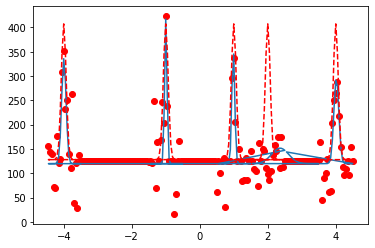

[[-3.9958333287825947, 0.00907329305362718], [-0.9973310025547153, 0.005166615049910483], [0.9865533013431972, 0.006632300073706314], [2.36288144326516, 0.12014826009916481], [4.016778672467781, 0.011732059244234075]]
third run job id: c27e298d3dbc4201a9569654ebf93e85-16429013992725527
[[Model]]
    (((((Model(constant) + Model(gaussian, prefix='peak0_')) + Model(gaussian, prefix='peak1_')) + Model(gaussian, prefix='peak2_')) + Model(gaussian, prefix='peak3_')) + Model(gaussian, prefix='peak4_'))
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 11252
    # data points      = 105
    # variables        = 16
    chi-square         = 90907.8371
    reduced chi-square = 1021.43637
    Akaike info crit   = 742.182320
    Bayesian info crit = 784.645686
[[Variables]]
    c:                117.262422 +/- 4.13544285 (3.53%) (init = 128)
    peak0_amplitude:  17.2289005 +/- 2.04872573 (11.89%) (init = 50)
    peak0_center:    -4.00298938 +/- 0.00375439 (0.09%) (i

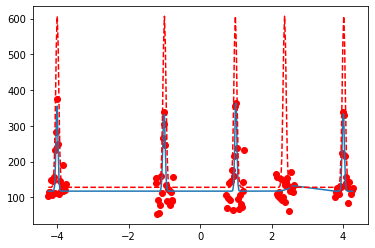

[[-4.002989384487659, 0.003754390905352323], [-1.0094609543664368, 0.004154139429118514], [0.9996706668049524, 0.0032434416315953976], [4.004137084355083, 0.003931329094864638]]
[[Model]]
    (Model(constant) + Model(gaussian, prefix='peak0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 8
    # variables        = 4
    chi-square         = 5699.41786
    reduced chi-square = 1424.85446
    Akaike info crit   = 60.5494222
    Bayesian info crit = 60.8671884
[[Variables]]
    c:                117.243578 +/- 32.4652760 (27.69%) (init = 128)
    peak0_amplitude:  17.3461151 +/- 5.22017409 (30.09%) (init = 50)
    peak0_center:    -3.98917452 +/- 0.00405174 (0.10%) (init = -4.002989)
    peak0_sigma:      0.02723987 +/- 0.00602075 (22.10%) (init = 0.04166667)
    peak0_fwhm:       0.06414499 +/- 0.01417777 (22.10%) == '2.3548200*peak0_sigma'
    peak0_height:     254.043026 +/- 37.0993830 (14.60%) == '0.3989423*peak0_amplitude/m

In [30]:
identifyPeaksTest = identify_peaks(2.5, 1.5, 3, [9, 21, 21], [1, 3, 10], backend=backendQASM)
print(identifyPeaksTest)

first run job id: cdb29782dcb94d7d84fa5a5fcb88fcf6-16428625766277957
[-4.0, -3.0, -1.0, 1.0, 4.0]
[-4.5, -4.45, -4.4, -4.35, -4.3, -4.25, -4.2, -4.15, -4.1, -4.05, -4.0, -3.95, -3.9, -3.85, -3.8, -3.75, -3.7, -3.65, -3.6, -3.55, -3.5, -3.45, -3.4, -3.35, -3.3, -3.25, -3.2, -3.15, -3.1, -3.05, -3.0, -2.95, -2.9, -2.85, -2.8, -2.75, -2.7, -2.65, -2.6, -2.55, -1.5, -1.45, -1.4, -1.35, -1.3, -1.25, -1.2, -1.15, -1.1, -1.05, -1.0, -0.95, -0.8999999999999999, -0.85, -0.7999999999999999, -0.75, -0.7, -0.6499999999999999, -0.6, -0.5499999999999999, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8500000000000001, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2000000000000002, 1.25, 1.3, 1.35, 1.4, 1.4500000000000002, 3.5, 3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4.0, 4.05, 4.1, 4.15, 4.2, 4.25, 4.3, 4.35, 4.4, 4.45]
second run job id: 14d0be33218b48fb8471148ae4670fab-16428631569513228
[-4.0, -3.0, -1.0, 1.0, 4.0]
[[Model]]
    (((((Model(constant) + Model(gaussian, prefix='peak0_')) + Model(gaussian, pr

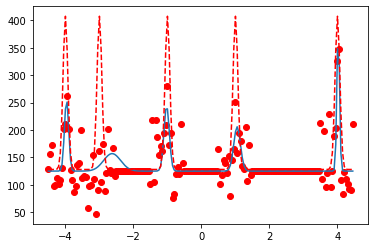

[[-3.9670173344632884, None], [-2.6271288842992973, None], [-1.0241187278556376, None], [1.0484976639273935, None], [4.021125381764786, None]]
third run job id: cd6d8166ff0d4884a49d87b03dc7c9ee-164286339686823
[[Model]]
    (((((Model(constant) + Model(gaussian, prefix='peak0_')) + Model(gaussian, prefix='peak1_')) + Model(gaussian, prefix='peak2_')) + Model(gaussian, prefix='peak3_')) + Model(gaussian, prefix='peak4_'))
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 9435
    # data points      = 105
    # variables        = 16
    chi-square         = 104640.285
    reduced chi-square = 1175.73354
    Akaike info crit   = 756.953971
    Bayesian info crit = 799.417337
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:                120.775742 +/- 3.59708619 (2.98%) (init = 128)
    peak0_amplitude:  20.0031399 +/- 0.06744112 (0.34%) (init = 50)
    peak0_center:    -3.99618871 +/- 0.00691475 (0.17%) (init = -3.967017)
    peak0_s

C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


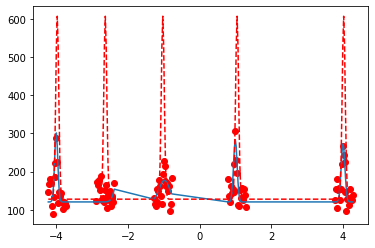

[[-3.9961887070782596, 0.006914748824815079], [-2.162823492371003, 0.5704566619062097], [-0.9793238642116483, 0.046717165322828165], [0.9991130470427836, 0.008158927816339404], [4.00279036834846, 0.0087738693233225]]
[[[-4.001394603621197, 0.0028610885621105134], [-0.9962225854928792, 0.0038340122486523035], [0.9994322395160189, 0.004714691446951064], [3.9867400114792555, 0.004126440199915574]], [[-3.9828395021771605, 0.00708597469137013], [-1.0000729847132983, 0.011964253091672417], [0.9996891256103783, 0.0068297514766171045], [3.9030212752819504, 0.0313531673580913]], array([139.6, 101.2, 131.3,  81.3, 138.2, 133.1,  89.9, 198.7, 201.1,
       381.3, 346. , 126.3,  99.5,  92.7, 105.5, 114.4, 181.6, 186.7,
       118.2, 133.6, 134.6,  92.5,  83.1,  96.8,  95.1, 110.6,  77.8,
       121.1,  97.8, 167.7, 282.6, 327.6, 321.4, 179.9, 134.5,  92.5,
       111.5,  86.6,  91.8, 164.7, 118.1, 107.9, 140.9,  97.8, 168.1,
       139.7, 155.9, 130.7,  97.2,  96.1, 222.2, 221.9, 330.5, 259.2,
   

In [17]:
quantumIDTest = identify_peaks(2.5, 1.5, 3, [9, 21, 21], [1, 3, 10], backend=backendJakarta)
print(quantumIDTest)

first run job id: cb94e8159de84e36970763d666562046-1642915308701706
[-3.35077608803911, -2.010465652823466, -0.6701552176078218, 2.0104656528234663, 3.35077608803911]
[-3.685853696843021, -3.6523459359626296, -3.6188381750822387, -3.585330414201848, -3.5518226533214565, -3.518314892441065, -3.4848071315606743, -3.4512993706802835, -3.417791609799892, -3.384283848919501, -3.35077608803911, -3.317268327158719, -3.283760566278328, -3.2502528053979365, -3.2167450445175456, -3.1832372836371547, -3.1497295227567634, -3.116221761876372, -3.0827140009959813, -3.0492062401155904, -2.345543261627377, -2.312035500746986, -2.2785277398665946, -2.2450199789862033, -2.2115122181058124, -2.1780044572254216, -2.1444966963450303, -2.110988935464639, -2.077481174584248, -2.043973413703857, -2.010465652823466, -1.9769578919430748, -1.9434501310626837, -1.9099423701822926, -1.8764346093019015, -1.8429268484215104, -1.8094190875411194, -1.7759113266607283, -1.7424035657803372, -1.708895804899946, -1.005232

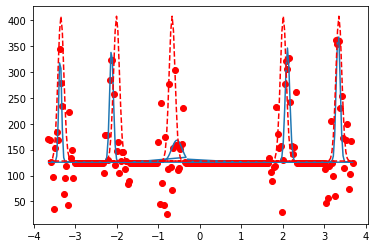

[[-3.3695080057374076, 0.0063118246439097195, 0.03407889237077141], [-2.131468465118699, 0.0069511601700594245, 0.045300585173210395], [-0.5538019054844723, 0.0689355951761435, 0.12622037110956816], [2.111757014588731, 0.007805037166986861, 0.05474056784438189], [3.334521004447259, 0.007149238578243146, 0.047467087010989825]]
third run job id: 68a91cfa59474023a444feb0e1d0f777-1642915708842905
[[Model]]
    (((((Model(constant) + Model(gaussian, prefix='peak0_')) + Model(gaussian, prefix='peak1_')) + Model(gaussian, prefix='peak2_')) + Model(gaussian, prefix='peak3_')) + Model(gaussian, prefix='peak4_'))
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 9382
    # data points      = 105
    # variables        = 16
    chi-square         = 15362.2749
    reduced chi-square = 172.609831
    Akaike info crit   = 555.499524
    Bayesian info crit = 597.962890
[[Variables]]
    c:                113.742704 +/- 2.48484321 (2.18%) (init = 128)
    peak0_amplitude

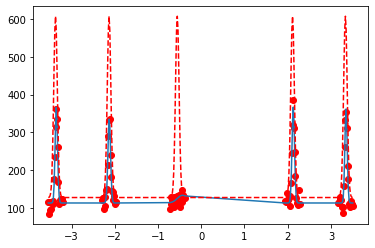

[[-3.35102669669772, 0.0012133777828250848, 0.028469975772955625], [-2.127172256868104, 0.0014064840554403467, 0.03051776146921932], [-0.43468001544852386, 0.15069095860409742, 0.11658043731591518], [2.128911592917163, 0.0012164613267979774, 0.029068184914694317], [3.348790990462398, 0.0012000844671424505, 0.027257959974837084]]
[[Model]]
    (Model(constant) + Model(gaussian, prefix='peak0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 8
    # variables        = 4
    chi-square         = 327.334435
    reduced chi-square = 81.8336087
    Akaike info crit   = 37.6923267
    Bayesian info crit = 38.0100929
[[Variables]]
    c:                116.776277 +/- 30.3519213 (25.99%) (init = 128)
    peak0_amplitude:  18.1478449 +/- 4.22503136 (23.28%) (init = 50)
    peak0_center:    -3.35452476 +/- 8.9207e-04 (0.03%) (init = -3.351027)
    peak0_sigma:      0.02951992 +/- 0.00356013 (12.06%) (init = 0.04166667)
    peak0_fwhm:    

In [69]:
prodTest = identify_peaks(prodXMod, prodZMod, 3, [11, 21, 21], [1, 3, 50], backend=backendQASM)
print(prodTest)

first run job id: 4e8caa0b10f34edf81e3ad806096dff0-16429838313760266
[-3.35077608803911, -2.2338507253594067, -1.675388044019555, -0.5584626813398517, 0.5584626813398517, 3.35077608803911]
[-3.630007428709036, -3.6020842946420433, -3.5741611605750507, -3.546238026508058, -3.5183148924410657, -3.4903917583740727, -3.46246862430708, -3.4345454902400876, -3.406622356173095, -3.3786992221061025, -3.35077608803911, -3.3228529539721174, -3.294929819905125, -3.2670066858381324, -3.23908355177114, -3.2111604177041473, -3.1832372836371543, -3.1553141495701618, -3.1273910155031692, -3.0994678814361767, -2.5130820660293325, -2.48515893196234, -2.4572357978953474, -2.429312663828355, -2.4013895297613623, -2.3734663956943693, -2.345543261627377, -2.3176201275603843, -2.2896969934933917, -2.261773859426399, -2.2338507253594067, -2.205927591292414, -2.1780044572254216, -2.150081323158429, -2.1221581890914365, -2.094235055024444, -2.066311920957451, -2.0383887868904584, -2.010465652823466, -1.98254251

C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\.conda\envs\pythonProject\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


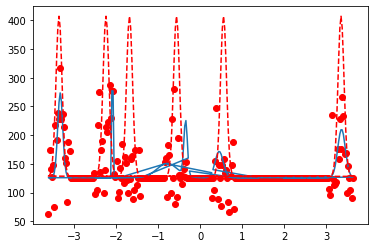

[[-3.3213567867466223, 0.010743124055170814, 0.059487044721936166], [-2.080276824041904, 0.00033455475326205254, 0.005390496077167378], [-0.34171889972630454, 0.027933892984883232, 0.04165869149373003], [0.45571789808909574, 0.1086095083243357, 0.0966357689031836], [3.3634012427200104, 0.026262639322027513, 0.09046008079087085]]
third run job id: 7bef850ca1c74932a5eb296b29e0470f-16429842080769396
[[Model]]
    (((((Model(constant) + Model(gaussian, prefix='peak0_')) + Model(gaussian, prefix='peak1_')) + Model(gaussian, prefix='peak2_')) + Model(gaussian, prefix='peak3_')) + Model(gaussian, prefix='peak4_'))
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 9885
    # data points      = 125
    # variables        = 16
    chi-square         = 71527.6197
    reduced chi-square = 656.216695
    Akaike info crit   = 825.690651
    Bayesian info crit = 870.943671
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:                139.430944 

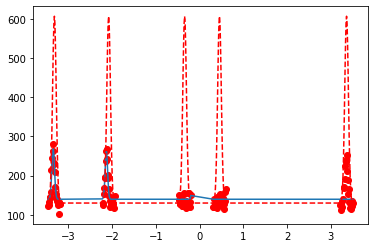

[[-3.3492987185765166, None, 0.030804107267724895], [-2.132114164043174, None, 0.02798440565675657], [0.04633103604625069, None, 0.047513913073598646], [-0.18913277039927542, None, 0.004227164986377277]]
[[Model]]
    (Model(constant) + Model(gaussian, prefix='peak0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 106
    # data points      = 8
    # variables        = 4
    chi-square         = 730.051614
    reduced chi-square = 182.512903
    Akaike info crit   = 44.1093896
    Bayesian info crit = 44.4271557
[[Variables]]
    c:                175.079476 +/- 67.5189185 (38.56%) (init = 128)
    peak0_amplitude:  5.83333333 +/- 0.03759386 (0.64%) (init = 50)
    peak0_center:    -3.34057833 +/- 0.00270792 (0.08%) (init = -3.349299)
    peak0_sigma:      0.02388616 +/- 0.01417940 (59.36%) (init = 0.04166667)
    peak0_fwhm:       0.05624762 +/- 0.03338994 (59.36%) == '2.3548200*peak0_sigma'
    peak0_height:     97.4272550 +/- 58.4556228 (60.00%) == '0

In [98]:
# 4e8caa0b10f34edf81e3ad806096dff0-16429838313760266
# 2a51183ebcd4482fb7f40875596fe8c2-16429838750533879
# 7bef850ca1c74932a5eb296b29e0470f-16429842080769396
# quantProdTest = identify_peaks(prodXMod, prodZMod, 3, [13, 21, 25], [1, 3, 40], backend=backendCasablanca)
quantProdTest = jobManager.retrieve_job_set('7bef850ca1c74932a5eb296b29e0470f-16429842080769396', provider)
print(quantProdTest)

In [97]:
print(find_final_final_peaks(quantProdTest[3], quantProdTest[2], [[3.40000118], [-2.1], [2.13], [3.33]], 125, 12, 3))

[[Model]]
    (Model(constant) + Model(gaussian, prefix='peak0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 242
    # data points      = 6
    # variables        = 4
    chi-square         = 66.9979897
    reduced chi-square = 33.4989948
    Akaike info crit   = 22.4774189
    Bayesian info crit = 21.6444567
[[Variables]]
    c:                116.364615 +/- 19.7130807 (16.94%) (init = 125)
    peak0_amplitude:  299.999930 +/- 5492.93375 (1830.98%) (init = 50)
    peak0_center:     3.56090835 +/- 0.68720292 (19.30%) (init = 3.400001)
    peak0_sigma:      0.05440278 +/- 0.13904239 (255.58%) (init = 0.04166667)
    peak0_fwhm:       0.12810877 +/- 0.32741980 (255.58%) == '2.3548200*peak0_sigma'
    peak0_height:     2199.93632 +/- 34667.5228 (1575.84%) == '0.3989423*peak0_amplitude/max(1e-15, peak0_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(peak0_amplitude, peak0_center) = 1.000
    C(peak0_center, peak0_sigma)     = 0.999
  

In [ ]:
# not used. Energy expectation ended up not working for theoretical and practical reasons

def get_spins(results, state, numShots):
    topExpect = 0
    botExpect = 0
    countsLower = list()
    countsUpper = list()
    totals = list()
    #first index is upper, second is lower
    # 0 for upper and lower, 0 for upper 1 for lower, 1 for upper 0 for lower, 1 for upper 1 for lower
    states = [state, '01' + state[2:], '10' + state[2:], '11' + state[2:]]

    for i in range(numShots):
        temp = deNone(results.get_counts(i).get(states[0]))
        temp = temp + deNone(results.get_counts(i).get(states[1]))
        temp = temp + deNone(results.get_counts(i).get(states[2]))
        temp = temp + deNone(results.get_counts(i).get(states[3]))
        totals.append(temp)

    for i in range(numShots):
        # append all top down. (00000) (top down, bot down) and (01000) (top down, bot up)
        countsLower.append((deNone(results.get_counts(i).get(state)) + deNone(results.get_counts(i).get(states[1]))) / totals[i])
        # append all bot down (00000) (top down, bot down) and (10000) (top up, bot down)
        countsUpper.append((deNone(results.get_counts(i).get(state)) + deNone(results.get_counts(i).get(states[2]))) / totals[i])

    for upperCount, lowerCount in zip(countsUpper, countsLower):
        topExpect = topExpect + upperCount * -0.5 + (1 - upperCount) * 0.5
        botExpect = botExpect + lowerCount * -0.5 + (1 - lowerCount) * 0.5

    topExpect = topExpect / (1 * numShots)
    botExpect = botExpect / (1 * numShots)

    return [topExpect, botExpect]

In [28]:
zztest = list()
xxtest = list()
for i in range(100):
    zztest.append(run_rodeo(make_good_times(12, 3, 12/5, 12*3), 3, 4, 2.5, 1.5, measurements="zz"))
    xxtest.append(run_rodeo(make_good_times(12, 3, 12/5, 12*3), 3, 4, 2.5, 1.5, measurements="zz"))

zztest = transpile(zztest, backend=backendQASM)
zzjob = jobManager.run(zztest, backend=backendQASM, shots=1024)
zzresults = zzjob.results()

xxtest = transpile(xxtest, backend=backendQASM)
xxjob = jobManager.run(xxtest, backend=backendQASM, shots=1024)
xxresults = xxjob.results()

zSpins = get_spins(zzresults, "00000", 100)
print(zSpins)
zTop = zSpins[0]
zBot = zSpins[1]

xSpins = get_spins(xxresults, "00000", 100)
print(xSpins)
xTop = xSpins[0]
xBot = xSpins[1]

print(2.5 * zBot * xTop + 1.5 * xBot * zTop)

[-0.013683524212967755, -0.048599811695886556]
[-0.0011913473058041118, -0.00949400338152795]
0.0003396152745399072


In [30]:
# not used. Energy expectation ended up not working for theoretical and practical reasons
def calculate_average_expectation(xResults, zResults, xMod, zMod):
    xMemory = list()
    zMemory = list()
    for i in range(100):
        for (xMem, zMem) in zip(xResults.get_memory(i), zResults.get_memory(i)):
            xMemory.append(xMem)
            zMemory.append(zMem)

    totalEnergy = 0
    for i in range(len(xMemory)):
        if xMemory[i][0] == xMemory[i][1]:
            totalEnergy += xMod
        else:
            totalEnergy -= xMod

        if zMemory[i][0] == zMemory[i][1]:
            totalEnergy += zMod
        else:
            totalEnergy -= zMod


        # totalEnergy += int(list(xMemory[i])[0]) * int(list(xMemory[i])[1]) * xMod
        # totalEnergy += int(list(zMemory[i])[0]) * int(list(zMemory[i])[1]) * zMod
    return totalEnergy/(1024 * 100)

def calculate_average_expectation_success(xResults, zResults, xMod, zMod):
    xMemory = list()
    zMemory = list()
    for i in range(100):
        for (xMem, zMem) in zip(xResults.get_memory(i), zResults.get_memory(i)):
            xMemory.append(xMem)
            zMemory.append(zMem)

    totalX = 0
    totalZ = 0
    zSuccess = 1024*100
    xSuccess = 1024*100
    for i in range(len(xMemory)):
        if xMemory[i] == "11" or xMemory[i] == "00":
            totalX += xMod
        # elif xMemory[i][-9:] == "000"*3:
        #     totalX -= xMod
        if zMemory[i] == "11" or zMemory[i] == "00":
            totalZ += zMod
        # elif zMemory[i][-9:] == "000"*3:
        #     totalZ -= zMod

    # for i in range(len(xMemory)):
    #     if xMemory[i][-9:] == "000"*3:
    #         xSuccess += 1
    #     if zMemory[i][-9:] == "000"*3:
    #         zSuccess += 1

    return totalX / xSuccess + totalZ / zSuccess

def count_ones(xResults, zResults, xMod, zMod):
    xMemory = list()
    zMemory = list()
    for i in range(100):
        for (xMem, zMem) in zip(xResults.get_memory(i), zResults.get_memory(i)):
            xMemory.append(xMem)
            zMemory.append(zMem)

    total1 = 0
    for i in range(len(xMemory)):
        if xMemory[i] == "11000" or zMemory[i] == "11000":
            total1 += 1

    return total1


def get_spin_expect(result):
    total1Down = 0
    total2Down = 0
    for i in range(100):
        total1Down += deNone(result.get_counts(i).get("00000")) + deNone(result.get_counts(i).get("01000"))
        total2Down += deNone(result.get_counts(i).get("00000")) + deNone(result.get_counts(i).get("10000"))
    return [total1Down / 1, total2Down / 1]

def get_num_successes(result):
    totalCounts = 0
    for i in range(100):
        counts = result.get_counts(i)
        totalCounts += deNone(counts.get("00000")) + deNone(counts.get("10000")) + deNone(counts.get("01000")) + deNone(counts.get("11000"))
    return totalCounts

def calculate_expectation(spins, expect):
    expect1 = spins[0] / expect * -0.5 + (1 - spins[0]) / expect * 0.5
    expect2 = spins[1] / expect * -0.5 + (1 - spins[1]) / expect * 0.5
    return [expect1, expect2]

def calculate_energy(expect, xMod, zMod):
    return expect[1][0] * expect[0][1] * xMod + expect[0][0] * expect[1][1] * zMod

In [28]:
xCircs = list()
for i in range(100):
    xCircs.append(run_rodeo(make_good_times(12, 3, 12/5, 36), 3, 4, 2.5, 1.5, measurements="xz"))

xCircs = transpile(xCircs, backend=backendJakarta)
xJob = jobManager.run(xCircs, backend=backendJakarta, shots=1024, memory=True)


zCircs = list()
for i in range(100):
    zCircs.append(run_rodeo(make_good_times(12, 3, 12/5, 36), 3, 4, 2.5, 1.5, measurements="zx"))

zCircs = transpile(zCircs, backend=backendJakarta)
zJob = jobManager.run(zCircs, backend=backendJakarta, shots=1024, memory=True)

expect = calculate_average_expectation(xJob.results(), zJob.results(), 2.5, 1.5)
backwards = calculate_average_expectation(xJob.results(), zJob.results(), 1.5, 2.5)
print(expect, backwards)

0.9121923828125 0.8923779296875


In [33]:
xCircs = list()
for i in range(100):
    xCircs.append(run_rodeo(make_good_times(12, 3, 12/5, 36), 0, 4, 2.5, 1.5, measurements="xz"))

xCircs = transpile(xCircs, backend=backendQASM)
xJob = jobManager.run(xCircs, backend=backendQASM, shots=1024, memory=True)


zCircs = list()
for i in range(100):
    zCircs.append(run_rodeo(make_good_times(12, 3, 12/5, 36), 0, 4, 2.5, 1.5, measurements="zx"))

zCircs = transpile(zCircs, backend=backendQASM)
zJob = jobManager.run(zCircs, backend=backendQASM, shots=1024, memory=True)

successesOnly = calculate_average_expectation_success(xJob.results(), zJob.results(), 2.5, 1.5)
negativePositive = calculate_average_expectation(xJob.results(), zJob.results(), 2.5, 1.5)
print(successesOnly, negativePositive)


2.0055126953125 0.011025390625


In [31]:
test = get_simple_overlap(3, [-4, -1, 1, 4], 2.5, 1.5, 100, backend=backendPerth)
print(test)

print("qasm test")
test = get_simple_overlap(3, [-4, -1, 1, 4], 2.5, 1.5, 100, backend=backendQASM)
print(test)

overlapJob job id: 09bc5875829a43318badac70c577e1b2-16442187103419986
[308.66]
overlapJob job id: fedbc5ec6284411986119d7335e3e606-16442187698416815
[329.19]
overlapJob job id: ef7e6b94f26e4a15ba617a484c85689f-16442188186836429
[317.06]
overlapJob job id: b1516198723345a8a8dc5d0ad7f8aa92-16442188812564478
[310.83]
[array([316., 336., 335., 296., 278., 285., 237., 224., 319., 273., 351.,
       343., 238., 241., 260., 214., 340., 259., 221., 351., 377., 330.,
       226., 293., 451., 305., 315., 357., 225., 255., 187., 277., 362.,
       477., 282., 204., 411., 492., 254., 227., 454., 522., 217., 232.,
       280., 368., 280., 551., 567., 254., 299., 263., 320., 307., 263.,
       246., 316., 405., 259., 338., 304., 241., 501., 248., 377., 249.,
       352., 385., 317., 249., 331., 292., 237., 280., 416., 330., 305.,
       200., 202., 411., 282., 386., 395., 200., 364., 264., 244., 183.,
       368., 248., 311., 355., 201., 241., 356., 260., 231., 294., 413.,
       278.]), array([226.

In [32]:
test1 = get_simple_overlap(1, [-4, -1, 1, 4], 2.5, 1.5, 100, backend=backendPerth)
print(test1)
test2 = get_simple_overlap(2, [-4, -1, 1, 4], 2.5, 1.5, 100, backend=backendPerth)
print(test2)
test3 = get_simple_overlap(3, [-4, -1, 1, 4], 2.5, 1.5, 100, backend=backendPerth)
print(test3)
test4 = get_simple_overlap(4, [-4, -1, 1, 4], 2.5, 1.5, 100, backend=backendPerth)
print(test4)
test5 = get_simple_overlap(5, [-4, -1, 1, 4], 2.5, 1.5, 100, backend=backendPerth)
print(test5)
test6 = get_simple_overlap(6, [-4, -1, 1, 4], 2.5, 1.5, 100, backend=backendPerth)

overlapJob job id: 082682ce65af459b92e72fa5a73bd396-16442191283784332
[660.3]
overlapJob job id: d2a064b5cac941caaf0563311e81a1d1-164421918766526
[650.16]
overlapJob job id: acccd37b2749413c9d8084cf2e46c491-1644219236677832
[644.78]
overlapJob job id: 6c490ae3db8447969c62ce3048bbd38d-16442192765777204
[638.33]
[array([714., 670., 797., 574., 650., 414., 878., 670., 542., 790., 576.,
       615., 573., 697., 512., 704., 512., 668., 546., 469., 697., 581.,
       588., 514., 544., 912., 868., 909., 857., 488., 918., 649., 461.,
       613., 550., 553., 528., 524., 565., 564., 513., 944., 692., 634.,
       874., 843., 556., 777., 900., 897., 593., 837., 595., 725., 423.,
       414., 789., 837., 686., 957., 739., 518., 529., 908., 729., 845.,
       711., 691., 551., 707., 562., 493., 681., 743., 849., 595., 875.,
       613., 513., 872., 623., 874., 540., 674., 649., 556., 573., 452.,
       544., 639., 557., 623., 477., 569., 753., 803., 727., 774., 520.,
       439.]), array([636., 55

NameError: name 'test7' is not defined

In [33]:
print(test6)

[array([159., 171., 166., 160., 168., 160., 156., 158., 186., 145., 169.,
       140., 190., 138., 184., 181., 138., 179., 182., 137., 163., 183.,
       215., 199., 147., 257., 146., 133., 146., 175., 153., 170., 290.,
       145., 162., 171., 187., 169., 215., 161., 152., 172., 148., 182.,
       130., 192., 156., 144., 153., 186., 196., 207., 176., 250., 208.,
       182., 144., 133., 168., 196., 141., 172., 206., 136., 162., 218.,
       152., 161., 229., 144., 196., 119., 186., 139., 161., 183., 161.,
       169., 174., 177., 175., 164., 161., 164., 173., 157., 157., 176.,
       159., 133., 182., 150., 178., 321., 161., 154., 159., 155., 152.,
       138.]), array([175., 171., 144., 176., 157., 163., 176., 151., 134., 125., 173.,
       198., 199., 204., 142., 169., 165., 183., 159., 188., 213., 173.,
       169., 192., 214., 225., 157., 176., 193., 189., 134., 169., 155.,
       148., 161., 141., 205., 166., 188., 172., 178., 179., 180., 144.,
       180., 219., 198., 149., 177.

In [37]:
averageCounts = list()
for i in range(6):
    temp = get_simple_overlap(i+1, [-4, -1, 1, 4], 2.5, 1.5, 1000, backend=backendPerth)
    print(temp)
    averageCounts.append(temp)

overlapJob job id: 32ae481bb40447a6b313000d4c70e202-16442459138082438
[628.61]
overlapJob job id: d42ff88e9efb4489b2aa7093b9b40580-16442464162779047
[635.941]
overlapJob job id: 99350f6e897041c78a34f400ff164759-164424770723167
[629.995]
overlapJob job id: 8e055c8ce4734666a15bda66e809e019-16442485383635032
[632.593]
[array([628.61]), array([635.941]), array([629.995]), array([632.593])]
overlapJob job id: dda9c23764514721915cc0307d546cbb-1644249007341152
[415.317]
overlapJob job id: 8b5e7b4524014ed2b4ec7bb47f210c08-1644249493811442
[425.337]
overlapJob job id: 46c78ec63e7d48d994d929044745ad53-16442499547754505
[423.849]
overlapJob job id: a62925a308514619a73df078be1d5a9a-16442504247919877
[428.525]
[array([415.317]), array([425.337]), array([423.849]), array([428.525])]
overlapJob job id: 4f34f27e923a4bbda2bdf8085e62d413-16442509600433106
[305.994]
overlapJob job id: a81d3e65e05443279deb26bb70ac0946-1644251447229955
[311.685]
overlapJob job id: d6bfb7de64484ab3ae926d868f172b08-164425193

In [ ]:
#TODO: randomize eigenvalue order
baseEnergies = [-4, -1, 1, 4]
averageCountsRandom = list()
for i in range(4):
    print(str(i+3) + " cycle energies: ")
    random.shuffle(baseEnergies)
    print(baseEnergies)
    temp = get_simple_overlap(i+2, baseEnergies, 2.5, 1.5, 1000, backend=backendPerth)
    print("counts: ", temp)
    averageCountsRandom.append([baseEnergies, temp])

3 cycle energies: 
[4, -1, -4, 1]
4 overlapJob job id: d68bdb939874471ea21ced32fb06d79f-1644392124464922
433.49
-1 overlapJob job id: 7970387bf2ca4f10a479d0db6f9382bc-16443925205085003
422.733
-4 overlapJob job id: 2d3e177a7d6d4e4a9860c8e96a062574-164439294992352
408.542
1 overlapJob job id: cbe0b81bad2444c1a48fb87929c87b0d-16443934088362153
425.947
counts:  [433.49, 422.733, 408.542, 425.947]
4 cycle energies: 
[-1, 1, -4, 4]
-1 overlapJob job id: 29ae0ea12cbf4338b78d3a84ac69cbbe-16443938788403637
299.514
1 overlapJob job id: 8f998f8f4e2c404e82d79cb7f3b852dd-16443943515618567
307.218
-4 overlapJob job id: e23fca51fd5a4759aaab7cac1031002e-16443948211922581
276.135
4 overlapJob job id: f152ff695a2842879968323bb3b4cd93-16443954542770507
305.905
counts:  [299.514, 307.218, 276.135, 305.905]
5 cycle energies: 
[-4, 1, 4, -1]
-4 overlapJob job id: ef3772bfd363407ca2fa63e0fb7dc13d-16443959342038949
211.252
1 overlapJob job id: 927776f5d5ec4604be77da2f0714c925-16443963933514037
236.114
4 over

In [ ]:
averageCountsInverse = list()
for i in range(6):
    print(str(i+1) + " cycle energies: ")
    temp = get_simple_overlap(i+1, [-4, -1, 1, 4], 2.5, 1.5, 1000, backend=backendPerth)
    print("counts: ", temp)
    averageCountsInverse.append(temp)

In [5]:
highRedundacyIDs = ["f4a277f072564f55a0830eb08fad5f36-16444287004715824", "4ea6d2949cfd4361bece6762df949e26-16444288810868614", "00a5f02aa95b4df59fb324051048efa6-16444298577281668"]
highRedundancyPeaks = identify_peaks(2.5, 1.5, 3, [9, 21, 41], [33, 12, 40], jobIDs = highRedundacyIDs, backend=backendPerth)
print(highRedundancyPeaks["secondDual"])

first run job id: f4a277f072564f55a0830eb08fad5f36-16444287004715824
[[281.8787878787879, 132.87878787878788, 114.72727272727273, 286.6969696969697, 139.8181818181818, 307.8181818181818, 113.78787878787878, 150.4848484848485, 318.93939393939394]]
[[-4.0, -1.0, 1.0, 4.0]]
second run job id: 4ea6d2949cfd4361bece6762df949e26-16444288810868614
[[-4.5, -4.45, -4.4, -4.35, -4.3, -4.25, -4.2, -4.15, -4.1, -4.05, -4.0, -3.95, -3.9, -3.85, -3.8, -3.75, -3.7, -3.65, -3.6, -3.55, -1.5, -1.45, -1.4, -1.35, -1.3, -1.25, -1.2, -1.15, -1.1, -1.05, -1.0, -0.95, -0.8999999999999999, -0.85, -0.7999999999999999, -0.75, -0.7, -0.6499999999999999, -0.6, -0.5499999999999999, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8500000000000001, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2000000000000002, 1.25, 1.3, 1.35, 1.4, 1.4500000000000002, 3.5, 3.55, 3.6, 3.65, 3.7, 3.75, 3.8, 3.85, 3.9, 3.95, 4.0, 4.05, 4.1, 4.15, 4.2, 4.25, 4.3, 4.35, 4.4, 4.45]]
[[[-3.973644398682776, 0.0035777814165631676, 0.047827272267069926], [-0.9

In [7]:
for energy, count in zip(highRedundancyPeaks["secondDual"][0][0], highRedundancyPeaks["secondDual"][1][0]):
    print(energy, count)

150.5 -4.5
133.33333333333334 -4.45
122.66666666666667 -4.4
192.08333333333334 -4.35
113.0 -4.3
127.0 -4.25
169.66666666666666 -4.2
71.33333333333333 -4.15
140.75 -4.1
197.33333333333334 -4.05
294.6666666666667 -4.0
320.5 -3.95
186.5 -3.9
116.08333333333333 -3.85
136.08333333333334 -3.8
125.75 -3.75
134.0 -3.7
111.08333333333333 -3.65
125.66666666666667 -3.6
157.41666666666666 -3.55
131.66666666666666 -1.5
130.75 -1.45
172.0 -1.4
101.33333333333333 -1.35
79.83333333333333 -1.3
95.58333333333333 -1.25
130.33333333333334 -1.2
103.58333333333333 -1.15
132.5 -1.1
192.75 -1.05
345.1666666666667 -1.0
276.9166666666667 -0.95
245.66666666666666 -0.8999999999999999
161.5 -0.85
160.25 -0.7999999999999999
146.5 -0.75
135.25 -0.7
148.0 -0.6499999999999999
124.33333333333333 -0.6
138.08333333333334 -0.5499999999999999
147.75 0.5
118.25 0.55
146.91666666666666 0.6
129.58333333333334 0.65
160.5 0.7
186.41666666666666 0.75
132.25 0.8
151.0 0.8500000000000001
117.58333333333333 0.9
240.08333333333334 0

In [32]:
IdentifiedPeaksAverageCounts = list()
for i in range(6):
    print(str(i+1) + " cycle: ")
    temp = get_simple_overlap(i+1, [-0.98745422, 4.00113417], 2.5, 1.5, 900, backend=backendPerth)
    print("counts: ", temp)
    IdentifiedPeaksAverageCounts.append(temp)

1 cycle: 
-0.98745422 overlapJob job id: 0e47b62fe12b4e128385a0845c59adf7-16444335537017455
636.1833333333333
4.00113417 overlapJob job id: b0b40c44f05c4ea3b99322e62c807b5d-16444338954678643
651.58
counts:  [636.1833333333333, 651.58]
2 cycle: 
-0.98745422 overlapJob job id: 49863b4106c6438aa39b29005fb379ac-16444343545482101
435.72222222222223
4.00113417 overlapJob job id: f0fc8243e5f2468f99d4e02b7b8987ad-16444349229708133
435.6911111111111
counts:  [435.72222222222223, 435.6911111111111]
3 cycle: 
-0.98745422 overlapJob job id: 83d62061218d4e08a1199960c2d0bd92-16444355503902552
319.71666666666664
4.00113417 overlapJob job id: 255dc07642d24b58b195f464defa06ce-16444361258235624
326.6988888888889
counts:  [319.71666666666664, 326.6988888888889]
4 cycle: 
-0.98745422 overlapJob job id: 1ea4606d98c8484982cd2e59c15ae660-1644436606357239
248.7
4.00113417 overlapJob job id: 25d17161bb9545ce87394c2fca7355ae-16444371605991004
247.8188888888889
counts:  [248.7, 247.8188888888889]
5 cycle: 
-0.98

In [37]:
for cycles in range(6):
    print(str(cycles+1) + " cycle: ")
    temp = get_simple_overlap(cycles+1, [-0.98745422], 2.5, 1.5, 900, twoStateEnergies=[-0.98745422, 4.00113417], backend=backendPerth)
    print("counts: ", temp)
    IdentifiedPeaksAverageCounts.append(temp)

1 cycle: 
-0.98745422 overlapJob job id: 6417261b351e43e99fe41f055ddce097-16444417821265469
731.8033333333333
counts:  [731.8033333333333]
2 cycle: 
-0.98745422 overlapJob job id: 045e49cf4ce54b07a203fe6d70694b7f-16444428156253407
590.0622222222222
counts:  [590.0622222222222]
3 cycle: 
-0.98745422 overlapJob job id: 046c2408abc646c5a4f6f2287b0f0325-16444436359117029
485.19666666666666
counts:  [485.19666666666666]
4 cycle: 
-0.98745422 overlapJob job id: 5e1fed54c938499e8b20c55e847dc56a-16444461346761763
443.55444444444447
counts:  [443.55444444444447]
5 cycle: 
-0.98745422 overlapJob job id: ed77de2b753a46efa43f760f86735456-1644446587836355
405.8
counts:  [405.8]
6 cycle: 
-0.98745422 overlapJob job id: b90c6e483ac542aeb538ed61b9502b9d-16444473655800338
376.7811111111111
counts:  [376.7811111111111]


In [29]:
sanityCheck = run_two_state(3, 3, np.linspace(0, 5, 25), 2.5, 1.5, -1, 4, "zz", backend=backendQASM)

two state job530754ed70d044cab8f15d222c5573d0-16446374024080663
[-0.8030592734225621, -0.4237918215613382, 0.6296296296296295, 0.9536679536679538, 0.4418604651162792, -0.6412825651302605, -1.1354359925788498, -0.556, 0.41886792452830185, 1.1434034416826004, 0.6003552397868561, -0.2350746268656716, -0.981060606060606, -0.6165137614678899, 0.3820662768031189, 0.959847036328872, 0.30616302186878736, -0.5763358778625955, -0.9725490196078432, -0.5540275049115914, 0.5606361829025845, 1.2047713717693835, 0.6309523809523809, -0.4061895551257253, -1.0648854961832064]
[-1.114173228346457, -0.5136186770428015, 0.43121149897330596, 0.930966469428008, 0.5029239766081872, -0.5691382765531061, -1.106382978723404, -0.4023210831721471, 0.379506641366224, 1.0875763747454175, 0.5963488843813387, -0.44874274661508695, -0.8935361216730038, -0.7613636363636362, 0.30916030534351147, 1.0180505415162453, 0.47272727272727266, -0.5486381322957199, -0.9711934156378601, -0.5755395683453237, 0.5887096774193548, 1.2

In [31]:
finerSanityCheck = run_two_state(3, 10, np.linspace(0, 5, 50), 2.5, 1.5, -1, 4, "zz", backend=backendQASM)

two state job1e36c9dbd6574ccf80e8eb8a2062486f-16446379935067265
[-0.8587570621468927, -0.66796875, -0.4189723320158101, 0.14770459081836324, 0.4929859719438877, 0.8576998050682263, 0.8913857677902621, 0.8621359223300971, 0.40625, 0.09126984126984139, -0.5764023210831721, -0.9503816793893128, -1.1505791505791505, -0.9917355371900827, -0.8085106382978722, -0.194059405940594, 0.41282565130260535, 0.7258687258687258, 1.100371747211896, 1.0266159695817492, 0.9005628517823641, 0.4107485604606526, -0.05999999999999989, -0.6551059730250481, -0.8930581613508444, -0.888030888030888, -0.781609195402299, -0.3742690058479532, -0.003929273084479323, 0.46875, 0.7879924953095685, 0.9203187250996017, 0.7443609022556392, 0.3567134268537074, -0.20272904483430798, -0.7065637065637065, -0.8793774319066148, -0.9770992366412212, -0.7538461538461538, -0.40074906367041185, 0.14872798434442275, 0.7054263565891472, 0.9552845528455285, 1.1728395061728394, 0.9688715953307394, 0.6187624750499001, 0.0980392156862746

In [40]:
# fullRun = run_two_state(3, 27, np.linspace(0, 10, 100), 2.5, 1.5, -0.98745422, 4.00113417, "zz", backend=backendCasablanca, jobID='4246e6d9d90843e9aa8dfd84cbf6b62a-16446390077529044')
fullRun = jobManager.retrieve_job_set('job4246e6d9d90843e9aa8dfd84cbf6b62a-16446390077529044', provider)
print(fullRun)

two state job4246e6d9d90843e9aa8dfd84cbf6b62a-16446390077529044
[-1.103448275862069, -0.8557457212713937, -0.5079365079365079, -0.08450704225352124, 0.34895833333333326, 0.8244274809160306, 0.8762376237623763, 0.9470752089136489, 0.7394540942928041, 0.3703703703703704, -0.18499999999999994, -0.34517766497461944, -0.6535626535626533, -0.8484848484848484, -0.6243654822335025, -0.272, 0.12345679012345673, 0.3659147869674186, 0.594315245478036, 0.6492146596858639, 0.5436893203883495, 0.19148936170212777, -0.1483375959079285, -0.7434052757793763, -0.827930174563591, -0.8563968668407309, -0.6048780487804878, -0.303030303030303, 0.2180094786729858, 0.548076923076923, 1.092783505154639, 1.1002570694087406, 0.8797953964194373, 0.6381909547738692, 0.09245742092457415, -0.34328358208955234, -0.7402298850574711, -0.8528678304239401, -0.9648241206030151, -0.7156398104265405, -0.4439024390243902, 0.03149606299212615, 0.4937027707808565, 0.6813725490196079, 0.6982543640897756, 0.6487804878048782, 0.2

In [41]:
perthRun = run_two_state(3, 30, np.linspace(0, 10, 100), 2.5, 1.5, -0.98745422, 4.00113417, "zz", backend=backendPerth)
print(perthRun)

two state job62d3acf6fa004f60b27cc240b0f648cf-16447076338807232
[-0.8558758314855877, -0.6697459584295612, -0.4129930394431556, 0.04444444444444451, 0.4229885057471264, 0.7614457831325301, 0.8883720930232557, 0.8752735229759299, 0.8240534521158129, 0.27659574468085113, -0.05764966740576494, -0.6071428571428572, -0.8845315904139435, -1.0657596371882085, -0.8893905191873588, -0.5115207373271888, -0.3153153153153152, 0.248868778280543, 0.7488986784140967, 0.9750566893424035, 0.8946135831381732, 0.6594827586206897, 0.3155452436194895, -0.027027027027026973, -0.4009324009324009, -0.7251184834123222, -0.6507592190889372, -0.5411255411255411, -0.12328767123287676, 0.191588785046729, 0.44954128440366975, 0.6285714285714286, 0.6866952789699572, 0.45833333333333326, 0.20785219399538118, -0.19501133786848057, -0.6904761904761905, -0.8775055679287307, -0.9030837004405285, -0.7940552016985138, -0.3721973094170403, 0.046838407494145085, 0.6069868995633186, 0.9475982532751093, 1.1159420289855073, 0.9

In [44]:
zxTest = run_two_state(3, 30, np.linspace(0, 10, 101), 2.5, 1.5, -0.98745422, 4.00113417, "zx", backend=backendPerth)

two state job93c6f34ef3914cf79b2af49c6b12be80-16447328141502523
[-1.782178217821782, -1.7411764705882353, -1.204878048780488, -0.44803695150115463, 0.49523809523809526, 1.0641330166270784, 1.537712895377129, 1.73621103117506, 1.3302752293577982, 0.6714975845410629, -0.22935779816513757, -1.0545454545454545, -1.5560747663551404, -1.7671232876712328, -1.515587529976019, -0.9739952718676123, -0.1785714285714286, 0.6411483253588517, 1.3564814814814814, 1.6683168316831685, 1.62877030162413, 1.2431192660550459, 0.39814814814814825, -0.5767441860465115, -1.289760348583878, -1.7603911980440095, -1.6926713947990542, -1.167420814479638, -0.5885057471264368, 0.16666666666666669, 1.0637254901960784, 1.673758865248227, 1.7339449541284402, 1.375, 0.8284313725490196, -0.13363028953229383, -0.9671361502347419, -1.5436893203883497, -1.7635467980295565, -1.563380281690141, -1.087557603686636, -0.2822966507177034, 0.6453089244851258, 1.3775743707093822, 1.6496350364963503, 1.6577017114914427, 1.164383561

In [43]:
print(np.linspace(0,10,101))

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10. ]


In [45]:
perthGoodTimes = run_two_state(3, 30, np.linspace(0, 10, 101), 2.5, 1.5, -0.98745422, 4.00113417, "zz", backend=backendPerth)
print(perthGoodTimes)

two state job9a3ac986eec9487da4a4a4d358e8e1aa-16447349254570699
[-0.592734225621415, -0.5976095617529881, -0.3896103896103895, 0.08677685950413228, 0.3544303797468355, 0.6231578947368421, 0.8278688524590163, 0.9365426695842449, 0.5403050108932461, 0.1186440677966103, -0.048458149779735615, -0.5726141078838174, -0.9075630252100838, -0.8622754491017963, -0.8079999999999998, -0.46696035242290734, -0.042553191489361764, 0.4282744282744281, 0.8401639344262295, 0.8932461873638344, 0.8275862068965516, 0.6285714285714286, 0.2555780933062881, -0.02183406113537112, -0.35564853556485354, -0.6512605042016807, -0.7154150197628458, -0.5258799171842652, -0.29769392033542985, 0.06299212598425208, 0.4132231404958678, 0.711018711018711, 0.5458248472505092, 0.490872210953347, 0.22641509433962276, -0.20858895705521463, -0.5902912621359224, -0.6824034334763949, -0.8040816326530613, -0.6892430278884463, -0.36904761904761896, 0.03711340206185576, 0.46610169491525416, 0.7957894736842105, 0.9958506224066389, 0

In [21]:
qasmSwapTimeEvolve = run_two_state(3, 3, np.linspace(0, 10, 101), 2.5, 1.5, -0.98745422, 4.00113417, "zz", backend=backendQASM)
print(qasmSwapTimeEvolve)

two state job4f2b66426bbf479e887cebb569b21651-1645634879351784
[0.6343283582089552, 0.5789473684210527, 0.1807909604519773, -0.18713450292397638, -0.5471698113207546, -0.7700729927007299, -0.8876811594202898, -0.6583184257602862, -0.39703153988868267, 0.058212058212058215, 0.6880907372400755, 1.1162790697674418, 1.332046332046332, 1.2771535580524345, 1.0425138632162663, 0.4361493123772102, -0.27118644067796605, -0.803960396039604, -1.3005464480874318, -1.3561904761904764, -1.2610441767068274, -0.8434622467771641, -0.4638783269961977, 0.158607350096712, 0.6398537477148079, 0.9111531190926276, 0.9028571428571428, 0.7567567567567568, 0.4232209737827715, 0.007434944237918073, -0.3333333333333334, -0.5625, -0.5333333333333333, -0.3102803738317757, 0.05850091407678243, 0.39852398523985233, 0.7323420074349443, 0.911439114391144, 0.7286245353159853, 0.5911504424778762, 0.13793103448275867, -0.4282982791586998, -0.9805447470817122, -1.2037037037037037, -1.3102189781021898, -1.0852173913043477, 

first run job id: d205a92c6561492d947b9bbb5f2f37dd-16478414206090186
[-4.0, -1.0, 1.0, 4.0]
[162.  250.2 153.4 177.2 281.6 102.6 304.2 103.6 129.  250.6  93.2]
[-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999999, -0.7, -0.6, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4]
second run job id: d603066ea70a440fb90a44d0918a1a09-16478458216059048


C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


[[Model]]
    ((((Model(constant) + Model(gaussian, prefix='peak0_')) + Model(gaussian, prefix='peak1_')) + Model(gaussian, prefix='peak2_')) + Model(gaussian, prefix='peak3_'))
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 5488
    # data points      = 110
    # variables        = 13
    chi-square         = 42694.7972
    reduced chi-square = 440.152549
    Akaike info crit   = 681.748718
    Bayesian info crit = 716.854963
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:                123.148865 +/- 2.11133534 (1.71%) (init = 128)
    peak0_amplitude:  29.6686933 +/- 4.26923761 (14.39%) (init = 50)
    peak0_center:    -3.96980892 +/- 0.01256954 (0.32%) (init = -4)
    peak0_sigma:      0.07682658 +/- 0.01248879 (16.26%) (init = 0.07142857)
    peak1_amplitude:  20.0753253 +/- 3.86182350 (19.24%) (init = 50)
    peak1_center:    -1.03590850 +/- 0.03032842 (2.93%) (init = -1)
    peak1_sigma:      0.04557233 +/- 0.04821347 (1

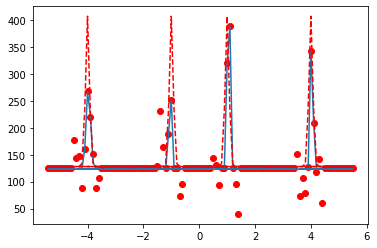

[[-3.9698089187896155, 0.012569543832796185, 0.07682657885790103], [-1.0359084950474207, 0.030328416919779094, 0.045572331026961635], [1.0512475291564272, nan, 0.020461999570336634], [4.046681037225451, nan, 0.01864886126521463]]
third run job id: 7bc15c9e83074745996877256e302a1b-16478532115534074


C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


[[Model]]
    ((((Model(constant) + Model(gaussian, prefix='peak0_')) + Model(gaussian, prefix='peak1_')) + Model(gaussian, prefix='peak2_')) + Model(gaussian, prefix='peak3_'))
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 6975
    # data points      = 88
    # variables        = 13
    chi-square         = 475714.993
    reduced chi-square = 6342.86657
    Akaike info crit   = 782.380890
    Bayesian info crit = 814.586269
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c:                105.104994 +/- 15.4571743 (14.71%) (init = 128)
    peak0_amplitude:  21.6617928 +/- 4.44529281 (20.52%) (init = 50)
    peak0_center:    -3.99552392 +/- 0.00813289 (0.20%) (init = -3.969809)
    peak0_sigma:      0.03782127 +/- 0.00735179 (19.44%) (init = 0.04166667)
    peak1_amplitude:  10.9821774 +/- 3.54407383 (32.27%) (init = 50)
    peak1_center:    -0.99945923 +/- 0.00597525 (0.60%) (init = -1.035908)
    peak1_sigma:      0.01688352 +/-

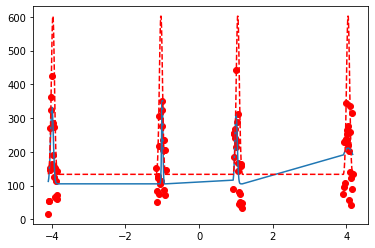

[[-3.995523917745147, 0.008132891100665875, 0.03782126785372626], [-0.9994592290823423, 0.005975250952278082, 0.01688351604312302], [1.0055694966414506, 0.009319723059882792, 0.032710043169143]]
[[Model]]
    (Model(constant) + Model(gaussian, prefix='peak0_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 184
    # data points      = 8
    # variables        = 4
    chi-square         = 63063.8969
    reduced chi-square = 15765.9742
    Akaike info crit   = 79.7796975
    Bayesian info crit = 80.0974637
[[Variables]]
    c:                258.028685 +/- 204.413694 (79.22%) (init = 128)
    peak0_amplitude:  5.83333333 +/- 430.272786 (7376.10%) (init = 50)
    peak0_center:    -3.93050323 +/- 2.66864588 (67.90%) (init = -3.995524)
    peak0_sigma:      0.03769521 +/- 1.16435981 (3088.88%) (init = 0.04166667)
    peak0_fwhm:       0.08876543 +/- 2.74185777 (3088.88%) == '2.3548200*peak0_sigma'
    peak0_height:     61.7363223 +/- 2673.81522 (4331.02%) == '

In [18]:
quantinuumRun = identify_peaks(2.5, 1.5, 3, [11, 11, 22], [5, 2, 1], maxEigenvalue = 5, scanWidths = [0.5, 0.125], backend = backendPerth)

In [19]:
print(quantinuumRun)

[[[-3.9305032318226707, 2.668645883799691], [-0.9953081910994503, 0.004806173017115744], [1.009021444976844, 0.0036874513263561413]], [[-3.9698089187896155, 0.012569543832796185, 0.07682657885790103], [-1.0359084950474207, 0.030328416919779094, 0.045572331026961635], [1.0512475291564272, nan, 0.020461999570336634], [4.046681037225451, nan, 0.01864886126521463]], array([ 16.,  53.,  55., 145., 152., 270., 323., 363., 165., 426., 191.,
       286., 154., 274., 125.,  65., 152., 115.,  62.,  72.,  60., 142.,
       152.,  51.,  84., 129., 123., 306.,  76., 217., 106., 114., 110.,
       115., 278., 352., 323., 236., 204., 236.,  87.,  73., 205., 145.,
        91., 257., 185., 254., 240., 268., 215., 442., 231., 288., 143.,
       311., 168.,  81.,  45.,  75.,  52.,  39., 164., 157.,  49.,  33.,
        76.,  95., 229., 232., 108., 344., 239., 234., 265., 253., 277.,
       219.,  57., 203., 141., 259., 335., 123.,  43., 314.,  90., 135.]), [-4.0948089187896155, -4.082904156884854, -4.0709

In [3]:
# quantinuumRunIDs = ['d205a92c6561492d947b9bbb5f2f37dd-16478414206090186', 'd603066ea70a440fb90a44d0918a1a09-16478458216059048', '7bc15c9e83074745996877256e302a1b-16478532115534074']
# quantinuumRunIDs = ['d205a92c6561492d947b9bbb5f2f37dd-16478414206090186', 'd603066ea70a440fb90a44d0918a1a09-16478458216059048', '24bea523dd184b3380f3bc4b0a15716b-16480113778964682']
quantinuumRunIDs = ['d205a92c6561492d947b9bbb5f2f37dd-16478414206090186', 'd603066ea70a440fb90a44d0918a1a09-16478458216059048', '797186127165467ea1e7ec072253203b-16484408538306303']
quantinuumRunRetrieval = identify_peaks(2.5, 1.5, 3, [11, 11, 22], [5, 2, 4], maxEigenvalue = 5, scanWidths = [0.5, 0.125], jobIDs = quantinuumRunIDs, backend = backendPerth)

first run job id: d205a92c6561492d947b9bbb5f2f37dd-16478414206090186
[[162.0, 250.2, 153.4, 177.2, 281.6, 102.6, 304.2, 103.6, 129.0, 250.6, 93.2]]
[[-4.0, -1.0, 1.0, 4.0]]
second run job id: d603066ea70a440fb90a44d0918a1a09-16478458216059048
[[-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999999, -0.7, -0.6, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4]]


C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


[[[-3.9699595954211793, 0.01271090133637225, 0.07361831300891797], [-1.0430873394170193, 0.15203873750450847, 0.031035320550017356], [1.0543693246160557, 0.024360100573570253, 0.03788498915925903], [4.046028615183631, nan, 0.020019419922006107]]]
third run job id: 797186127165467ea1e7ec072253203b-16484408538306303
4 88 88
[[[-3.986777856833487, 0.0037925662766943704, 0.034810047971715066], [-0.99677291219123, 0.002362519476289287, 0.029133462133115837], [1.0092781996655225, 0.003948157965760015, 0.035584655781134636], [4.0067172469700125, 0.006109791665183098, 0.03459213932097996]]]


In [7]:
for i, j in zip(quantinuumRunRetrieval["secondDual"][0][0],quantinuumRunRetrieval["secondDual"][1][0]):
    print(i, j)

177.0 -4.5
144.0 -4.4
147.5 -4.3
87.5 -4.2
160.5 -4.1
268.0 -4.0
220.5 -3.9
151.5 -3.8
88.5 -3.7
107.0 -3.6
128.5 -1.5
231.0 -1.4
164.5 -1.3
218.5 -1.2
188.5 -1.1
252.0 -1.0
401.0 -0.8999999999999999
140.5 -0.7999999999999999
74.0 -0.7
96.0 -0.6
144.0 0.5
130.0 0.6
94.0 0.7
89.0 0.8
138.0 0.9
320.5 1.0
389.0 1.1
109.0 1.2000000000000002
95.5 1.3
40.0 1.4
150.5 3.5
73.5 3.6
106.5 3.7
79.5 3.8
127.5 3.9
343.5 4.0
208.0 4.1
118.0 4.2
142.0 4.3
59.5 4.4


In [72]:
fourRunIDs = ["61bd8c84034e4ca08c9cbf8f423b0055-16486212922403014", "78fe1d645d4947b3bb8b981b099a2e53-16486239991218922", "8eff8da6f7524639867bbcf2d227d351-16486260382894452"]
fourRuns = identify_peaks(2.5, 1.5, 3, [11, 11, 22], [5, 2, 4], maxEigenvalue = 5, scanWidths = [0.5, 0.125],jobIDs = fourRunIDs, repetitions = 30, backend = backendPerth)
with open('Redundancy4.pickle', 'wb') as file:
    pickle.dump(fourRuns, file)

first run job id: 61bd8c84034e4ca08c9cbf8f423b0055-16486212922403014
[[131.0, 289.8, 78.8, 82.6, 287.2, 117.6, 313.6, 164.0, 89.8, 290.2, 77.2], [149.0, 372.8, 126.0, 128.4, 278.4, 85.4, 332.6, 188.4, 147.8, 285.0, 89.0], [142.4, 324.2, 100.2, 88.4, 276.0, 159.4, 289.6, 117.6, 118.0, 280.2, 138.4], [133.6, 317.4, 175.6, 125.2, 357.6, 118.0, 269.2, 145.6, 149.0, 333.8, 155.8], [135.8, 456.0, 95.4, 106.2, 314.0, 81.4, 315.0, 141.6, 206.2, 268.8, 211.4], [108.6, 246.6, 141.6, 119.6, 312.2, 170.2, 292.2, 152.4, 83.6, 297.2, 117.8], [174.6, 290.4, 110.6, 149.4, 331.0, 100.6, 295.6, 150.6, 125.2, 248.4, 129.4], [137.0, 353.8, 93.8, 83.2, 304.8, 233.0, 308.2, 135.8, 132.4, 237.4, 128.0], [132.2, 258.8, 142.0, 117.4, 280.2, 108.2, 290.4, 166.4, 113.6, 273.0, 109.6], [130.8, 265.8, 156.2, 132.4, 297.0, 120.8, 259.2, 113.0, 153.8, 293.6, 121.6], [128.6, 261.6, 133.4, 108.0, 297.0, 118.8, 282.2, 83.6, 109.6, 269.8, 138.8], [81.4, 262.6, 115.6, 111.6, 243.2, 228.0, 280.2, 118.2, 124.2, 281.2, 161.

C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:1

[[[-3.9582944278319827, 0.04747761622619327, 0.029070279363758222], [-1.0240531273376203, 0.29366110227831227, 0.03302841576268868], [1.0428835038938253, nan, 0.019156044230954766], [4.007467399598745, 0.02601255835223643, 0.11449488539048601]], [[-1.0358934390744632, nan, 0.012208827174076745], [1.0461828121793602, 0.02436412085766168, 0.019103112832514854], [4.04148065386092, 0.019322245162720474, 0.03328667333018556]], [[-4.012307726247075, 0.0013302255016812998, 0.0062218799794696855], [-1.0367279438094625, nan, 0.02964453218818805], [1.006649339502168, 0.06427179523556925, 0.04129407561200414], [3.9551318682375163, nan, 0.03245162297852934]], [[-4.007208587304573, 0.020998121615281185, 0.1398310259803215], [-0.9974086355553506, 1.1457102414391899e-05, 0.000767864273378327], [1.0170377777428015, 0.47143872558861705, 0.019500872824757695], [3.963188557872746, 0.20259083008555703, 0.03759390484209085]], [[-4.040564645084077, nan, 0.02437714016130965], [-1.0329780938297852, nan, 0.024

C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


4 88 88
4 88 88
4 88 88
4 88 88


C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


4 88 88
4 88 88
4 88 88
4 88 88
4 88 88
4 88 88
3 88 88
4 88 88
4 88 88
3 88 88


C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


5 88 88
[[[-3.9818147901539005, 0.0032669245270542865, 0.02799830005354567], [-1.0006513600573608, 0.005155625357352677, 0.0325907327489172], [1.0006723948299734, 0.002826559366869281, 0.020185421179292687], [3.9958824020801487, 0.005127048666661054, 0.02724235045682631]], [[-0.9842052136692192, 0.007241873663103385, 0.042227427951912005], [1.01561957656332, 0.002594444406373127, 0.02839230527546739], [4.001476534205488, 0.005936022598699664, 0.032217028278254345]], [[-3.985671765113727, None, 0.04164803443364505], [-0.9871682291144346, None, 0.04164803443364505], [1.0078297931467155, None, 0.04164803443364505], [3.9973806649255437, None, 0.04164803443364505]], [[-3.989769767014937, None, 0.04164803443364505], [-0.9940069409176555, None, 0.04164803443364505], [1.0075806090060584, None, 0.04164803443364505], [3.997851529020278, None, 0.04164803443364505]], [[-3.991709363980327, None, 0.04164803443364505], [-0.993186033914067, None, 0.04164803443364505], [1.0114351068493348, None, 0.0416

In [ ]:
threeRuns = identify_peaks(2.5, 1.5, 3, [11, 11, 22], [5, 2, 3], maxEigenvalue = 5, scanWidths = [0.5, 0.125], repetitions = 30, backend = backendPerth)
with open('Redundancy3.pickle', 'wb') as file:
    pickle.dump(threeRuns, file)

In [ ]:
twoRuns = identify_peaks(2.5, 1.5, 3, [11, 11, 22], [5, 2, 2], maxEigenvalue = 5, scanWidths = [0.5, 0.125], repetitions = 30, backend = backendPerth)
with open('Redundancy2.pickle', 'wb') as file:
    pickle.dump(twoRuns, file)

In [13]:
toRun = list()
firstRunEnergies = np.linspace(-5, 5, 11)
for i in range(3):
    toRun.append(make_scan(2.5, 1.5, 3, firstRunEnergies, 3))
toRun = flatten(toRun)

jobManager.run(transpile(toRun, backend=backendQASM), backend=backendQASM, name = "multi dimension test", shots=1024)

In [51]:
ids = ["474b518e041a477e8ce34eac7920e50e-16486186316017895", "571beb0c067d4f1f836d8e529ef98713-1648619610834415", "ef0147fce3284f53a8240a89c9624b46-1648620028051905"]
repetitionTest = identify_peaks(2.5, 1.5, 3, [11, 11, 22], [5, 2, 2], maxEigenvalue = 5, scanWidths = [0.5, 0.125], jobIDs = ids, repetitions = 5, backend = backendQASM)

first run job id: 474b518e041a477e8ce34eac7920e50e-16486186316017895
[[151.6, 344.8, 151.8, 160.4, 310.4, 191.0, 381.0, 93.8, 79.6, 332.4, 129.4], [52.8, 323.4, 176.8, 105.2, 336.2, 177.2, 321.6, 128.6, 57.4, 349.6, 181.4], [132.4, 379.8, 97.6, 117.0, 362.0, 93.6, 295.0, 97.6, 136.4, 321.2, 141.6], [126.0, 325.4, 145.4, 88.0, 338.0, 124.8, 429.0, 115.8, 93.8, 330.6, 112.6], [98.0, 310.2, 67.0, 137.6, 370.8, 101.2, 348.6, 84.0, 169.6, 349.8, 73.2]]
[[-4.0, -1.0, 1.0, 4.0], [-4.0, -1.0, 1.0, 4.0], [-4.0, -1.0, 1.0, 4.0], [-4.0, -1.0, 1.0, 4.0], [-4.0, -1.0, 1.0, 4.0]]
second run job id: 571beb0c067d4f1f836d8e529ef98713-1648619610834415
[[-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999999, -0.7, -0.6, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4], [-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -1.5, -1.4, -1.3, -1.2, -1.1,

C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:1

[[[-4.033060937303556, 0.08300907249078247, 0.032748792954563274], [-1.0104582010171925, nan, 0.007342646049794718], [1.0469654991954496, 0.05132487435398749, 0.026311085822920216], [3.9620332334122876, 0.05682778121594815, 0.035721443534612984]], [[-4.008934252681675, nan, 0.012405941657986433], [-1.0346653888026753, nan, 0.029387281862716552], [0.9664588290339228, 0.009331277080564325, 0.012121632305095956], [3.9552034940393686, nan, 0.020883146616940115]], [[-3.95778116562043, nan, 0.01848519443225423], [-1.0442561125374152, nan, 0.018144546740259185], [1.0483551929767003, 0.19586343600594933, 0.029246396918780948], [4.041524256195281, nan, 0.022803782494552338]], [[-4.003318336728945, 0.01717903171502822, 0.05399682563554757], [-1.0383344915633335, nan, 0.021001649804364836], [1.0176850568383178, 0.07745342488745038, 0.03686165905238459], [3.975010163078789, 0.024599606684978542, 0.047266444137082364]], [[-3.995299680809598, 0.0179871417484659, 0.04259595595556667], [-1.01693275601

C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


[[[-4.006744336349717, 0.004999040700815425, 0.023189718447168106], [-0.9921378386335198, 0.006464552186250597, 0.02903803411010092], [1.003260638840387, 0.006809397277582649, 0.03751044816709968], [3.992327448644204, 0.0055342778206531, 0.029996240185620374]], [[-0.9944758747976927, None, 0.04164803443364505], [1.0043080613329884, None, 0.04164803443364505], [4.005779876660027, None, 0.04164803443364505]], [[-4.001306230502102, 0.00460022194718288, 0.024573438009389215], [-0.9935730728897592, 0.007375198915230638, 0.030567219666237808], [1.0091160089745246, 0.006034155734528706, 0.02507943209614691], [3.9932451122710644, 0.0032431698822085807, 0.014072680513258162]], [[-3.9857016989319876, 0.005038772937022206, 0.03126766321328053], [-1.0064129533624508, 0.004700174524441259, 0.023682592386335577], [1.0008553382220335, 0.0046710526818282624, 0.0247993026843933], [4.001639494161157, 0.00457732322498484, 0.026072833993965802]], [[-3.999385965030268, 0.0065675438791255505, 0.027732532377

In [ ]:
for i, j in zip(repetitionTest['thirdDual'][0], repetitionTest['thirdDual'][1]):
    for k, l in zip(i, j):
        print(k, l)

In [74]:
for i in fourRuns['finalPeaks']:
    temp = list()
    for j in i:
        temp.append(j[0])
    print(temp)

[-3.9818147901539005, -1.0006513600573608, 1.0006723948299734, 3.9958824020801487]
[-0.9842052136692192, 1.01561957656332, 4.001476534205488]
[-3.985671765113727, -0.9871682291144346, 1.0078297931467155, 3.9973806649255437]
[-3.989769767014937, -0.9940069409176555, 1.0075806090060584, 3.997851529020278]
[-3.991709363980327, -0.993186033914067, 1.0114351068493348, 4.003531117973655]
[-3.9830996157196203, -0.9995884431235953, 1.0114539002253937, 4.0040268939809245]
[-3.9836539665354076, -0.9900681756741354, 1.0062610122209152, 3.9964437009823497]
[-2.566878972146037, -0.9926007634841626, 0.0021435219463819674, 1.0057248413461697]
[-0.9900407429318561, 1.0051202857317842, 6.036198847034001]
[-3.9877957109265365, -0.9930760755073311, 1.0043716635470679, 4.000644360167598]
[-2.9760271594752608, -0.9864279167596137, 1.0063177869209863, 4.008822197986171]
[-0.9939024085107466, 1.0103433835330529, 3.998626055256494]
[-3.993023472983527, 1.0067352054999432, 4.003217575200004]
[-2.04205742281574

In [11]:
noiselessIDs = ["3f58488a0bae41a29b59aacf48c30372-16491156566330135", 'd603066ea70a440fb90a44d0918a1a09-16478458216059048', '797186127165467ea1e7ec072253203b-16484408538306303']
quantinuumRunRetrieval = identify_peaks(2.5, 1.5, 3, [11, 11, 22], [10, 2, 4], maxEigenvalue = 5, scanWidths = [0.5, 0.125], jobIDs = noiselessIDs, backend = backendQASM)

first run job id: 3f58488a0bae41a29b59aacf48c30372-16491156566330135
[[98.3, 342.5, 81.3, 88.3, 373.0, 65.0, 320.7, 154.0, 131.2, 358.4, 176.1]]
[[-4.0, -1.0, 1.0, 4.0]]
second run job id: d603066ea70a440fb90a44d0918a1a09-16478458216059048
[[-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999999, -0.7, -0.6, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4]]


C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


[[[-3.9699595954211793, 0.01271090133637225, 0.07361831300891797], [-1.0430873394170193, 0.15203873750450847, 0.031035320550017356], [1.0543693246160557, 0.024360100573570253, 0.03788498915925903], [4.046028615183631, nan, 0.020019419922006107]]]
third run job id: 797186127165467ea1e7ec072253203b-16484408538306303
4 88 88
[[[-3.986777856833487, 0.0037925662766943704, 0.034810047971715066], [-0.99677291219123, 0.002362519476289287, 0.029133462133115837], [1.0092781996655225, 0.003948157965760015, 0.035584655781134636], [4.0067172469700125, 0.006109791665183098, 0.03459213932097996]]]


In [4]:
fixParamIDs = ["773c86460a6047609fdb96a325b97fd4-16496586007497926","93d54db12f9549dc8bcb4320b9c81996-16496586377701151","cad17d17275248cc8ec5bf974aa2c740-16496587210295777"]
fixedParams = identify_peaks(2.5, 1.5, 3, [11, 11, 22], [5, 2, 4], maxEigenvalue = 5, scanWidths = [0.5, 0.125], jobIDs = fixParamIDs, backend = backendPerth)

first run job id: 773c86460a6047609fdb96a325b97fd4-16496586007497926
[[115.6, 267.6, 96.0, 132.0, 316.6, 155.8, 326.4, 87.8, 101.4, 244.2, 177.2]]
[[-4.0, -1.0, 1.0, 4.0]]
second run job id: 93d54db12f9549dc8bcb4320b9c81996-16496586377701151
[[-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -3.5, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999999, -0.7, -0.6, -0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4, 1.5, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5]]


C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


[[[-3.9800779443959184, 0.035039501194690514, 0.044214030071530755], [-0.995307667494594, 7.013864151417273e-05, 0.001344795288232184], [1.0307028905221762, 0.0350293734381854, 0.04346291095395784], [4.045558161962251, 0.014810704402320839, 0.03259831988305688]]]
third run job id: cad17d17275248cc8ec5bf974aa2c740-16496587210295777
4 88 88
[[[-3.9960967051968277, 0.00483680510688586, 0.03551640618422444], [-0.9888144233180767, 0.005995903583449149, 0.03358515098460377], [1.0018470431336195, 0.004287303133665236, 0.022439984742835817], [3.99699395222641, 0.004811386007253417, 0.029745284710199715]]]


In [33]:
for i, j in zip(fixedParams['thirdDual'][0], fixedParams['thirdDual'][1]):
    for k, l in zip(i, j):
        print(k, l)

101.0 -4.105077944395918
186.75 -4.093173182491157
110.5 -4.081268420586395
108.0 -4.069363658681633
172.25 -4.057458896776871
193.75 -4.045554134872109
211.5 -4.033649372967347
270.25 -4.021744611062585
288.5 -4.0098398491578235
301.25 -3.9979350872530612
265.25 -3.9860303253482994
253.25 -3.9741255634435375
200.25 -3.9622208015387756
257.25 -3.950316039634014
186.0 -3.938411277729252
131.75 -3.92650651582449
131.75 -3.9146017539197278
108.25 -3.902696992014966
130.75 -3.890792230110204
186.0 -3.878887468205442
117.0 -3.8669827063006803
219.75 -3.8550779443959184
246.25 -1.120307667494594
134.75 -1.1084029055898321
181.75 -1.0964981436850703
167.5 -1.0845933817803082
135.5 -1.0726886198755463
129.25 -1.0607838579707844
172.5 -1.0488790960660226
142.5 -1.0369743341612607
278.5 -1.0250695722564989
241.75 -1.0131648103517368
289.75 -1.001260048446975
307.0 -0.989355286542213
268.25 -0.9774505246374512
249.0 -0.9655457627326892
290.0 -0.9536410008279274
191.75 -0.9417362389231654
112.0 -0

In [31]:
for i in fixedParams['firstDual'][0][0]:
    print(i)

115.6
267.6
96.0
132.0
316.6
155.8
326.4
87.8
101.4
244.2
177.2


In [5]:
exactMatchIDs = ["88abecdbd6184d0681e555676a52a06b-1649890550213251", "7252c0af2d164c78ad4abb4835a036a0-16498906088526008", "2f4753d469f9434f82130b6d61ed1f25-16498906520504653"]
exactMatch = identify_peaks(2.5, 1.5, 3, [11, 11, 22], [5, 2, 1], maxEigenvalue = 5, scanWidths = [0.5, 0.125], backend = backendPerth)

first run job id: 88abecdbd6184d0681e555676a52a06b-1649890550213251
[[187.4, 252.6, 81.0, 149.6, 372.6, 117.0, 282.6, 142.6, 196.6, 334.0, 132.2]]
[[-4.0, -1.0, 1.0, 4.0]]
second run job id: 7252c0af2d164c78ad4abb4835a036a0-16498906088526008
[[-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -3.5, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999999, -0.7, -0.6, -0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4, 1.5, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5]]


C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\lmfit\minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
C:\Users\Max\anaconda3\envs\threeten\lib\site-packages\uncertainties\core.py:171: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))


[[[-3.9515775657548957, nan, 0.017612037382367787], [-1.0532238211768963, 0.04537878025507121, 0.03675422073720358], [1.0419566195401484, 0.102852469449891, 0.02511430609999822], [3.9970889651510433, 1.981030588417578e-05, 0.0009992223550995133]]]
third run job id: 2f4753d469f9434f82130b6d61ed1f25-16498906520504653
[[[-3.995203587875194, 0.01087670926833973, 0.03694225431599786], [-0.983918551251858, 0.006079490884572616, 0.027164290924881623], [1.0018504809163793, 0.0024368183374262587, 0.013209582311780987], [4.0104158274542865, 0.0088585522770272, 0.036215184303298786]]]


In [7]:
for i, j in zip(exactMatch['secondDual'][0], exactMatch['secondDual'][1]):
    for k, l in zip(i, j):
        print(k, l)

110.0 -4.5
116.0 -4.4
149.0 -4.3
57.0 -4.2
85.0 -4.1
268.5 -4.0
212.5 -3.9
119.0 -3.8
110.0 -3.7
101.5 -3.6
178.5 -3.5
61.0 -1.5
197.0 -1.4
157.0 -1.3
103.0 -1.2
290.5 -1.1
256.0 -1.0
122.5 -0.8999999999999999
183.5 -0.7999999999999999
279.5 -0.7
174.5 -0.6
124.5 -0.5
190.5 0.5
296.0 0.6
133.5 0.7
265.0 0.8
66.0 0.9
285.5 1.0
172.0 1.1
200.0 1.2000000000000002
87.0 1.3
92.5 1.4
132.0 1.5
112.0 3.5
40.5 3.6
70.0 3.7
163.5 3.8
116.0 3.9
312.0 4.0
97.0 4.1
161.5 4.2
157.5 4.3
136.0 4.4
126.0 4.5


In [9]:
for i in exactMatch['firstDual'][0][0]:
    print(i)

187.4
252.6
81.0
149.6
372.6
117.0
282.6
142.6
196.6
334.0
132.2


In [4]:
twoStateRunIDs = ["9b7b358099b24265a38d309bf43ce98d-16611027522715662", "ff8f8a407f324948bf050b968ea906a4-16611034649173205", "e0a651581db34d41a63291522efd9724-16611045530229166"]
twoStateRun = identify_peaks(2.5, 1.5, 5, [11, 11, 22], [50, 20, 10], jobIDs=twoStateRunIDs,maxEigenvalue=5, backend=backendPerth)

first run job id: 9b7b358099b24265a38d309bf43ce98d-16611027522715662
[[36.18, 186.04, 28.1, 28.08, 174.26, 17.72, 211.98, 26.24, 37.76, 185.34, 48.62]]
[[-4.0, -1.0, 1.0, 4.0]]
second run job id: ff8f8a407f324948bf050b968ea906a4-16611034649173205
[[-4.5, -4.4, -4.3, -4.2, -4.1, -4.0, -3.9, -3.8, -3.7, -3.6, -3.5, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.8999999999999999, -0.7999999999999999, -0.7, -0.6, -0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4, 1.5, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5]]
[[[-3.994870784372826, None, 0.04137024727623352], [-1.031199232297047, None, 0.022757994840088155], [1.0315883286378085, None, 0.02888422190864172], [3.9642317191725405, None, 0.026897846225764493]]]
third run job id: e0a651581db34d41a63291522efd9724-16611045530229166
[[[-3.988790074490031, None, 0.023965378898355108, array([ 32.        ,  32.        ,  32.        ,  32.        ,
        32.00000003,  32.00001328,  32.0023767 ,  32.15852827,
        35.94071

In [8]:
testRange = np.linspace(0, 5, 51)
controlledTwoStateTest = run_controlled_two_state(4, 1, testRange, 2.5, 1.5, -1, 4, "xx", backend=backendQASM)

two state job 0e5409bd778d417c901b7075f6f91e21-16623429327933815
[0.45016077170418023, 0.39344262295081966, 0.23100303951367795, -0.019108280254777066, -0.27190332326283984, -0.39999999999999997, -0.4041095890410958, -0.5016501650165017, -0.14532871972318356, 0.05633802816901401, 0.19935691318327953, 0.6730769230769232, 0.6645161290322582, 0.628930817610063, 0.4066666666666665, 0.10738255033557031, -0.07453416149068337, -0.3897058823529411, -0.5454545454545454, -0.7335640138408304, -0.6558441558441559, -0.343042071197411, -0.15576323987538954, 0.13953488372093026, 0.47651006711409405, 0.4522292993630572, 0.3848797250859106, 0.2953020134228188, 0.23948220064724923, -0.17228464419475653, -0.3141025641025641, -0.5472972972972974, -0.4548736462093862, -0.34246575342465757, -0.21086261980830662, 0.21621621621621623, 0.43887147335423204, 0.6053639846743295, 0.5016949152542374, 0.41967213114754087, 0.07894736842105265, -0.032786885245901676, -0.4169184290030211, -0.6357615894039734, -0.506578

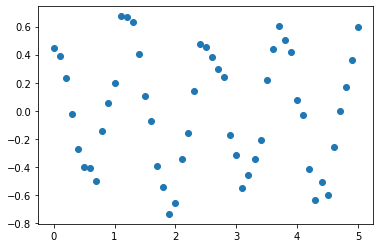

In [12]:
plt.scatter(testRange.tolist(), controlledTwoStateTest[0])

two state job d1f34bf997b54c13a46596891bc4a64b-16623431593915415
[0.0, 0.0546875, -0.02290076335877872, -0.021352313167259773, 0.028880866425992746, 0.17670682730923692, 0.013937282229965209, -0.1412639405204461, -0.14814814814814814, -2.220446049250313e-16, -0.16091954022988508, 0.10108303249097461, 0.03649635036496335, 0.07746478873239426, 0.014760147601476037, 0.21014492753623193, 0.08540925266903909, 0.09558823529411775, -0.0434782608695653, 0.03404255319148919, -0.015209125475285079, -0.03041825095057038, 0.028368794326241176, 0.1853281853281854, 0.0, 0.11857707509881443, 0.14893617021276606, 0.05128205128205132, -0.11023622047244097, 0.06593406593406614, -0.021739130434782483, -0.04411764705882343, -0.03200000000000003, -0.035587188612099696, -0.050000000000000044, 0.029090909090909056, 0.036101083032491044, 0.15384615384615374, -0.02307692307692305, 0.006968641114982521, 0.04528301886792452, -0.1274900398406374, -0.08461538461538459, -0.04285714285714293, -0.06405693950177921, -

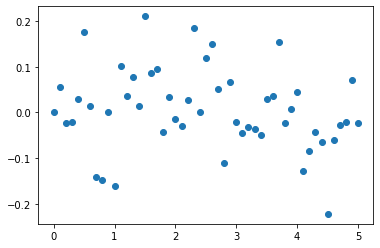

In [13]:
controlledTwoStateTest5 = run_controlled_two_state(5, 1, testRange, 2.5, 1.5, -1, 4, "xx", backend=backendQASM)
plt.scatter(testRange.tolist(), controlledTwoStateTest5[0])

two state job 8bed196de8b34b209c24fceb4ea59ef4-16623432257883682
[0.3539094650205761, 0.26819923371647514, 0.06920415224913512, -2.220446049250313e-16, -0.1278195488721805, -0.16487455197132617, -0.4980842911877395, -0.3866171003717471, -0.21305841924398639, -0.025806451612903125, 0.1376811594202898, 0.26811594202898537, 0.4609665427509293, 0.3602941176470589, 0.2696629213483146, 0.2941176470588234, 0.0347222222222221, -0.20195439739413684, -0.4176706827309236, -0.26819923371647514, -0.22535211267605643, -0.2164179104477611, 0.14229249011857714, 0.1333333333333333, 0.32352941176470584, 0.5107913669064748, 0.26086956521739135, 0.29166666666666674, -0.06644518272425248, -0.20930232558139544, -0.2491582491582493, -0.41877256317689543, -0.272, -0.111111111111111, -0.1231884057971015, 0.10400000000000009, 0.0826446280991735, 0.2681159420289856, 0.32055749128919864, 0.2071713147410359, 0.04580152671755733, 0.08791208791208782, -0.2442748091603053, -0.3346303501945525, -0.33948339483394835, -

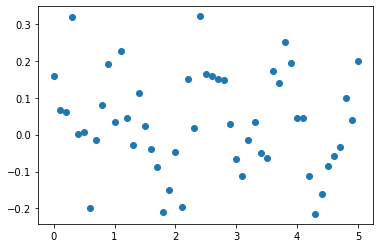

In [14]:
controlledTwoStateTestRedundancy4 = run_controlled_two_state(4, 3, testRange, 2.5, 1.5, -1, 4, "xx", backend=backendQASM)
plt.scatter(testRange.tolist(), controlledTwoStateTestRedundancy4[0])

two state job 28a78defe98c47c892980c3bfdeb8cd7-1662343451725674
[-0.07713498622589543, -0.046620046620046596, 0.00515463917525788, -0.015873015873015817, 0.22506393861892593, 0.3170731707317074, 0.263013698630137, 0.19024390243902434, 0.09090909090909083, -0.09547738693467323, -0.24137931034482762, -0.4205128205128205, -0.20283018867924524, -0.4041994750656168, -0.21568627450980388, -0.17042606516290743, 0.06896551724137923, 0.20151133501259455, 0.3641160949868074, 0.36692506459948326, 0.49874055415617113, 0.4432717678100264, 0.2639593908629443, 0.03030303030303033, -0.10554089709762532, -0.16836734693877542, -0.18372703412073488, -0.20999999999999996, -0.00995024875621886, 0.05994550408719346, 0.11764705882352944, 0.06896551724137945, 0.10106382978723416, -0.03015075376884413, -0.110843373493976, -0.02380952380952378, 0.11428571428571432, -0.4018264840182648, -0.10268948655256721, -0.05626598465473137, -0.009852216748768461, 0.17346938775510212, 0.3065693430656935, 0.31805929919137466

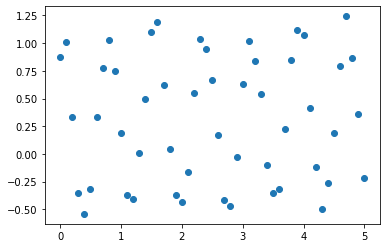

In [20]:
controlledTwoStateTestHighRedundancy = run_controlled_two_state(4, 30, testRange, 2.5, 1.5, -1, 4, "xx", backend=backendQASM, jobID="28a78defe98c47c892980c3bfdeb8cd7-1662343451725674")
plt.scatter(testRange.tolist(), controlledTwoStateTestHighRedundancy[0])

two state job 07b42d2b8eb34700be0d25691e9f842e-16623440112353704
[-0.08783783783783772, 0.14869888475836435, 0.14864864864864868, 0.04026845637583909, -0.050724637681159535, -0.027874564459930418, -0.11985018726591762, 0.03344481605351168, -0.021201413427561766, -0.02266288951841361, -0.027210884353741527, 1.6653345369377348e-16, -0.06691449814126393, -0.06369426751592355, 0.040000000000000036, -0.06896551724137939, -0.0546075085324233, 0.15841584158415833, 0.0, 0.0, 0.06498194945848368, -0.07096774193548394, 0.025316455696202556, -0.05185185185185187, 0.0766550522648084, 0.07868852459016384, 0.007547169811320753, 0.0692041522491349, -0.08480565371024745, -0.09459459459459468, 0.046666666666666856, -0.16370106761565834, 0.21323529411764697, 0.06338028169014076, -0.014545454545454473, 0.020134228187919323, 0.12925170068027225, 0.028673835125448077, -0.04635761589403958, -0.006688963210702337, 0.1276595744680853, -0.040677966101694885, 0.006430868167202508, -0.03412969283276451, -0.04946

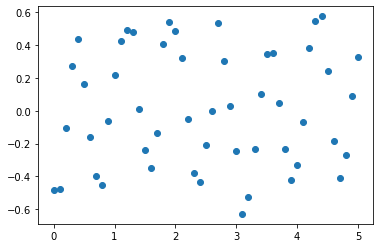

In [21]:
controlledTwoStateTestHighRedundancy2 = run_controlled_two_state(4, 30, testRange, 2.5, 1.5, -1, 4, "xx", backend=backendQASM)
plt.scatter(testRange.tolist(), controlledTwoStateTestHighRedundancy2[0])

two state job cced5091fcc14da2ac783a0863ac286a-16623446175161214


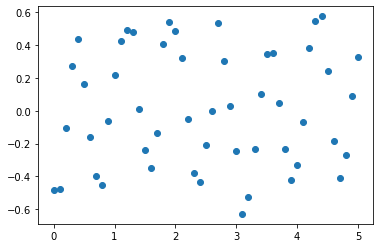

In [26]:
controlledTwoStateTestSymmetric = run_controlled_two_state(4, 30, testRange, 2, 1, -3, -1, "xx", backend=backendQASM)
plt.scatter(testRange.tolist(), controlledTwoStateTestHighRedundancy2[0])

two state job 5c147d43cba24e3285b9ad045b33421f-16623448196068614


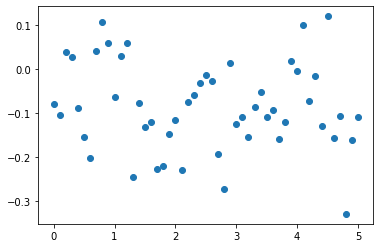

In [30]:
controlledTwoStateTestSymmetric2 = run_controlled_two_state(4, 30, testRange, 2, 1, -1, 3, "xx", backend=backendQASM, jobID="5c147d43cba24e3285b9ad045b33421f-16623448196068614")
plt.scatter(testRange.tolist(), controlledTwoStateTestSymmetric2[0])

two state job c1fa7e8f34ba41c0b71e49a027b5aad3-16623456345505123


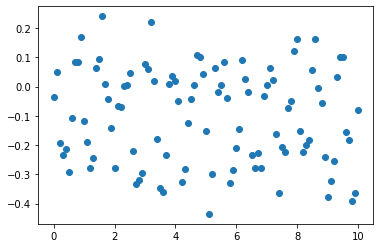

In [29]:
testRange2 = np.linspace(0, 10, 101).tolist()
controlledTwoStateTestVeryHighRedundancy = run_controlled_two_state(4, 100, testRange2, 2.5, 1.5, -1, 4, "xx", backend=backendQASM)
plt.scatter(testRange2, controlledTwoStateTestVeryHighRedundancy[0])

two state job 6fab6425569443c9a4c086e6d4206eb5-16623458133033655


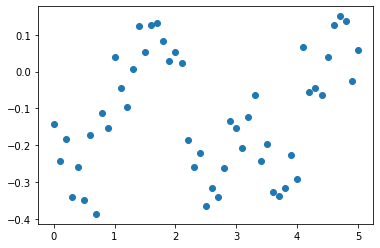

In [31]:
controlledTwoStateTestSymmetric3 = run_controlled_two_state(4, 30, testRange, 2, 1, -1, 3, "zz", backend=backendQASM)
plt.scatter(testRange.tolist(), controlledTwoStateTestSymmetric3[0])

two state job 3c1229f9aacf4870b3ff4faa3d2a1f49-1662345944374755


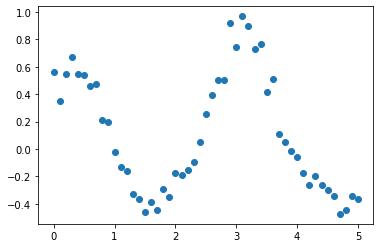

In [32]:
controlledTwoStateTestHighRedundancy3 = run_controlled_two_state(4, 30, testRange, 2.5, 1.5, -1, 4, "zz", backend=backendQASM)
plt.scatter(testRange.tolist(), controlledTwoStateTestHighRedundancy3[0])

two state job f8831599d4f740a99ec57b15bde83800-16623463620358655


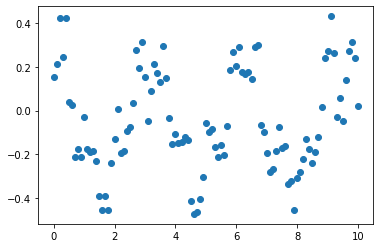

In [34]:
controlledTwoStateTestHighRedundancy4 = run_controlled_two_state(4, 30, testRange2, 2.5, 1.5, -1, 4, "zz", backend=backendQASM)
plt.scatter(testRange2, controlledTwoStateTestHighRedundancy4[0])

In [15]:
contTwoStateTest = run_cont_two_state_test(2, 10, 2.5, 1.5, -1, 4)
print(contTwoStateTest)
#test with ancilla ancilla measure for each cycle

two state job c0aded4c59c14b2580d1cb7d204d1f9d-16635639958588598


In [18]:
test = QuantumCircuit(QuantumRegister(2), ClassicalRegister(2))
test.h(1)
test.measure(0, 0)
test.measure(1, 1)
test = [test, test]
test = transpile(test, backend=backendQASM)
job = jobManager.run(test, backend=backendQASM, name="test", shots=1024)

In [22]:
print(process_cont_test(contTwoStateTest, 2, 10))

382.0


In [23]:
contTwoStateTest2 = run_cont_two_state_test(3, 10, 2.5, 1.5, -1, 4)
print(process_cont_test(contTwoStateTest2, 3, 10))
#test with ancilla ancilla measure for each cycle

two state job 6222797a3a8e4152b50563d3469da423-16635653296861556
263.7


In [26]:
contTwoStateTest3 = run_cont_two_state_test(3, 10, 2.5, 1.5, -1, 4)
print(process_cont_test(contTwoStateTest3, 3, 10))
#test with one ancilla ancilla measure at end of entire thing

two state job 5d7bed901fa149a690c18fbce1ae84ce-16635655735485196
122.0


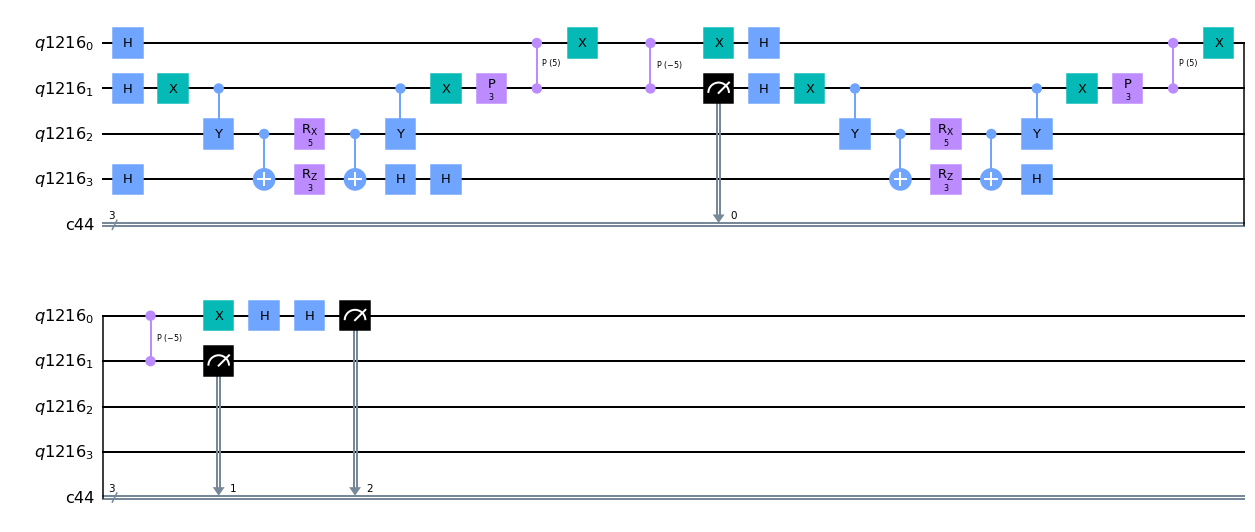

In [27]:
test = test_cont_two_state([1, 1], 2, -1, 4, 2.5, 1.5)
test.draw('mpl')

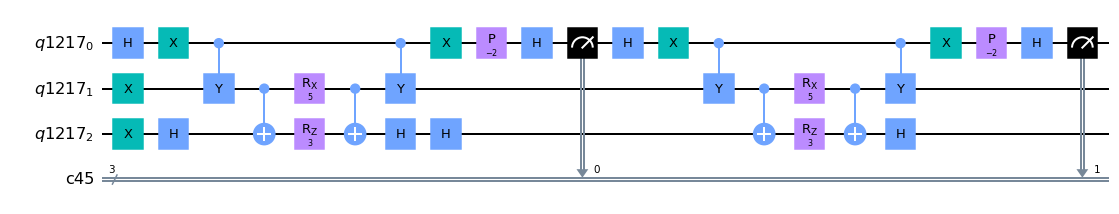

In [28]:
test = run_rodeo([1, 1], 2, -1, 2.5, 1.5)
test.draw('mpl')

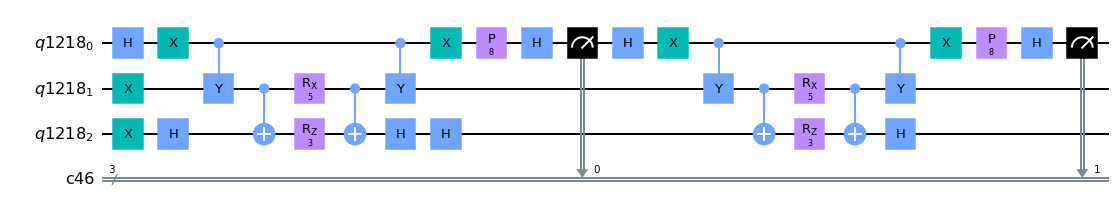

In [29]:
test = run_rodeo([1, 1], 2, 4, 2.5, 1.5)
test.draw('mpl')

Ancilla ancilla has extra Hadamard gates after each cycle; arena qubit doesn't

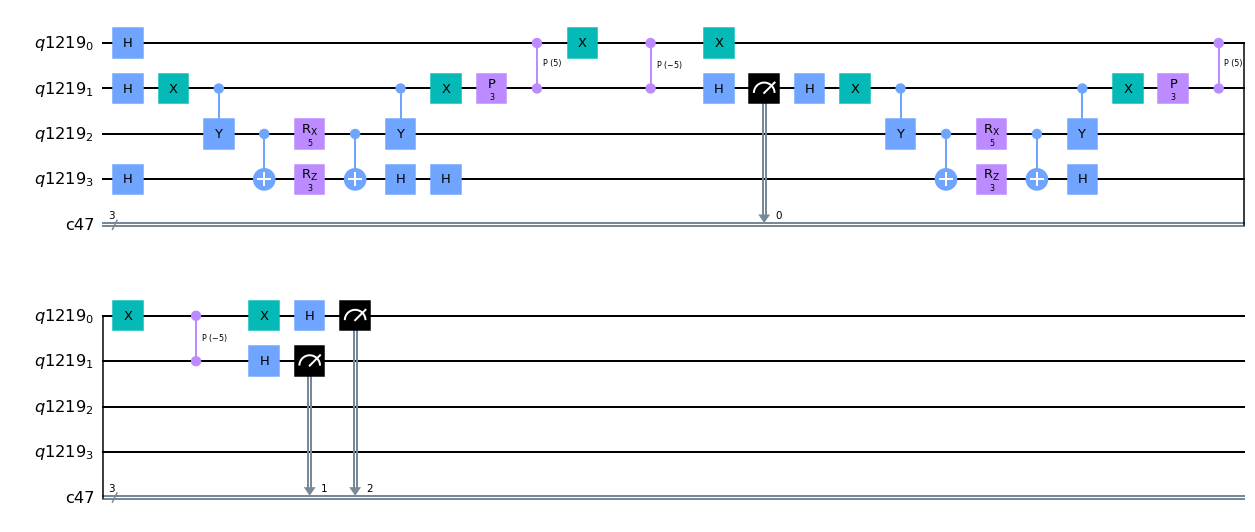

In [33]:
test = test_cont_two_state([1, 1], 2, -1, 4, 2.5, 1.5)
test.draw('mpl')

fixed

In [35]:
contTwoStateTest4 = run_cont_two_state_test(3, 10, 2.5, 1.5, -1, 4)
print(process_cont_test(contTwoStateTest4, 3, 10))
#test with one ancilla ancilla measure at end of entire thing and fixed Hadamard

two state job 21ef61731f584bc7b982fde4c16e2895-1663566002074095
332.9
two state job 4bae5b26ee8143809b283da93446f353-16635660373995807
380.8


In [36]:
contTwoStateTest5 = run_cont_two_state_test(2, 10, 2.5, 1.5, -1, 4)
print(process_cont_test(contTwoStateTest5, 2, 10))
contTwoStateTest6 = run_cont_two_state_test(4, 10, 2.5, 1.5, -1, 4)
print(process_cont_test(contTwoStateTest6, 4, 10))
contTwoStateTest7 = run_cont_two_state_test(5, 10, 2.5, 1.5, -1, 4)
print(process_cont_test(contTwoStateTest7, 5, 10))
#tests with one ancilla ancilla measure at end of entire thing and fixed Hadamard

two state job a44ce06f1e114b8caee913ff79dc80ea-16635661911743448
427.3
two state job df4af0042078484ca6ba68190ba3f45c-16635661989276211
313.0
two state job 886693ca9eca4ebeb5357a671028c5f7-1663566205025928
272.3


In [37]:
contTwoStateTest8 = run_cont_two_state_test(1, 100, 2.5, 1.5, -1, 4)
print(process_cont_test(contTwoStateTest8, 1, 100))

two state job 398f403a275a4dc78a419f3f3ce7567b-16635663775658548
679.22


In [38]:
contTwoStateTest9 = run_cont_two_state_test(10, 100, 2.5, 1.5, -1, 4)
print(process_cont_test(contTwoStateTest9, 10, 100))

two state job 3ca3d4fcb2794832a1fc651c340c88f0-16635664537346966
255.28


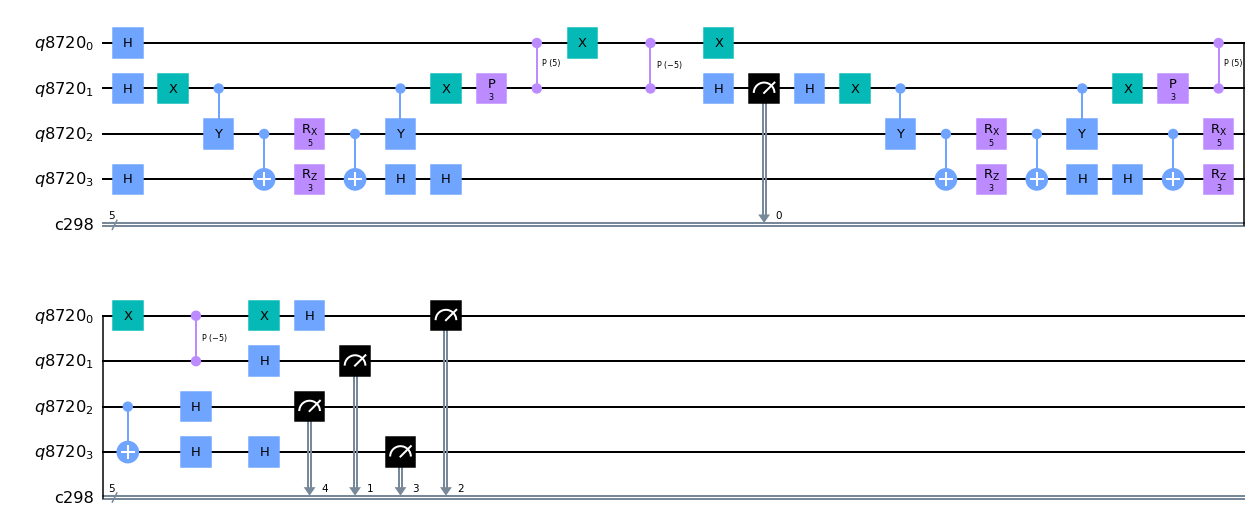

In [43]:
test = test_cont_two_state([1, 1], 2, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')

added uncontrolled time evolution

two state job b05917671aeb468b9475aa6f8208d74d-16635679398269138


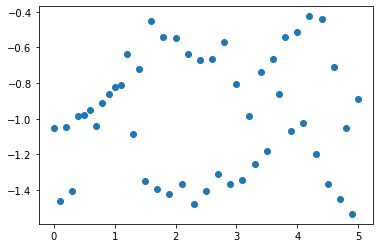

In [49]:
testRange = np.linspace(0, 5, 51)
contTwoStateTest10 = run_cont_two_state_test(5, 3, 2.5, 1.5, -1, 4, testRange, jobID="b05917671aeb468b9475aa6f8208d74d-16635679398269138")
plt.scatter(testRange, process_two_state_dual_test(contTwoStateTest10, 5, 51, 3)[0])

two state job 84c55ec7107e473f8f43330fc7da7c46-16635681671049116


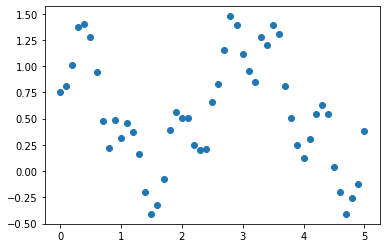

In [61]:
contTwoStateTest10 = run_cont_two_state_test(2, 3, 2.5, 1.5, -1, 4, testRange, jobID="84c55ec7107e473f8f43330fc7da7c46-16635681671049116")
plt.scatter(testRange, process_two_state_dual_test(contTwoStateTest10, 2, 51, 3)[0])

In [62]:
print(process_two_state_dual_test(contTwoStateTest10, 2, 51, 3)[0])

[0.7565823488469278, 0.8124909538283399, 1.0137785215941009, 1.3705274882844976, 1.4005241821200773, 1.2738674918417472, 0.9481667720162456, 0.48171089811610596, 0.22352853078284718, 0.4871374596565436, 0.31761196747599607, 0.4611211767181896, 0.3730177307440122, 0.16578671993911714, -0.19737142771015337, -0.4046446832072759, -0.32570515122622684, -0.07871581316255842, 0.3922440880549925, 0.5593607896044575, 0.5016476185614193, 0.5083448535145855, 0.24940076446312454, 0.20195784481498769, 0.20941921952495002, 0.659558771368955, 0.8285817108280877, 1.15175715631312, 1.4757030619079723, 1.3910922058395132, 1.1202459742169797, 0.9513390121925066, 0.8504684066425708, 1.2819929455719457, 1.2063413289219742, 1.3900995368227897, 1.3087774590328016, 0.8092270465233073, 0.5017025969926828, 0.2524537124165766, 0.1232677216923279, 0.30200258397932817, 0.5451322751380415, 0.6296763067612079, 0.5421881427335116, 0.041340316898283325, -0.20127480246796128, -0.40831224271848104, -0.2527950829269636, 

two state job 8dd396ad3a834196b936d1b2e9998549-16635688098851006


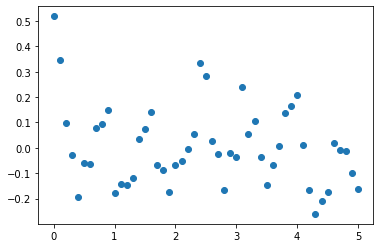

In [64]:
contTwoStateTest11 = run_cont_two_state_test(5, 5, 2.5, 1.5, -1, 4, testRange, jobID="8dd396ad3a834196b936d1b2e9998549-16635688098851006")
plt.scatter(testRange, process_two_state_dual_test(contTwoStateTest11, 5, 51, 5)[0])

two state job 6579cba09e9f41589e5d2db409ddecd4-1663569066481385


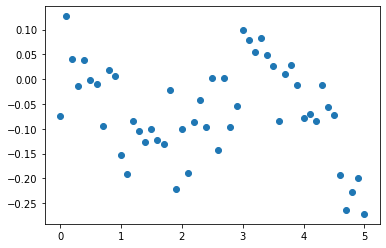

In [66]:
contTwoStateTest12 = run_cont_two_state_test(5, 30, 2.5, 1.5, -1, 4, testRange)
plt.scatter(testRange, process_two_state_dual_test(contTwoStateTest12, 5, 51, 30)[0])

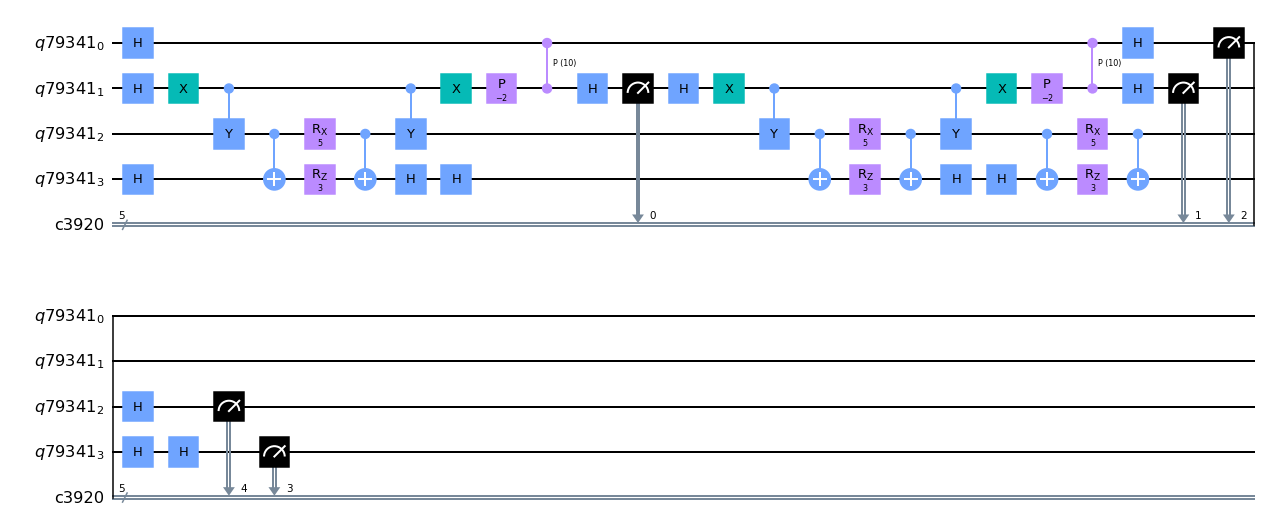

In [70]:
test = test_cont_two_state([1, 1], 2, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')

moved to single phase gate

two state job b2b80443f5b842a89fc3dff1d92c602c-1663569659823159


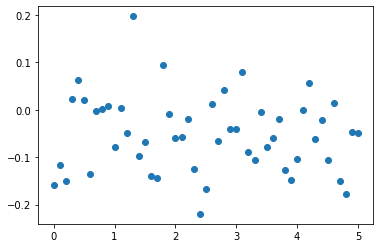

In [71]:
contTwoStateTest13 = run_cont_two_state_test(5, 30, 2.5, 1.5, -1, 4, testRange)
plt.scatter(testRange, process_two_state_dual_test(contTwoStateTest13, 5, 51, 30)[0])

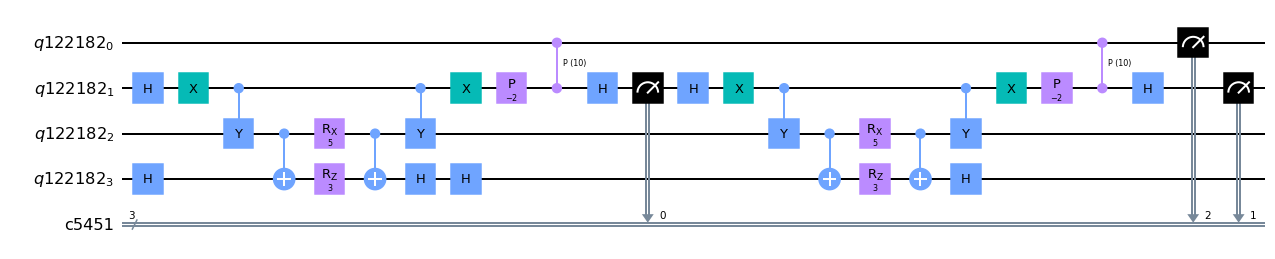

In [74]:
test = test_cont_two_state([1, 1], 2, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')

In [75]:
contTwoStateTest14 = run_cont_two_state_test(3, 10, 2.5, 1.5, -1, 4, [0])
print(process_cont_test(contTwoStateTest14, 3, 10))

two state job 6cab8cbd452f40f5a920daca8478a737-16635913840221019
341.9


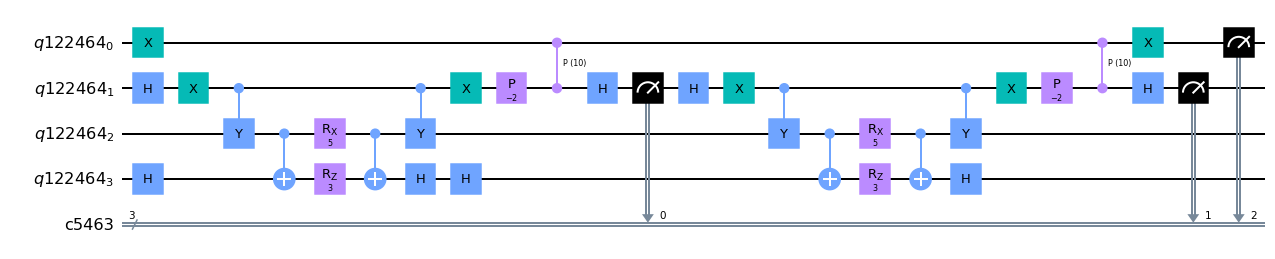

In [80]:
test = test_cont_two_state([1, 1], 2, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')

In [82]:
contTwoStateTest15 = run_cont_two_state_test(3, 10, 2.5, 1.5, -1, 4, [0])
print(process_cont_test(contTwoStateTest15, 3, 10))

two state job 0d70bbbb043447d5a08ddb083d14b239-1663591630880096
367.2


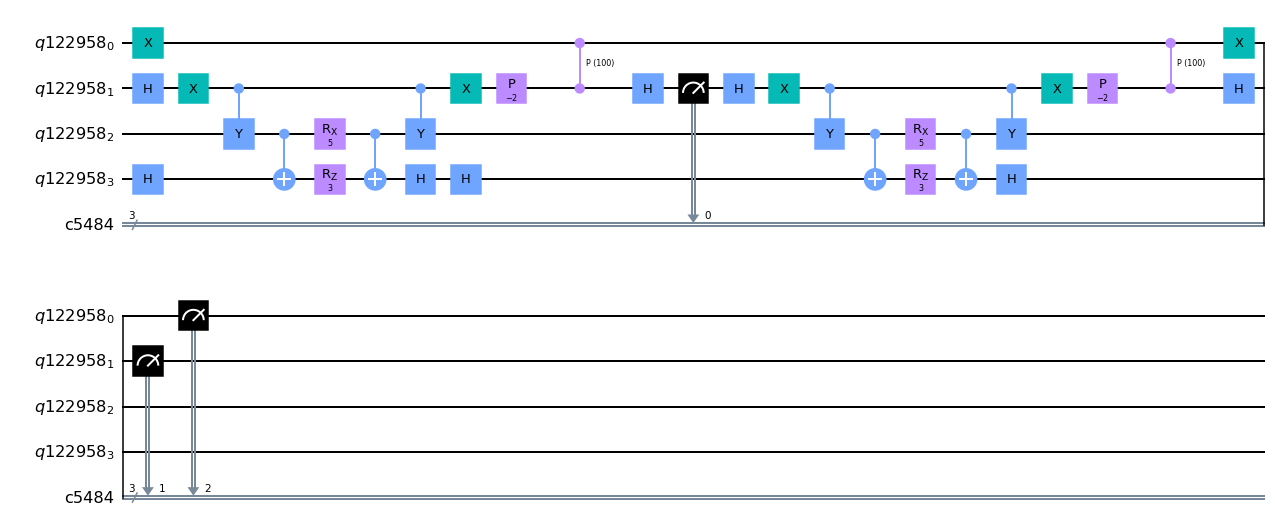

In [85]:
test = test_cont_two_state([1, 1], 2, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')

In [86]:
contTwoStateTest15 = run_cont_two_state_test(3, 10, 2.5, 1.5, -1, 4, [0])
print(process_cont_test(contTwoStateTest15, 3, 10))

two state job ebeca57b55bc47d98f6818952bd4e71b-16635917068475907
86.6


In [89]:
test = test_cont_two_state([1, 1], 2, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')
contTwoStateTest16 = run_cont_two_state_test(3, 10, 2.5, 1.5, -1, 4, [0])
print(process_cont_test(contTwoStateTest16, 3, 10))

two state job 0b49728d62aa4b3fa7dbb68aa0274d9c-16635918445931401
333.8


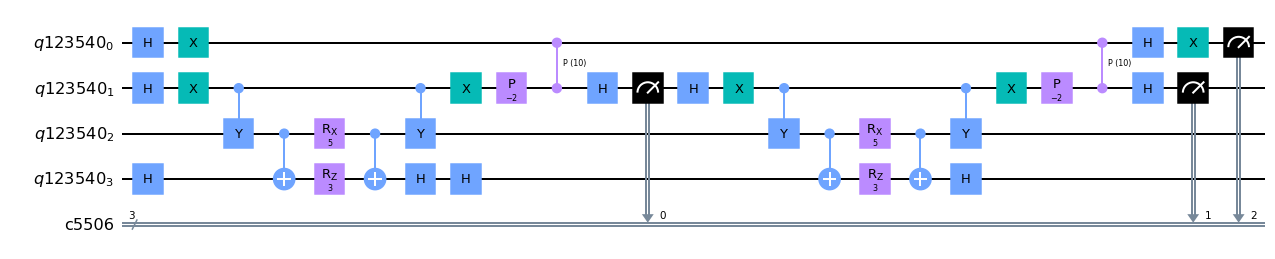

In [90]:
test = test_cont_two_state([1, 1], 2, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')

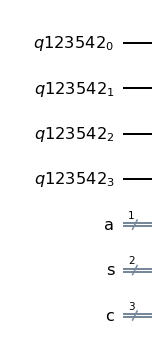

In [92]:
test = QuantumCircuit(QuantumRegister(4), ClassicalRegister(1, "a"), ClassicalRegister(2, "s"), ClassicalRegister(3, "c"))
test.draw('mpl')

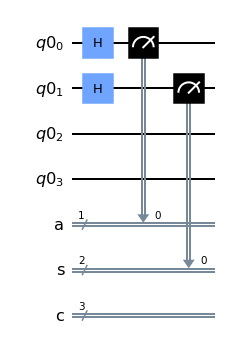

In [4]:
test = QuantumCircuit(QuantumRegister(4), ClassicalRegister(1, "a"), ClassicalRegister(2, "s"), ClassicalRegister(3, "c"))
test.h(0)
test.h(1)
test.measure([0,1], [0,1])
test.draw('mpl')

In [12]:
test = [test, test]
test = transpile(test, backend=backendQASM)
job = jobManager.run(test, backend=backendQASM, name="test", shots=1024)

QiskitError: 'No memory for experiment "0". Please verify that you either ran a measurement level 2 job with the memory flag set, eg., "memory=True", or a measurement level 0/1 job.'

In [6]:
test = transpile(test, backend=backendQASM)
testjob = backendQASM.run(test)

In [21]:
print(testjob.result().get_counts())
print(job.results().get_counts(0)['000 00 0'])

{'000 00 0': 1043, '000 00 1': 1027, '000 01 0': 953, '000 01 1': 977}
271


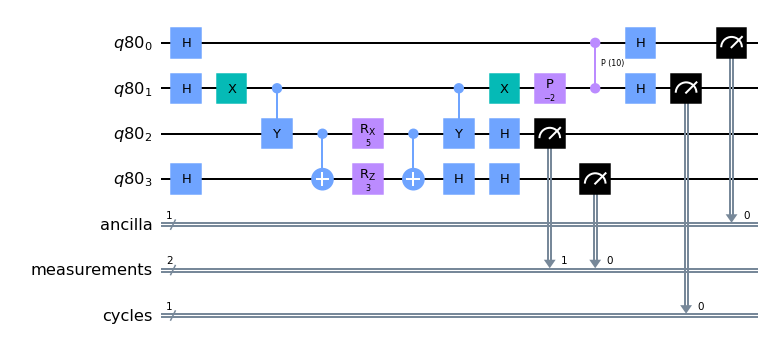

In [38]:
test = test_cont_two_state([1], 1, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')

In [46]:
test = run_cont_two_state_test(5, 2, 2.5, 1.5, -1, 4, [0], jobID='6779edffaac049419cb96f1ad7fa2223-1664154312939769')
print(test.get_counts(0))
successes = dict(filter(lambda item: "00000" in item[0], test.get_counts(0).items()))
print(successes, np.sum(list(successes.values())))

two state job 6779edffaac049419cb96f1ad7fa2223-1664154312939769
{'00000 00 0': 63, '00000 00 1': 10, '00010 10 0': 1, '00011 01 1': 3, '00011 10 0': 1, '00011 10 1': 2, '00011 11 0': 1, '00011 11 1': 1, '00000 01 0': 16, '00000 01 1': 54, '00110 01 0': 1, '00110 10 1': 1, '00110 11 0': 2, '00110 11 1': 1, '00111 01 0': 1, '00000 10 0': 40, '01000 01 0': 1, '01000 10 0': 2, '01000 11 1': 1, '01001 10 0': 1, '01001 11 0': 1, '00000 10 1': 11, '01010 00 0': 5, '01010 00 1': 2, '01010 01 0': 6, '01010 01 1': 11, '01010 10 1': 2, '01010 11 0': 3, '01011 00 0': 1, '01011 01 0': 2, '01011 10 0': 2, '01011 10 1': 1, '01011 11 1': 1, '00000 11 0': 8, '01100 00 0': 2, '01100 00 1': 3, '01100 10 0': 18, '01100 10 1': 2, '01100 11 0': 1, '01100 11 1': 28, '01101 00 0': 10, '01101 00 1': 3, '01101 01 0': 3, '01101 01 1': 16, '01101 10 0': 8, '01101 10 1': 3, '01101 11 0': 1, '01101 11 1': 3, '00000 11 1': 52, '01110 00 0': 19, '01110 00 1': 1, '01110 01 0': 5, '01110 01 1': 17, '01110 10 0': 1, '01

In [55]:
process_two_state_register(test, 5, 2)

{'00000 00 0': 63, '00000 00 1': 10, '00000 01 0': 16, '00000 01 1': 54, '00000 10 0': 40, '00000 10 1': 11, '00000 11 0': 8, '00000 11 1': 52}
254
{'00000 00 0': 16, '00000 00 1': 58, '00000 01 0': 41, '00000 01 1': 11, '00000 10 0': 10, '00000 10 1': 40, '00000 11 0': 64, '00000 11 1': 18}
258


[0.020173350424220304,
 [0.051364219007507816, -0.031190868583287568],
 [0.05118110236220476, -0.031007751937984496],
 [[0.06299212598425198, -0.011811023622047251],
  [-0.011627906976744207, -0.01937984496124029]]]

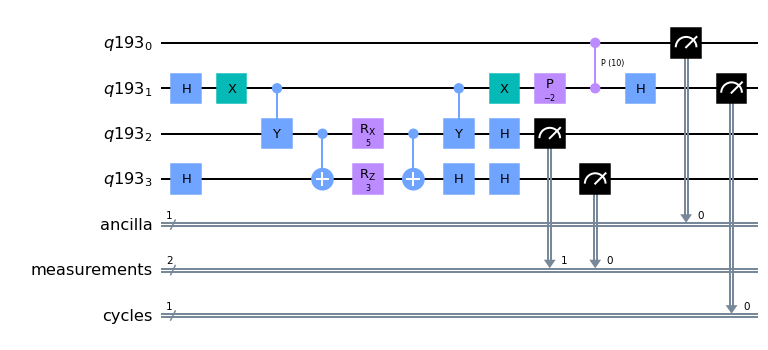

In [56]:
test = test_cont_two_state([1], 1, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')

In [57]:
test = run_cont_two_state_test(5, 2, 2.5, 1.5, -1, 4, [0])

two state job c6a14dd95718433a8822ef5c5838a342-1664159549683748


In [60]:
process_two_state_register(test, 5, 2)

{'00000 00 0': 59, '00000 01 0': 109, '00000 10 0': 11, '00000 11 0': 110}
289
{'00000 00 0': 6, '00000 01 0': 4, '00000 10 0': 189, '00000 11 0': 170}
369


[-0.6209150326797386,
 [-0.39158485010455646, -0.22933018257518215],
 [-0.1764705882352941, -0.4444444444444444],
 [[0.08131487889273356, -0.2577854671280277],
  [-0.47289972899729, 0.028455284552845544]]]

In [69]:
test = run_cont_two_state_test(5, 2, 2.5, 1.5, -1, 4, [0])
process_two_state_register(test, 5, 2)

two state job f4d925de4bad452aa52340d74c471e17-16641608039654973
{'00000 00 0': 87, '00000 01 0': 41, '00000 10 0': 57, '00000 11 0': 57}
242
{'00000 00 0': 79, '00000 01 0': 63, '00000 10 0': 55, '00000 11 0': 54}
251


[0.44713707154851656,
 [0.1893253432550788, 0.2578117282934378],
 [0.24793388429752072, 0.19920318725099598],
 [[0.05785123966942152, 0.1900826446280992],
  [0.13147410358565728, 0.06772908366533861]]]

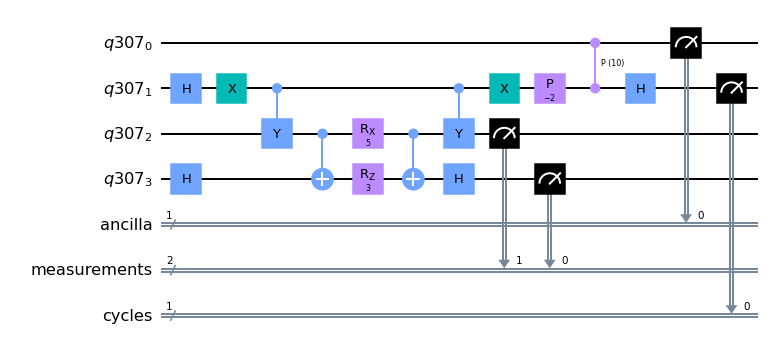

In [65]:
test = test_cont_two_state([1], 1, -1, 4, 2.5, 1.5, 1)
test.draw('mpl')

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D349BE1F60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34C4B99F0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34C4BAE60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34C4BA140>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34C4C4DC0>]
[Statevector([ 0.        +0.j        ,  0.        +0.j        ,
             -0.3666734 +0.39660755j,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
             -0.38229378+0.41350313j,  0.        +0.j        ,
              0.        -0.j        ,  0.        +0.j        ,
              0.29229194-0.3161538j ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
             -0.30791232+0.33304938j,  0.        +0.j        ],
            dims=(2, 2, 2, 2)), Statevector([0.0653265 -0.1572972j , 0.        +0.j        ,
             0.

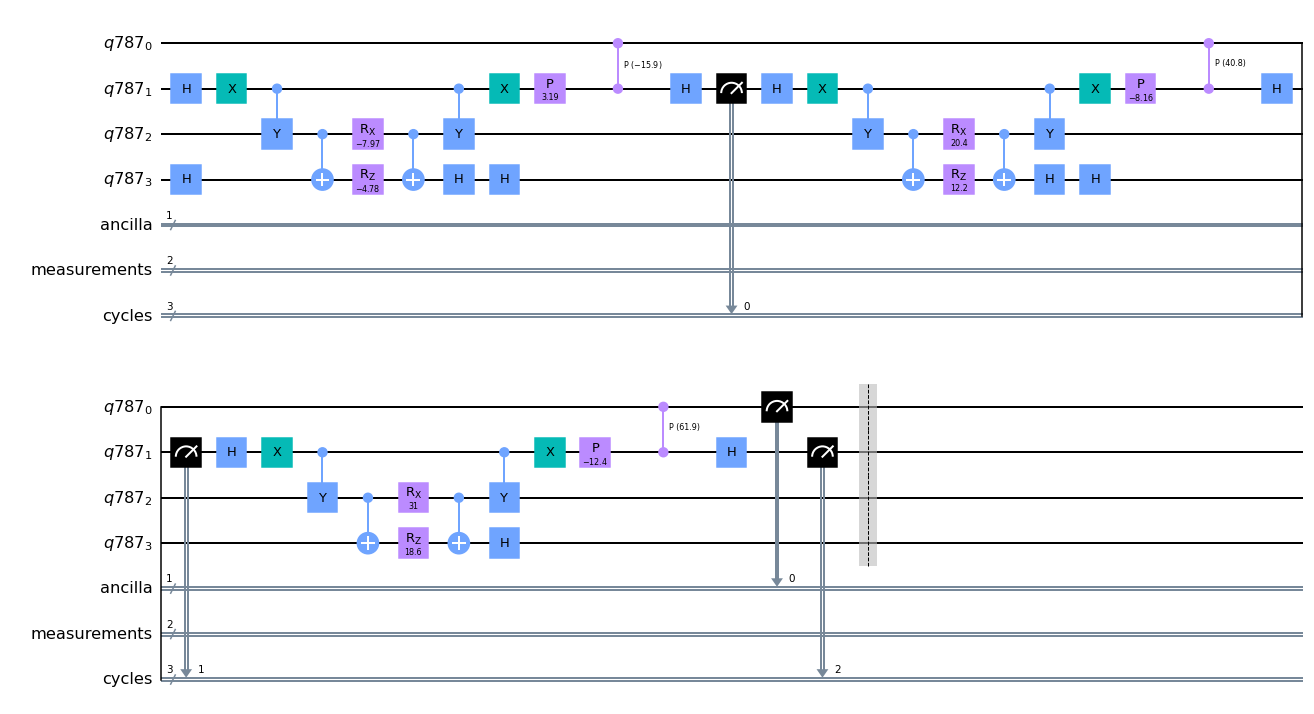

In [44]:
test = make_cont_two_state_test_circs(3, 5, 2.5, 1.5, -1, 4, [0])
print(test)
transpiledTest = [transpile(circ, backendStatevector) for circ in test]
results = [backendStatevector.run(transcirc).result() for transcirc in transpiledTest]
statevectors = [result.get_statevector(0) for result in results]
print(statevectors)
test[0].draw('mpl')


[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34B1517B0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34B1506D0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34B12F910>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34BA541C0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34BADC220>]
[Statevector([ 0.        +0.j        ,  0.        +0.j        ,
             -0.13691717-0.43456462j,  0.        +0.j        ,
             -0.        +0.j        ,  0.        +0.j        ,
              0.16219165+0.51478387j,  0.        +0.j        ,
             -0.        +0.j        ,  0.        +0.j        ,
              0.16564534+0.52574563j,  0.        +0.j        ,
             -0.        +0.j        ,  0.        +0.j        ,
              0.13346348+0.42360286j,  0.        +0.j        ],
            dims=(2, 2, 2, 2)), Statevector([ 0.        +0.j        ,  0.        +0.j        ,
             

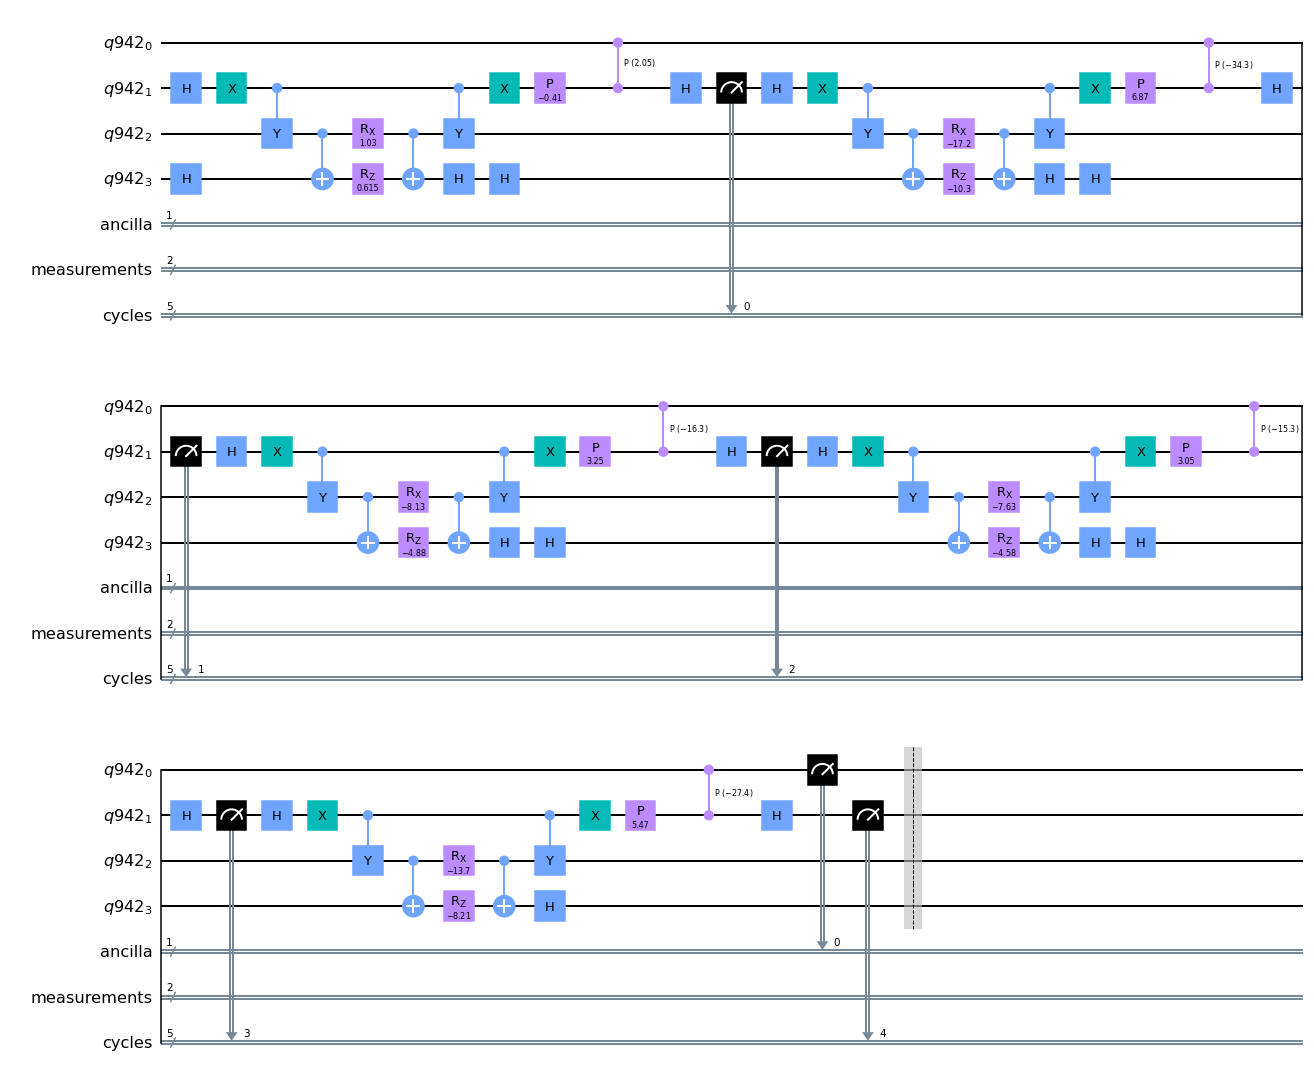

In [45]:
test = make_cont_two_state_test_circs(5, 5, 2.5, 1.5, -1, 4, [0])
print(test)
transpiledTest = [transpile(circ, backendStatevector) for circ in test]
results = [backendStatevector.run(transcirc).result() for transcirc in transpiledTest]
statevectors = [result.get_statevector(0) for result in results]
print(statevectors)
test[0].draw('mpl')

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D349304E50>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34AC0C9A0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34ABDEEF0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34ABDE830>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001D34ABE4C40>]
[Statevector([ 0.        -0.j        ,  0.        +0.j        ,
              0.26129174-0.23078594j,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
             -0.47768952-0.38735537j,  0.        +0.j        ,
              0.        -0.j        ,  0.        +0.j        ,
             -0.12494558+0.32601526j,  0.        +0.j        ,
             -0.        +0.j        ,  0.        +0.j        ,
             -0.52879351-0.31418639j, -0.        +0.j        ],
            dims=(2, 2, 2, 2)), Statevector([ 0.        -0.j        ,  0.        +0.j        ,
             

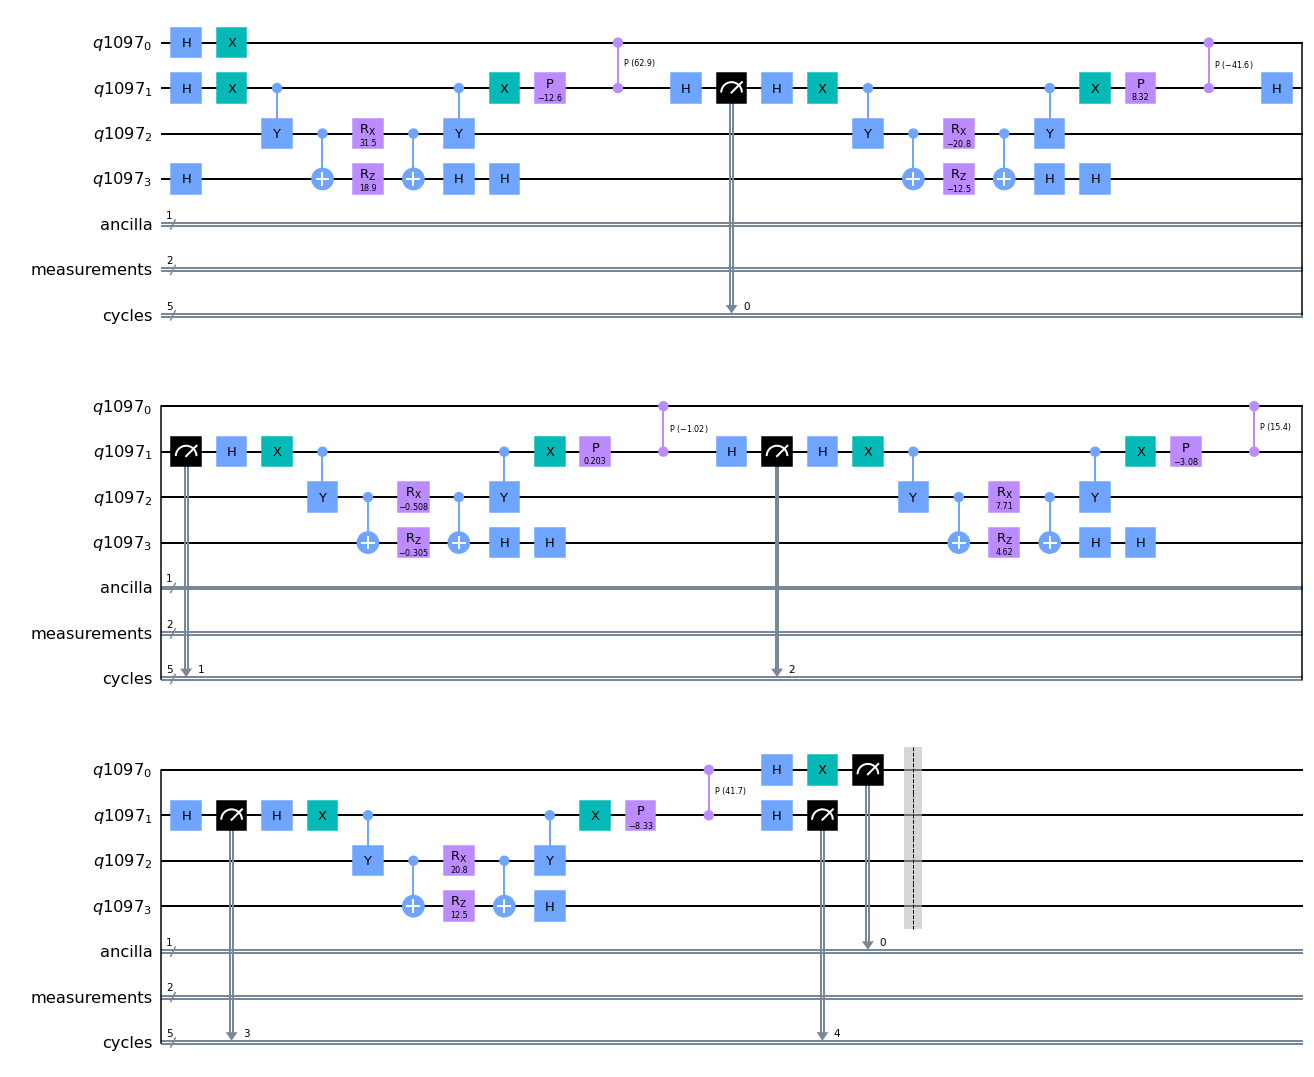

In [48]:
test = make_cont_two_state_test_circs(5, 5, 2.5, 1.5, -1, 4, [0])
print(test)
transpiledTest = [transpile(circ, backendStatevector) for circ in test]
results = [backendStatevector.run(transcirc).result() for transcirc in transpiledTest]
statevectors = [result.get_statevector(0) for result in results]
print(statevectors)
test[0].draw('mpl')

In [50]:
quantinuumCircs = make_cont_two_state_test_circs(3, 5, 2.5, 1.5, -1, 4, [0])

{'10010 00 0': 182, '11111 00 0': 52, '01101 00 0': 89, '11110 00 0': 44, '01100 00 0': 29, '10000 00 0': 47, '01110 00 0': 68, '01010 00 0': 1, '00000 00 0': 276, '00001 00 0': 49, '11101 00 0': 26, '11100 00 0': 31, '01111 00 0': 16, '10011 00 0': 43, '00010 00 0': 36, '10001 00 0': 13, '00011 00 0': 20, '01001 00 0': 1, '10101 00 0': 1}
0b0: (0.13269630529587367-0.22574397867590082j)
0b1: (0.2048262768165154+0.10662572930620612j)
0b10: (-0+0j)
0b11: 0j
0b100: (0.17497939119752473+0.1601216465897129j)
0b101: (0.0855288404383428-0.2520600416584215j)
0b110: -0j
0b111: 0j
0b1000: (0.1388000939794972+0.3772195002973992j)
0b1001: (-0.0330273048001929-0.4145487640140211j)
0b1010: 0j
0b1011: -0j
0b1100: (0.0031804191812022913+0.46804468129752785j)
0b1101: (-0.18596755883702806-0.4035355632799199j)
0b1110: -0j
0b1111: 0j
{'11001 00 0': 39, '00001 00 0': 29, '10111 00 0': 35, '00000 00 0': 250, '11111 00 0': 16, '10001 00 0': 41, '10100 00 0': 76, '00011 00 0': 98, '01001 00 0': 74, '00010 00

C:\Users\Max\AppData\Local\Temp\ipykernel_46120\4146455009.py:10: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for j in range(len(statevectors[i])):


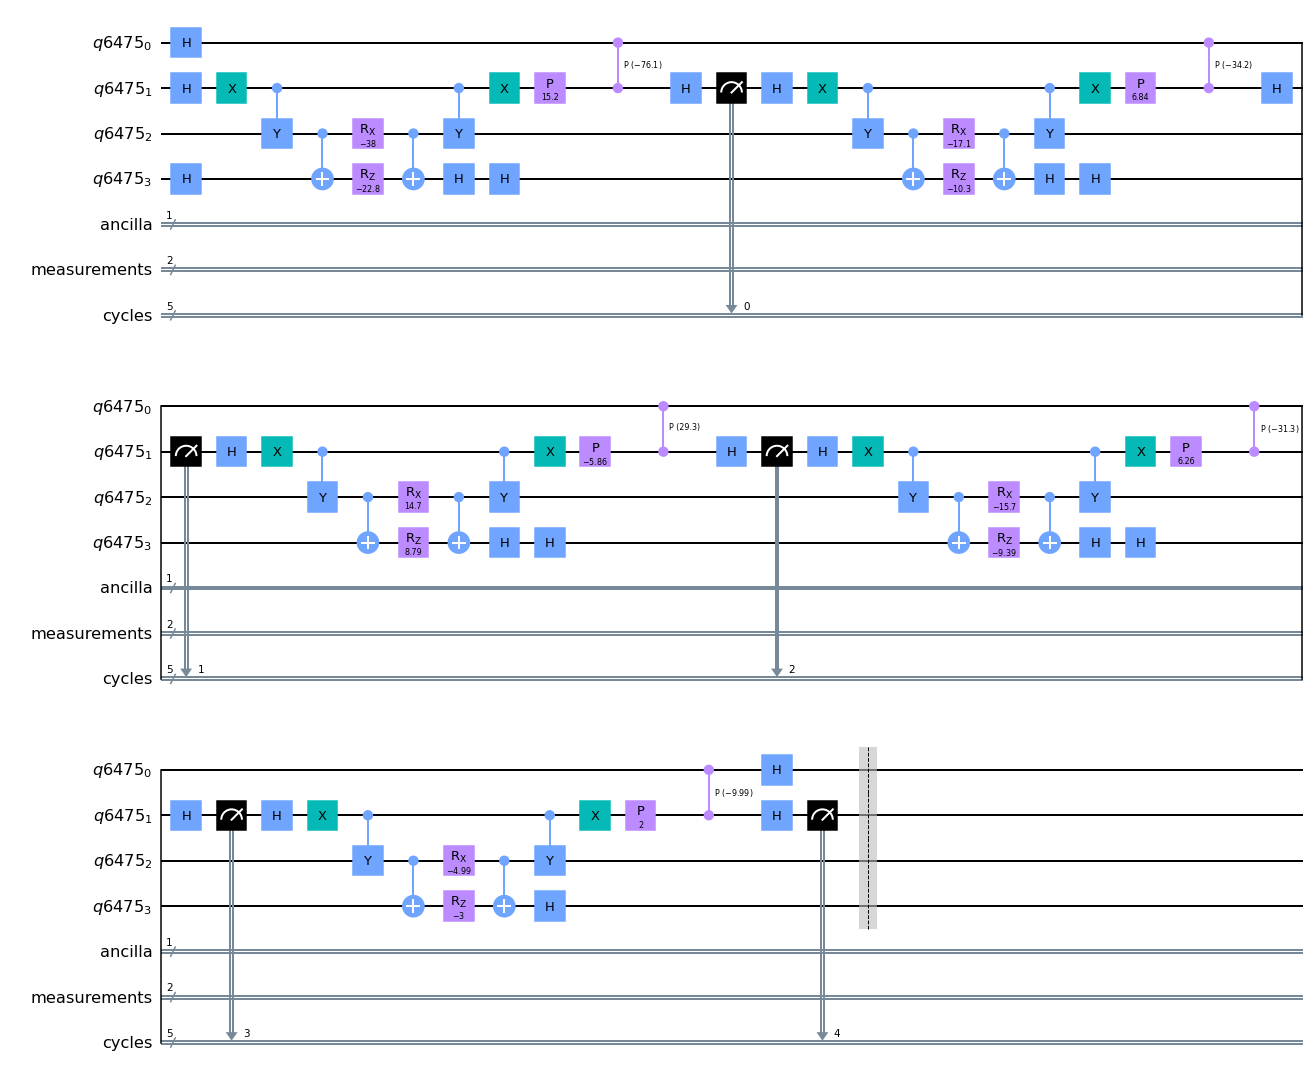

In [53]:
test = make_cont_two_state_test_circs(5, 5, 2.5, 1.5, -1, 4, [0])
# print(test)
transpiledTest = [transpile(circ, backendStatevector) for circ in test]
results = [backendStatevector.run(transcirc).result() for transcirc in transpiledTest]
# print(results)
statevectors = [result.get_statevector(0) for result in results]
readouts = [result.get_counts(0) for result in results]
for i in range(len(readouts)):
    print(readouts[i])
    for j in range(len(statevectors[i])):
        print(bin(j) +": "+ statevectors[i][j].astype('|S100').decode('UTF-8'))
test[0].draw('mpl')

In [7]:
test = make_cont_two_state_test_circs(5, 10, 2.5, 1.5, -1, 4, [0])
# print(test)
transpiledTest = [transpile(circ, backendStatevector) for circ in test]
results = [backendStatevector.run(transcirc).result() for transcirc in transpiledTest]
# print(results)
total0 = list()
total1 = list()
statevectors = [result.get_statevector(0) for result in results]
readouts = [result.get_counts(0) for result in results]
for i in range(len(readouts)):
    # print(readouts[i])
    isSuccess = True
    state = list()
    combinedState0 = [0, 0, 0, 0]
    combinedState1 = [0, 0, 0, 0]
    for k in range(len(np.asarray(statevectors[i]))):
        if isSuccess and k != 192 and k != 193 and k!= 0 and k != 1 and k != 64 and k!= 65 and k!= 128 and k!= 129:
            isSuccess = np.real_if_close(statevectors[i][k]) == 0
    if isSuccess:
        for j in range(len(np.asarray(statevectors[i]))):
            if j == 192 or j == 193 or j== 0 or j == 1 or j == 64 or j == 65 or j == 128 or j == 129:
                print(bin(j) +": "+ statevectors[i][j].astype('|S100').decode('UTF-8'))
                state.append(statevectors[i][j])
        for j in range(4):
            combinedState0[j] = state[2*j]
            combinedState1[j] = +state[2*j+1]
        print(combinedState0)
        print(np.angle(combinedState0))
        print(combinedState1)
        print(np.angle(combinedState1))
        state = list()
        total0.append(combinedState0)
        combinedState0 = [0, 0, 0, 0]
        total1.append(combinedState1)
        combinedState1 = [0, 0, 0, 0]

    else:
        print("Failed RA")
test[0].draw('mpl')

print(total1)
average1 = [0, 0, 0, 0]
for successfulState in total1:
    for j in range(len(successfulState)):
        average1[j] += np.abs(successfulState[j])/len(total1)
print("averaged for ancilla = 1 state: ")
print(average1)

print(total0)
average0 = [0, 0, 0, 0]
for successfulState in total0:
    for j in range(len(successfulState)):
        average0[j] += np.abs(successfulState[j])/len(total0)

print("averaged for ancilla = 0 state: ")
print(average0) 

NameError: name 'make_cont_two_state_test_circs' is not defined

In [27]:
test = make_cont_two_state_test_circs(5, 10, 2.5, 1.5, -1, 4, [0])
# print(test)
transpiledTest = [transpile(circ, backendStatevector) for circ in test]
results = [backendStatevector.run(transcirc).result() for transcirc in transpiledTest]
# print(results)
total0 = list()
total1 = list()
statevectors = [result.get_statevector(0) for result in results]
readouts = [result.get_counts(0) for result in results]
for i in range(len(readouts)):
    # print(readouts[i])
    isSuccess = True
    state = list()
    combinedState0 = [0, 0, 0, 0]
    combinedState1 = [0, 0, 0, 0]
    for k in range(len(np.asarray(statevectors[i]))):
        if isSuccess and k != 192 and k != 193 and k!= 0 and k != 1 and k != 64 and k!= 65 and k!= 128 and k!= 129:
            isSuccess = np.real_if_close(statevectors[i][k]) == 0
    if isSuccess:
        for j in range(len(np.asarray(statevectors[i]))):
            if j == 192 or j == 193 or j== 0 or j == 1 or j == 64 or j == 65 or j == 128 or j == 129:
                print(bin(j) +": "+ statevectors[i][j].astype('|S100').decode('UTF-8'))
                state.append(statevectors[i][j])
        for j in range(4):
            combinedState0[j] = state[2*j]
            combinedState1[j] = +state[2*j+1]
        print(combinedState0)
        print(np.angle(combinedState0))
        print(combinedState1)
        print(np.angle(combinedState1))
        state = list()
        total0.append(combinedState0)
        combinedState0 = [0, 0, 0, 0]
        total1.append(combinedState1)
        combinedState1 = [0, 0, 0, 0]

    else:
        print("Failed RA")
test[0].draw('mpl')

print(total1)
average1 = [0, 0, 0, 0]
for successfulState in total1:
    for j in range(len(successfulState)):
        average1[j] += np.abs(successfulState[j])/len(total1)
print("averaged for ancilla = 1 state: ")
print(average1)

print(total0)
average0 = [0, 0, 0, 0]
for successfulState in total0:
    for j in range(len(successfulState)):
        average0[j] += np.abs(successfulState[j])/len(total0)

print("averaged for ancilla = 0 state: ")
print(average0)

Failed RA
0b0: 0j
0b1: (0.3189279824485235-0.47078486589374796j)
0b1000000: 0j
0b1000001: (0.22362772707722844-0.33010759574591253j)
0b10000000: 0j
0b10000001: (0.3183343833541788-0.4699086258477028j)
0b11000000: 0j
0b11000001: (-0.24799573913630008+0.3660783851424777j)
[0j, 0j, 0j, 0j]
[0. 0. 0. 0.]
[(0.3189279824485235-0.47078486589374796j), (0.22362772707722844-0.33010759574591253j), (0.3183343833541788-0.4699086258477028j), (-0.24799573913630008+0.3660783851424777j)]
[-0.97537305 -0.97537305 -0.97537305  2.1662196 ]
Failed RA
Failed RA
0b0: 0j
0b1: (-0.48255700646204736-0.437206951408411j)
0b1000000: 0j
0b1000001: (-0.14828777249558073-0.1343518881204678j)
0b10000000: 0j
0b10000001: (-0.4908708930321569-0.4447395101589774j)
0b11000000: 0j
0b11000001: (0.23104512395797183+0.2093318155797785j)
[0j, 0j, 0j, 0j]
[0. 0. 0. 0.]
[(-0.48255700646204736-0.437206951408411j), (-0.14828777249558073-0.1343518881204678j), (-0.4908708930321569-0.4447395101589774j), (0.23104512395797183+0.20933181

In [28]:
test = make_cont_two_state_test_circs(5, 100, 2.5, 1.5, -1, 4, [0])
# print(test)
transpiledTest = [transpile(circ, backendStatevector) for circ in test]
results = [backendStatevector.run(transcirc).result() for transcirc in transpiledTest]
# print(results)
total0 = list()
total1 = list()
statevectors = [result.get_statevector(0) for result in results]
readouts = [result.get_counts(0) for result in results]
for i in range(len(readouts)):
    # print(readouts[i])
    isSuccess = True
    state = list()
    combinedState0 = [0, 0, 0, 0]
    combinedState1 = [0, 0, 0, 0]
    for k in range(len(np.asarray(statevectors[i]))):
        if isSuccess and k != 192 and k != 193 and k!= 0 and k != 1 and k != 64 and k!= 65 and k!= 128 and k!= 129:
            isSuccess = np.real_if_close(statevectors[i][k]) == 0
    if isSuccess:
        for j in range(len(np.asarray(statevectors[i]))):
            if j == 192 or j == 193 or j== 0 or j == 1 or j == 64 or j == 65 or j == 128 or j == 129:
                print(bin(j) +": "+ statevectors[i][j].astype('|S100').decode('UTF-8'))
                state.append(statevectors[i][j])
        for j in range(4):
            combinedState0[j] = state[2*j]
            combinedState1[j] = +state[2*j+1]
        print(combinedState0)
        print(np.angle(combinedState0))
        print(combinedState1)
        print(np.angle(combinedState1))
        state = list()
        total0.append(combinedState0)
        combinedState0 = [0, 0, 0, 0]
        total1.append(combinedState1)
        combinedState1 = [0, 0, 0, 0]

    else:
        print("Failed RA")
test[0].draw('mpl')

print(total1)
average1 = [0, 0, 0, 0]
averagePhase1 = [0, 0, 0, 0]
for successfulState in total1:
    for j in range(len(successfulState)):
        average1[j] += np.abs(successfulState[j])/len(total1)
        averagePhase1[j] += np.abs(np.angle(successfulState[j])/len(total1))

average1 = average1/np.linalg.norm(average1)
print("averaged for ancilla = 1 state: ")
print(average1)
print(averagePhase1)

print(total0)
average0 = [0, 0, 0, 0]
averagePhase0 = [0, 0, 0, 0]
for successfulState in total0:
    for j in range(len(successfulState)):
        average0[j] += np.abs(successfulState[j])/len(total0)
        averagePhase0[j] += np.abs(np.angle(successfulState[j])/len(total0))

average0 = average0/np.linalg.norm(average0)
print("averaged for ancilla = 0 state: ")
print(average0)
print(averagePhase0)

Failed RA
0b0: (0.34665896282531405-2.376922107474629e-16j)
0b1: (0.14586716140666448-1.727236173159406e-16j)
0b1000000: (0.1458671614066645-1.65624271157874e-16j)
0b1000001: (-0.5534953348147782+6.046939973433855e-16j)
0b10000000: (0.6425594633981833-6.965365440439113e-16j)
0b10000001: (-0.14586716140666448+2.410648724107185e-16j)
0b11000000: (0.1458671614066645-1.5893279205564214e-16j)
0b11000001: (0.2747342328892439-3.150864003899162e-16j)
[(0.34665896282531405-2.376922107474629e-16j), (0.1458671614066645-1.65624271157874e-16j), (0.6425594633981833-6.965365440439113e-16j), (0.1458671614066645-1.5893279205564214e-16j)]
[-6.85665845e-16 -1.13544591e-15 -1.08400325e-15 -1.08957212e-15]
[(0.14586716140666448-1.727236173159406e-16j), (-0.5534953348147782+6.046939973433855e-16j), (-0.14586716140666448+2.410648724107185e-16j), (0.2747342328892439-3.150864003899162e-16j)]
[-1.18411585e-15  3.14159265e+00  3.14159265e+00 -1.14687710e-15]
Failed RA
Failed RA
Failed RA
Failed RA
Failed RA
Fail

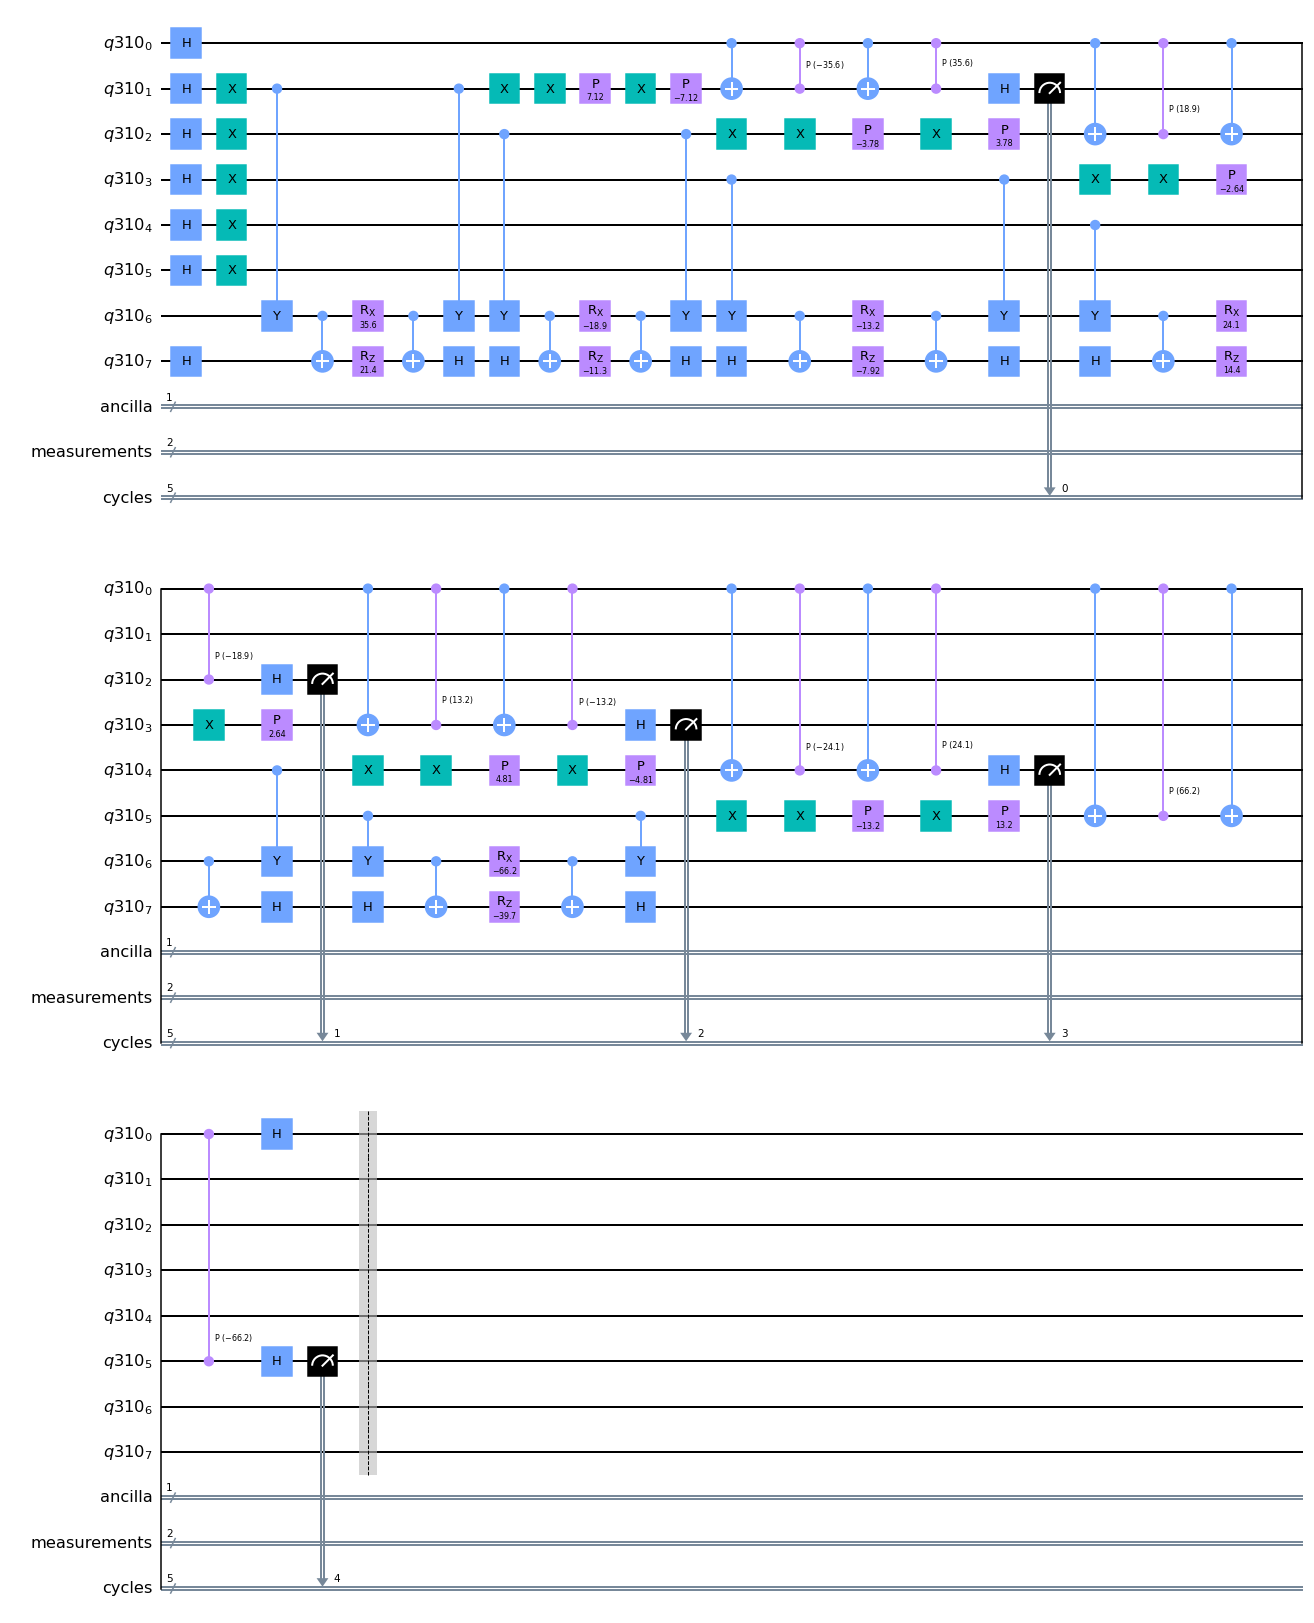

In [19]:
test[0].draw('mpl')

In [37]:
test = make_cont_two_state_test_circs(5, 100, 2.5, 1.5, -1, 4, [0])
# print(test)
transpiledTest = [transpile(circ, backendStatevector) for circ in test]
results = [backendStatevector.run(transcirc).result() for transcirc in transpiledTest]
# print(results)
total0 = list()
total1 = list()
statevectors = [result.get_statevector(0) for result in results]
readouts = [result.get_counts(0) for result in results]
for i in range(len(readouts)):
    # print(readouts[i])
    isSuccess = True
    state = list()
    combinedState0 = [0, 0, 0, 0]
    combinedState1 = [0, 0, 0, 0]
    for k in range(len(np.asarray(statevectors[i]))):
        if isSuccess and k != 192 and k != 193 and k!= 0 and k != 1 and k != 64 and k!= 65 and k!= 128 and k!= 129:
            isSuccess = np.real_if_close(statevectors[i][k]) == 0
    if isSuccess:
        for j in range(len(np.asarray(statevectors[i]))):
            if j == 192 or j == 193 or j== 0 or j == 1 or j == 64 or j == 65 or j == 128 or j == 129:
                print(bin(j) +": "+ statevectors[i][j].astype('|S100').decode('UTF-8'))
                state.append(statevectors[i][j])
        for j in range(4):
            combinedState0[j] = state[2*j]
            combinedState1[j] = +state[2*j+1]
        print(combinedState0)
        print(np.angle(combinedState0))
        print(combinedState1)
        print(np.angle(combinedState1))
        state = list()
        total0.append(combinedState0)
        combinedState0 = [0, 0, 0, 0]
        total1.append(combinedState1)
        combinedState1 = [0, 0, 0, 0]

    else:
        print("Failed RA")
test[0].draw('mpl')

print(total1)
average1 = [0, 0, 0, 0]
averagePhase1 = [0, 0, 0, 0]
for successfulState in total1:
    for j in range(len(successfulState)):
        average1[j] += np.abs(successfulState[j])/len(total1)
        averagePhase1[j] += np.abs(np.angle(successfulState[j])/len(total1))

average1 = average1/np.linalg.norm(average1)
print("averaged for ancilla = 1 state: ")
print(average1)
print(averagePhase1)

print(total0)
average0 = [0, 0, 0, 0]
averagePhase0 = [0, 0, 0, 0]
for successfulState in total0:
    for j in range(len(successfulState)):
        average0[j] += np.abs(successfulState[j])/len(total0)
        averagePhase0[j] += np.abs(np.angle(successfulState[j])/len(total0))

average0 = average0/np.linalg.norm(average0)
print("averaged for ancilla = 0 state: ")
print(average0)
print(averagePhase0)

Failed RA
0b0: (0.4850836120733236-4.4036560645299357e-17j)
0b1: (-0.017779608989128958+2.1543778203733904e-17j)
0b1000000: (-0.017779608989128858-3.852500990146064e-17j)
0b1000001: (-0.5192972030697485+1.1957384271304455e-16j)
0b10000000: (0.5097817641362267-5.792485879354151e-17j)
0b10000001: (0.017779608989128778+1.993630980471117e-17j)
0b11000000: (-0.01777960898912889+4.212706053303471e-17j)
0b11000001: (0.48361389470606064-1.0667821285379676e-16j)
[(0.4850836120733236-4.4036560645299357e-17j), (-0.017779608989128858-3.852500990146064e-17j), (0.5097817641362267-5.792485879354151e-17j), (-0.01777960898912889+4.212706053303471e-17j)]
[-9.07813819e-17 -3.14159265e+00 -1.13626777e-16  3.14159265e+00]
[(-0.017779608989128958+2.1543778203733904e-17j), (-0.5192972030697485+1.1957384271304455e-16j), (0.017779608989128778+1.993630980471117e-17j), (0.48361389470606064-1.0667821285379676e-16j)]
[ 3.14159265e+00  3.14159265e+00  1.12130193e-15 -2.20585500e-16]
Failed RA
Failed RA
Failed RA
Fa

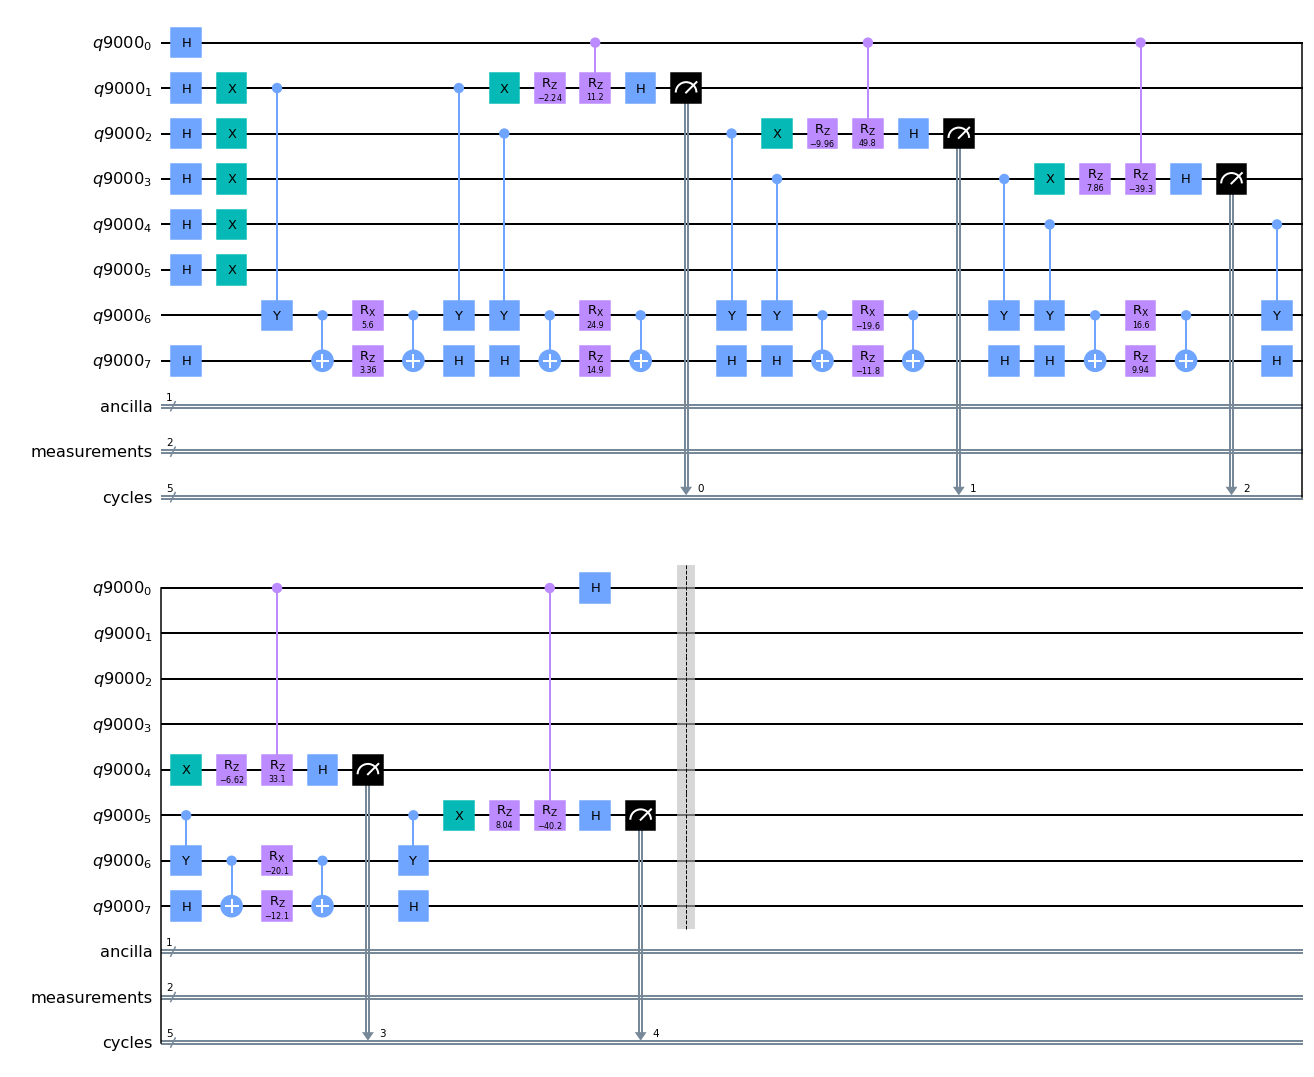

In [38]:
test[0].draw('mpl')

In [3]:
test = run_cont_two_state(5, 5, 2.5, 1.5, -1, 4, 2*np.pi, 20)
process_two_state_register(test, 5, 5, 2*np.pi, 20)

two state job b95664f74bb5456ea92801911120e646-16697418300608091
{'00000 01 0': 21, '00000 01 1': 7, '00000 11 0': 1}
29
{'00': 0.0, '01': 28, '10': 0.0, '11': 1}
{'00000 00 0': 2, '00000 00 1': 1, '00000 01 0': 20, '00000 01 1': 11, '00000 10 1': 1}
35
{'00': 3, '01': 31, '10': 1, '11': 0.0}
{'00000 00 1': 1, '00000 01 0': 12, '00000 01 1': 19, '00000 11 0': 1}
33
{'00': 1, '01': 31, '10': 0.0, '11': 1}
{'00000 00 1': 1, '00000 01 0': 11, '00000 01 1': 23}
35
{'00': 1, '01': 34, '10': 0.0, '11': 0.0}
{'00000 00 1': 1, '00000 01 0': 7, '00000 01 1': 26}
34
{'00': 1, '01': 33, '10': 0.0, '11': 0.0}
{'00000 00 1': 1, '00000 01 0': 6, '00000 01 1': 19, '00000 10 1': 1, '00000 11 0': 1}
28
{'00': 1, '01': 25, '10': 1, '11': 1}
{'00000 00 1': 2, '00000 01 0': 8, '00000 01 1': 24, '00000 11 1': 1}
35
{'00': 2, '01': 32, '10': 0.0, '11': 1}
{'00000 00 0': 1, '00000 01 0': 5, '00000 01 1': 23, '00000 10 1': 1, '00000 11 1': 1}
31
{'00': 1, '01': 28, '10': 1, '11': 1}
{'00000 00 1': 1, '00000 0

[-40.84046464217816,
 [7.965966739783011, -48.806431381961204],
 [-0.06896551724137931,
  0.17142857142857149,
  -5.551115123125783e-17,
  0.05714285714285705,
  0.05882352941176461,
  -2.7755575615628914e-17,
  0.05714285714285708,
  5.551115123125783e-17,
  0.06666666666666676,
  0.0,
  0.052631578947368474,
  0.22222222222222232,
  0.05714285714285705,
  0.07692307692307698,
  0.1777777777777777,
  0.19354838709677413,
  0.0465116279069768,
  0.1818181818181817,
  -5.551115123125783e-17,
  2.7755575615628914e-17,
  1.263157894736842,
  1.2352941176470589,
  0.896551724137931,
  0.9333333333333332,
  1.3571428571428572,
  1.25,
  1.0,
  1.2,
  1.0909090909090908,
  1.3333333333333333,
  1.103448275862069,
  1.4666666666666666,
  0.8888888888888888,
  1.4358974358974361,
  1.1515151515151516,
  1.3333333333333333,
  1.4,
  1.2380952380952381,
  1.0555555555555558,
  1.2,
  -0.7222222222222222,
  -0.6499999999999999,
  -0.96,
  -0.8666666666666667,
  -1.0,
  -1.0588235294117647,
  -0.7

In [6]:
test = run_cont_two_state(5, 5, 2.5, 1.5, -1, 4, 2*np.pi, 20)

two state job 55810795efe94252bcfc5839ce0e0a75-1669742097800131


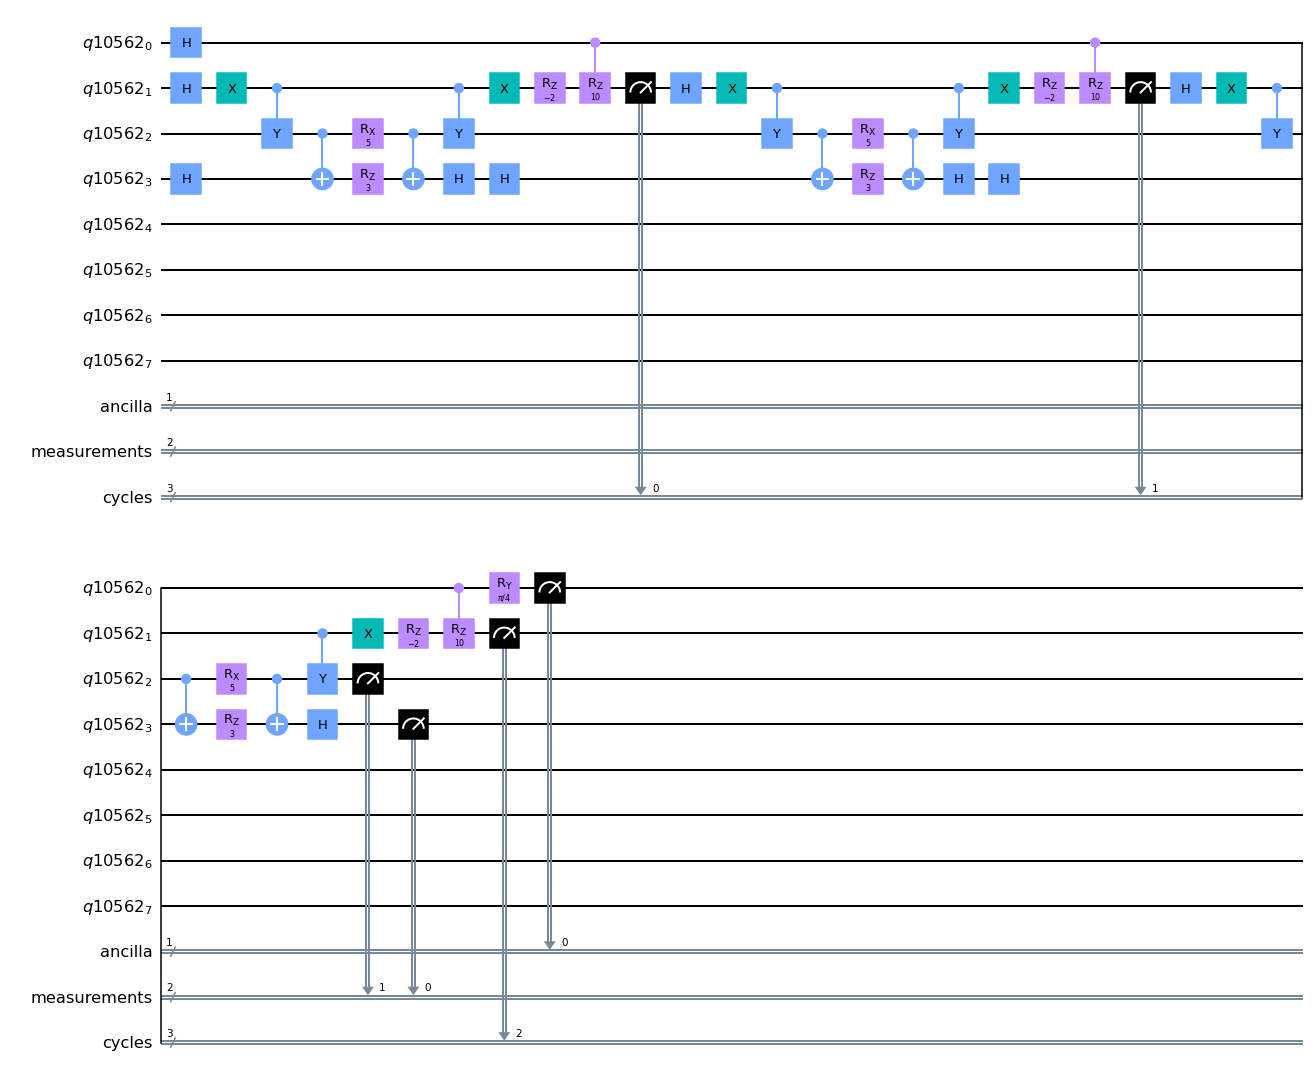

In [9]:
make_two_state_scan([1, 1, 1], 3, -1, 4, 2.5, 1.5, np.pi/4, "y").draw('mpl')

In [15]:
test = run_cont_two_state(5, 5, 2.5, 1.5, -1, 4, 2*np.pi, 20)
test[0][167].draw('mpl')

two state job 13d29757baed4235ace1863c6e7aae53-16697426604183838


TypeError: 'ManagedResults' object is not subscriptable

In [16]:
print(test)

[<qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000001A4C9987670>, [<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A472A26CB0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A472BCB250>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A472A26980>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A4C96C43A0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A472A27AC0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A472BCAFB0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A46F0229B0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A472A256C0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A472A38490>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A4C9633D60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001A4C9680670>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0

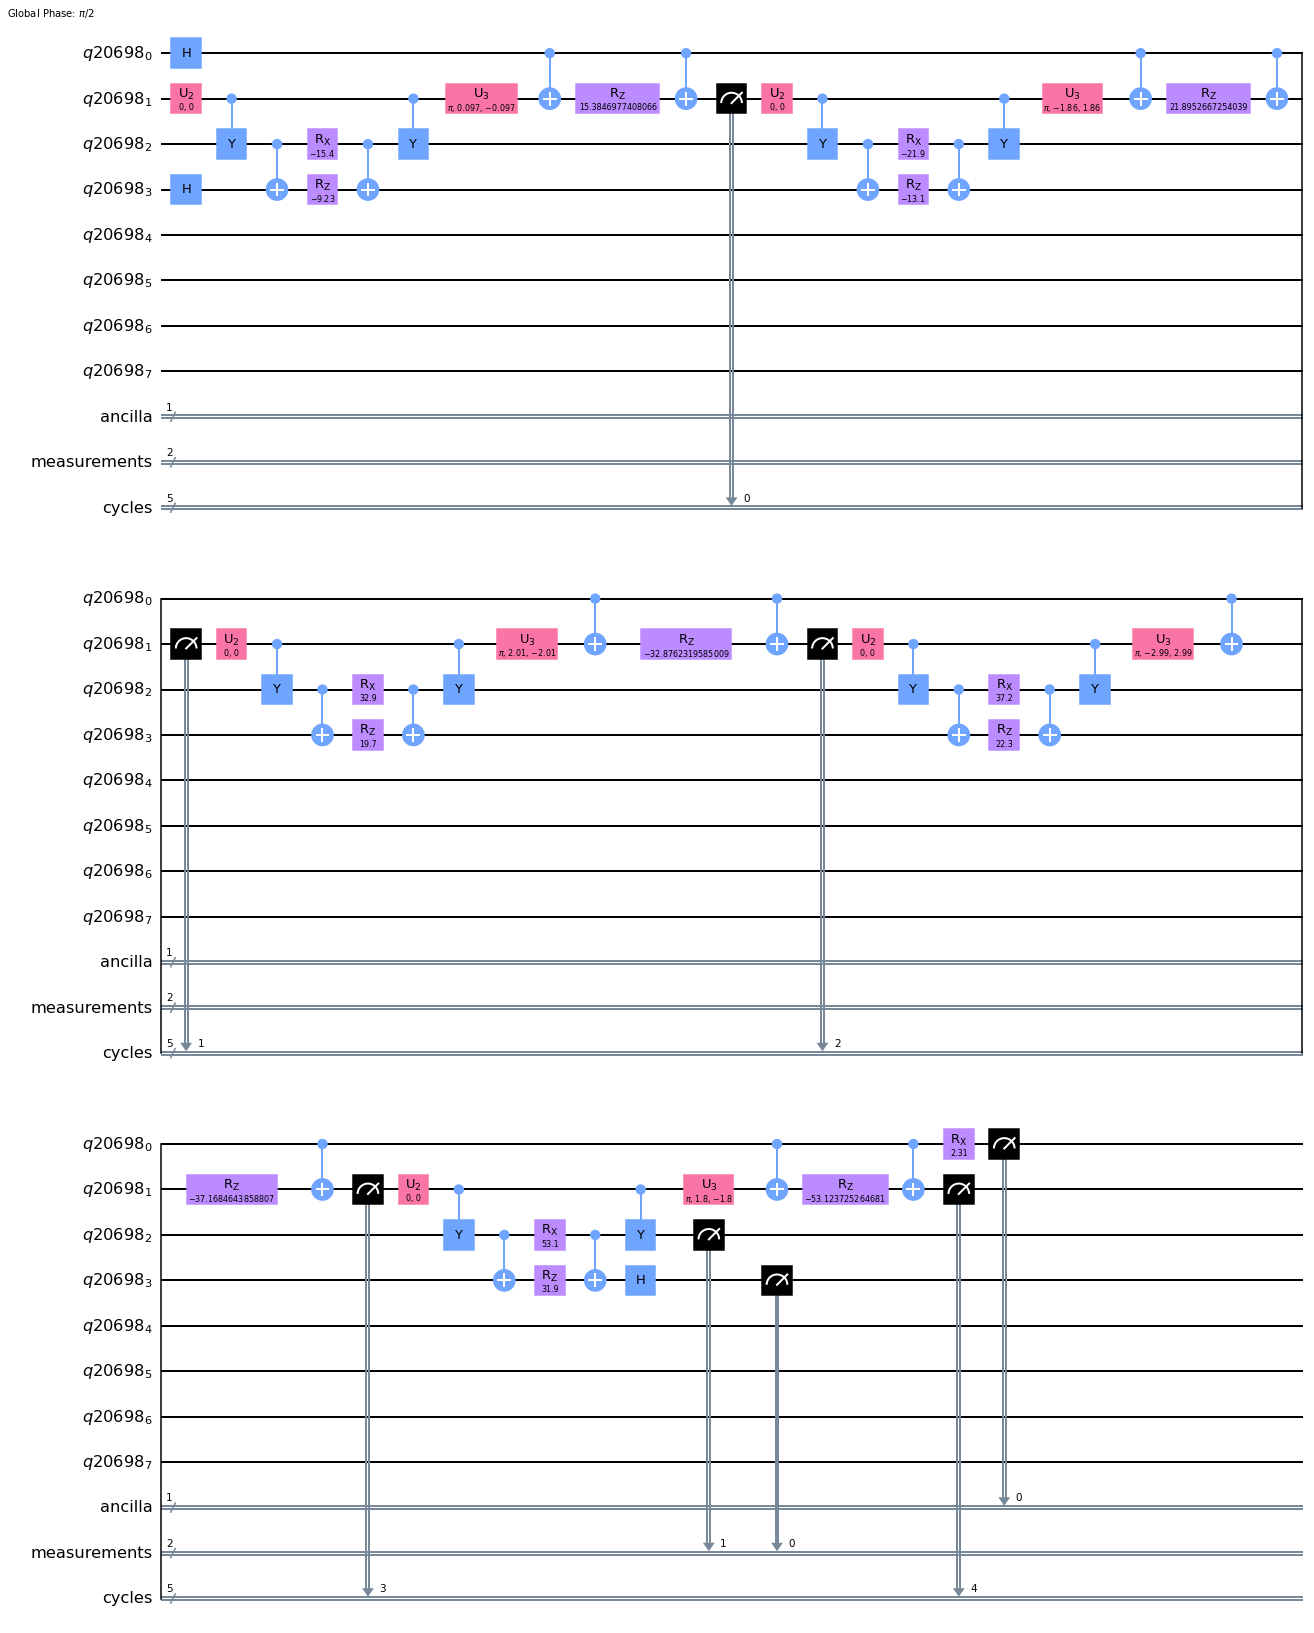

In [17]:
test[1][167].draw('mpl')

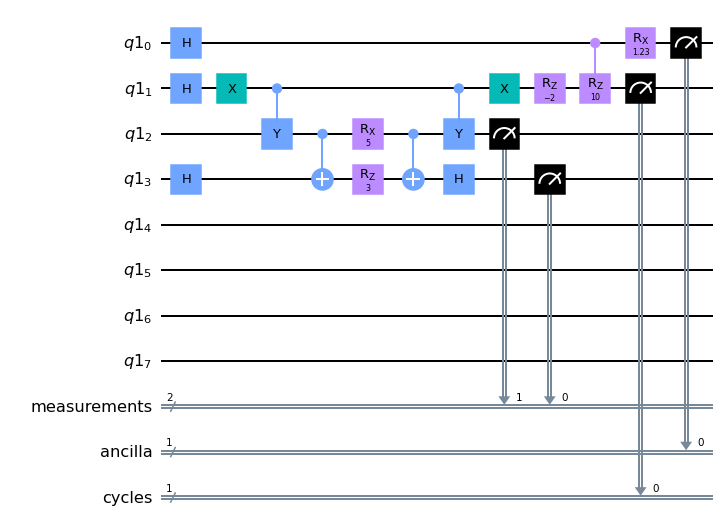

In [6]:
make_two_state_scan([1], 1, -1, 4, 2.5, 1.5, 1.23, 'x').draw('mpl')

two state job 0810b791a6ed45bfa2b80b2f7f9b9bd4-16722918976134253


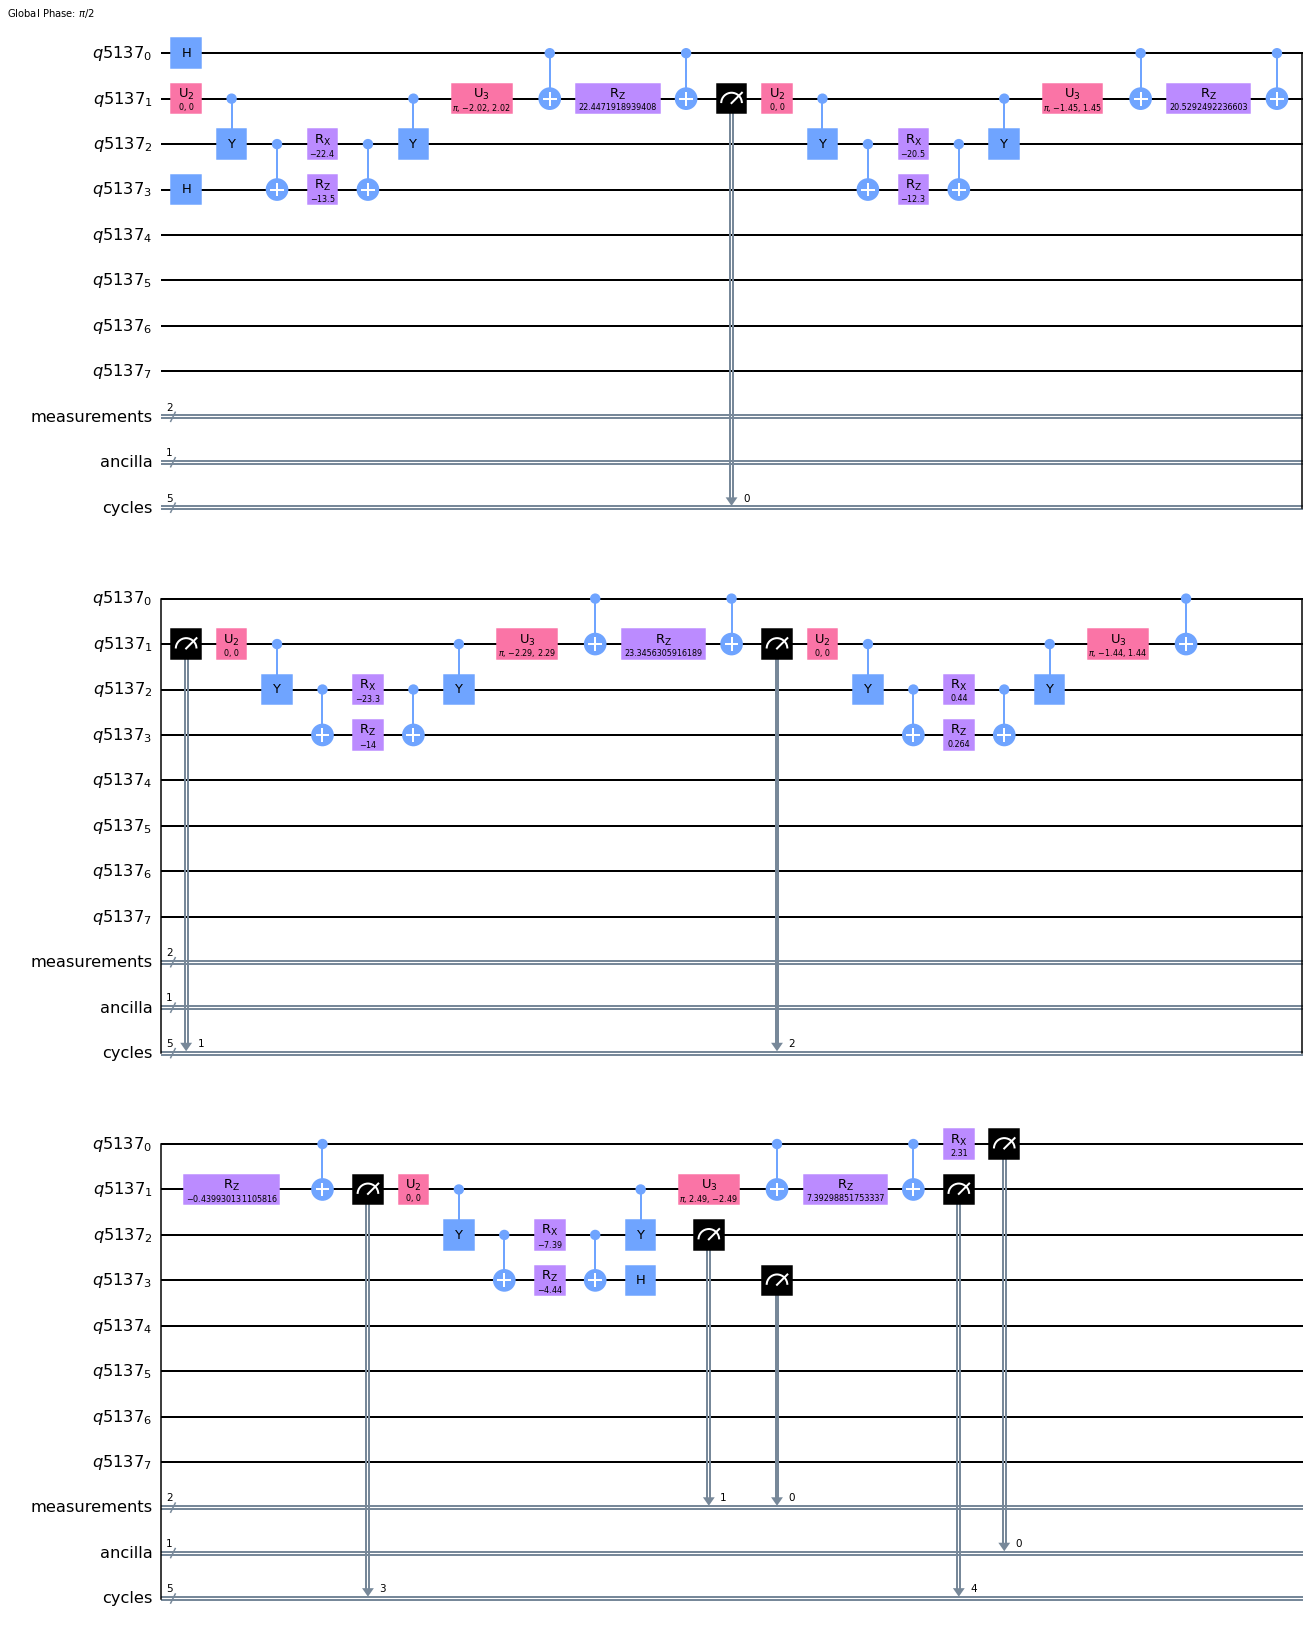

In [8]:
test = run_cont_two_state(5, 5, 2.5, 1.5, -1, 4, 2*np.pi, 20)
test[1][167].draw('mpl')

In [16]:
processed = process_two_state_register(test[0], 5, 5, 2*np.pi, 20)
print(processed)

{'00000 0 00': 5, '00000 0 01': 6, '00000 0 11': 2}
13
{'00000 1 00': 8, '00000 1 01': 11, '00000 1 10': 2}
21
{'00': 8, '01': 11, '10': 2, '11': 0.0}
{'00000 0 00': 6, '00000 0 01': 11, '00000 0 11': 2}
19
{'00000 1 00': 3, '00000 1 01': 9, '00000 1 10': 1, '00000 1 11': 3}
16
{'00': 3, '01': 9, '10': 1, '11': 3}
{'00000 0 00': 7, '00000 0 01': 10, '00000 0 10': 2, '00000 0 11': 2}
21
{'00000 1 00': 3, '00000 1 01': 8}
11
{'00': 3, '01': 8, '10': 0.0, '11': 0.0}
{'00000 0 00': 8, '00000 0 01': 14, '00000 0 10': 1}
23
{'00000 1 00': 3, '00000 1 01': 7, '00000 1 11': 2}
12
{'00': 3, '01': 7, '10': 0.0, '11': 2}
{'00000 0 00': 10, '00000 0 01': 10, '00000 0 10': 1, '00000 0 11': 5}
26
{'00000 1 00': 3, '00000 1 01': 1, '00000 1 11': 2}
6
{'00': 3, '01': 1, '10': 0.0, '11': 2}
{'00000 0 00': 14, '00000 0 01': 8, '00000 0 10': 3, '00000 0 11': 4}
29
{'00000 1 00': 3, '00000 1 01': 2}
5
{'00': 3, '01': 2, '10': 0.0, '11': 0.0}
{'00000 0 00': 8, '00000 0 01': 13, '00000 0 10': 6, '00000 0 11

C:\Users\Max\PycharmProjects\pythonProject\RodeoMethods.py:360: RuntimeWarning: invalid value encountered in double_scalars
  return [overallAverageExpectation, overallQubitExpectations, redundantAverageExpectations, redundantQubitExpectations]


[ 7.61904762e-01  0.00000000e+00  5.45454545e-01  1.66666667e-01
  3.33333333e-01  1.20000000e+00  1.33333333e+00  4.44444444e-01
  0.00000000e+00  7.20000000e-01  3.07692308e-01  7.20000000e-01
  4.54545455e-01  6.66666667e-01  6.00000000e-01  1.11111111e-01
  4.16666667e-01  4.34782609e-01  8.23529412e-01  4.44444444e-01
 -6.66666667e-01 -1.68000000e+00 -1.53846154e+00 -1.55555556e+00
 -1.03448276e+00 -1.61538462e+00 -1.44444444e+00 -1.08333333e+00
 -1.14285714e+00 -1.81818182e+00 -1.69230769e+00 -1.27272727e+00
 -2.00000000e+00 -2.00000000e+00 -1.66666667e+00 -1.50000000e+00
 -1.84615385e+00 -2.00000000e+00 -9.09090909e-01 -1.81818182e+00
  0.00000000e+00  1.81818182e-01  0.00000000e+00 -3.33333333e-01
  1.00000000e+00  0.00000000e+00  5.00000000e-01 -1.33333333e+00
  4.00000000e-01  6.15384615e-01 -1.11022302e-16  5.60000000e-01
 -1.05263158e-01  6.06060606e-02 -7.69230769e-02 -2.14285714e-01
  8.00000000e-02  4.00000000e-01 -1.66666667e-01 -1.33333333e-01
  5.00000000e-01  4.21052

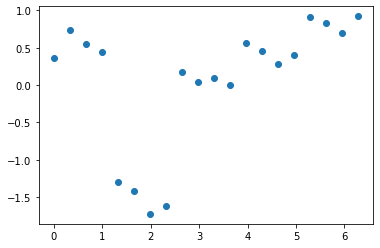

In [24]:
testRange = np.linspace(0, 2*np.pi, 20)
deNand = np.nan_to_num(processed[2])
print(deNand)
print(len(deNand))
averaged = np.mean(np.array(deNand).reshape(-1, 5), axis=1)
print(averaged)

plt.scatter(testRange, averaged)
plt.show()

two state job b6d247cf5d084b00afb5f7eb60d2b657-1672365676022559


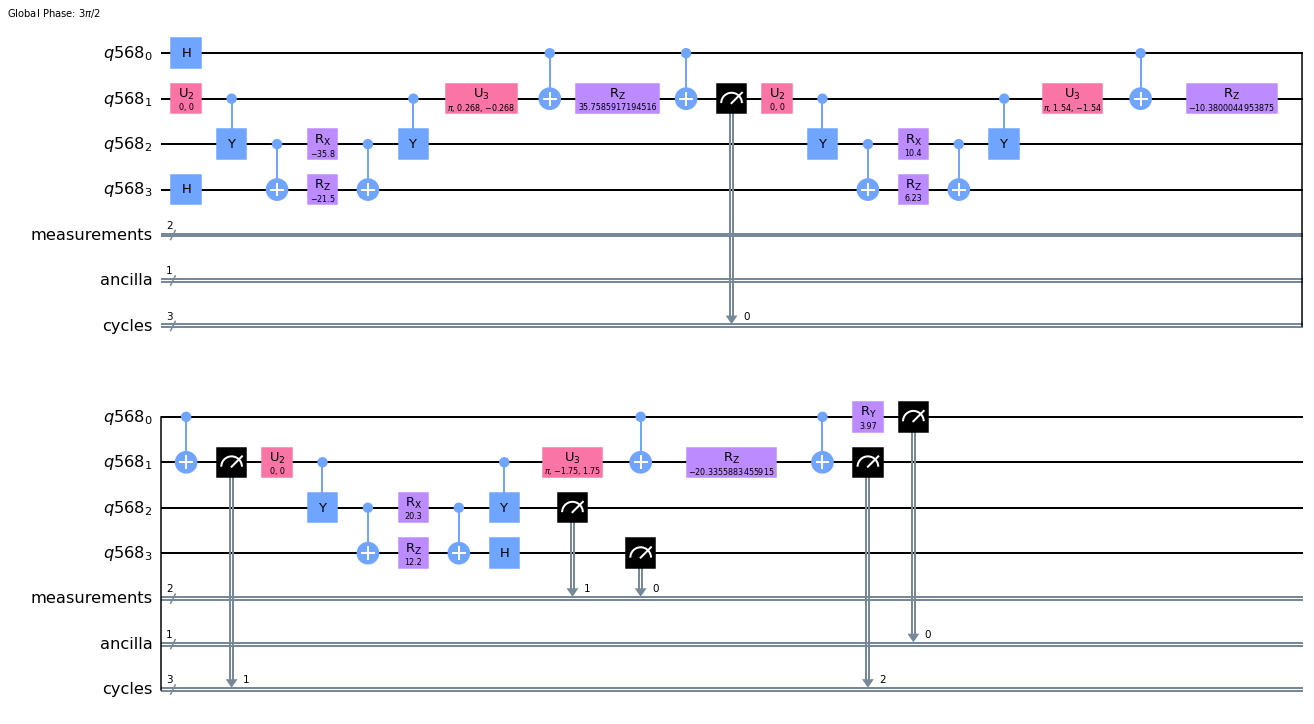

In [5]:
test = run_cont_two_state(3, 1, 2.5, 1.5, -1, 4, 2*np.pi, 20)
test[1][12].draw('mpl')

In [12]:
processed = process_two_state_register(test[0], 3, 1, 2 * np.pi, 20)
print(processed)


{'000 0 01': 40, '000 0 11': 25}
65
{'000 1 01': 41, '000 1 10': 1, '000 1 11': 24}
66
{'00': 0.0, '01': 40, '10': 0.0, '11': 25}
{'00': 0.0, '01': 41, '10': 1, '11': 24}
0
0
0
1
1
0
1
1
{'000 0 01': 35, '000 0 11': 12}
47
{'000 1 00': 1, '000 1 01': 57, '000 1 11': 28}
86
{'00': 0.0, '01': 35, '10': 0.0, '11': 12}
{'00': 1, '01': 57, '10': 0.0, '11': 28}
0
0
0
1
1
0
1
1
{'000 0 01': 24, '000 0 11': 20}
44
{'000 1 01': 52, '000 1 11': 29}
81
{'00': 0.0, '01': 24, '10': 0.0, '11': 20}
{'00': 0.0, '01': 52, '10': 0.0, '11': 29}
0
0
0
1
1
0
1
1
{'000 0 01': 32, '000 0 11': 15}
47
{'000 1 01': 58, '000 1 11': 22}
80
{'00': 0.0, '01': 32, '10': 0.0, '11': 15}
{'00': 0.0, '01': 58, '10': 0.0, '11': 22}
0
0
0
1
1
0
1
1
{'000 0 00': 1, '000 0 01': 29, '000 0 11': 12}
42
{'000 1 01': 58, '000 1 11': 33}
91
{'00': 1, '01': 29, '10': 0.0, '11': 12}
{'00': 0.0, '01': 58, '10': 0.0, '11': 33}
0
0
0
1
1
0
1
1
{'000 0 01': 27, '000 0 11': 13}
40
{'000 1 00': 1, '000 1 01': 53, '000 1 11': 30}
84
{'00

[-0.72727273 -0.62790698 -0.71604938 -0.55       -0.72527473 -0.69047619
 -0.72       -0.55172414 -0.68571429 -0.72222222 -0.57971014 -0.52459016
 -0.45714286 -1.02439024 -0.68571429 -0.61538462 -0.58181818 -0.61818182
 -0.65384615 -0.53521127]
20
[-0.72727273 -0.62790698 -0.71604938 -0.55       -0.72527473 -0.69047619
 -0.72       -0.55172414 -0.68571429 -0.72222222 -0.57971014 -0.52459016
 -0.45714286 -1.02439024 -0.68571429 -0.61538462 -0.58181818 -0.61818182
 -0.65384615 -0.53521127]


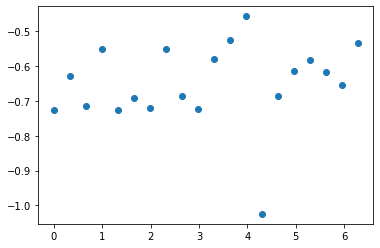

In [9]:
testRange = np.linspace(0, 2*np.pi, 20)
deNand = np.nan_to_num(processed[2])
print(deNand)
print(len(deNand))
averaged = np.mean(np.array(deNand).reshape(-1, 1), axis=1)
print(averaged)

plt.scatter(testRange, averaged)
plt.show()

In [4]:
test = run_cont_two_state(3, 1, 2.5, 1.5, -1, 4, np.pi, 10)

two state job cb7971a870184d4abc6b6e472222d8c6-1673270599924846


In [5]:
process_energy_controlled_two_state(test[0], 3, 10, 1)

ancilla = 0
86
{'000 0 00': 50, '000 0 01': 32, '000 0 10': 3, '000 0 11': 1}
{'00': 50, '01': 32, '10': 3, '11': 1}
ancilla = 1
48
{'000 1 00': 26, '000 1 01': 20, '000 1 10': 2}
{'00': 26, '01': 20, '10': 2, '11': 0.0}
ancilla = 0
46
{'000 0 00': 27, '000 0 01': 17, '000 0 10': 2}
{'00': 27, '01': 17, '10': 2, '11': 0.0}
ancilla = 1
85
{'000 1 00': 47, '000 1 01': 36, '000 1 10': 2}
{'00': 47, '01': 36, '10': 2, '11': 0.0}
ancilla = 0
39
{'000 0 00': 21, '000 0 01': 15, '000 0 10': 2, '000 0 11': 1}
{'00': 21, '01': 15, '10': 2, '11': 1}
ancilla = 1
88
{'000 1 00': 45, '000 1 01': 41, '000 1 10': 1, '000 1 11': 1}
{'00': 45, '01': 41, '10': 1, '11': 1}
ancilla = 0
11
{'000 0 00': 6, '000 0 01': 5}
{'00': 6, '01': 5, '10': 0.0, '11': 0.0}
ancilla = 1
119
{'000 1 00': 50, '000 1 01': 63, '000 1 10': 4, '000 1 11': 2}
{'00': 50, '01': 63, '10': 4, '11': 2}
ancilla = 0
10
{'000 0 00': 6, '000 0 01': 3, '000 0 11': 1}
{'00': 6, '01': 3, '10': 0.0, '11': 1}
ancilla = 1
110
{'000 1 00': 54,

two state job 8e0ecbac424f44feabf941a0ed55c1a4-16732847450722117


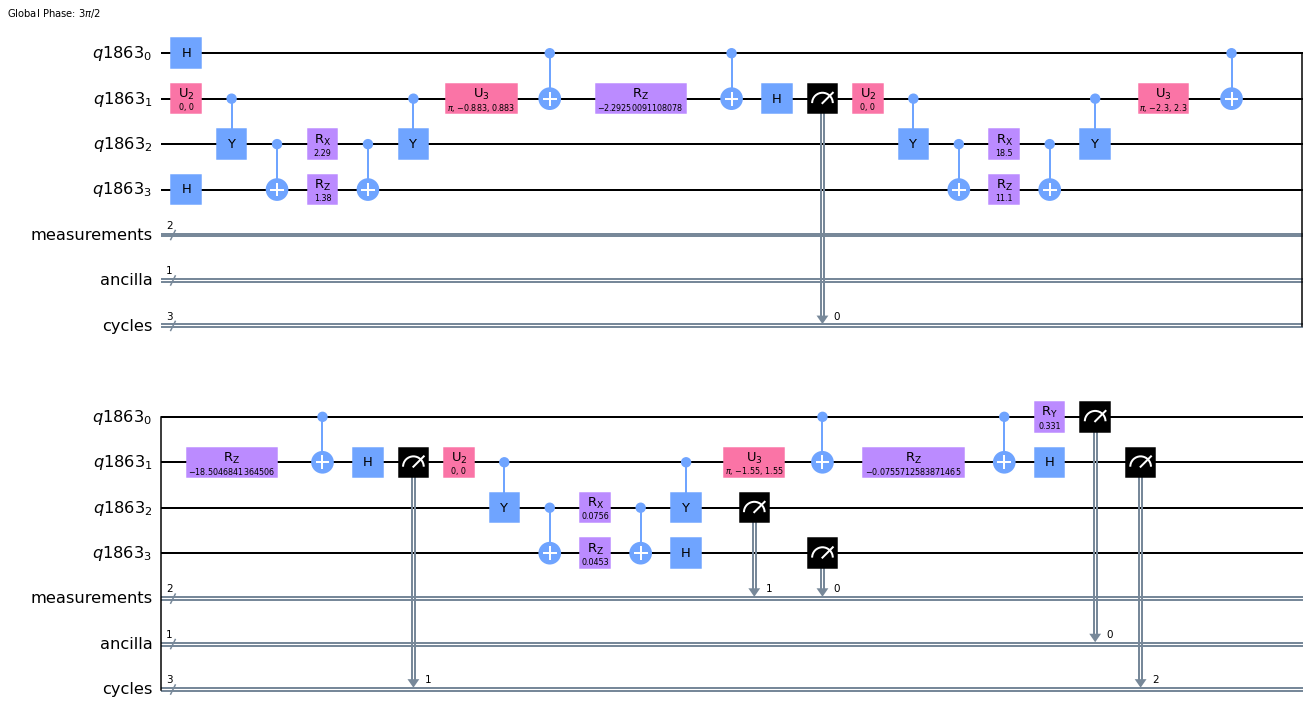

In [28]:
test = run_cont_two_state(3, 1, 2.5, 1.5, -1, 4, 2*np.pi, 20)
test[1][1].draw('mpl')

In [34]:
process_energy_controlled_two_state(test[0], 3, 20, 1)

total
362
ancilla = 0
187
{'000 0 00': 14, '000 0 10': 71, '000 0 11': 102}
{'00': 14, '01': 0.0, '10': 71, '11': 102}
ancilla = 1
175
{'000 1 00': 8, '000 1 01': 2, '000 1 10': 54, '000 1 11': 111}
{'00': 8, '01': 2, '10': 54, '11': 111}
total
361
ancilla = 0
239
{'000 0 00': 7, '000 0 10': 73, '000 0 11': 159}
{'00': 7, '01': 0.0, '10': 73, '11': 159}
ancilla = 1
122
{'000 1 00': 15, '000 1 10': 39, '000 1 11': 68}
{'00': 15, '01': 0.0, '10': 39, '11': 68}
total
382
ancilla = 0
297
{'000 0 00': 4, '000 0 10': 105, '000 0 11': 188}
{'00': 4, '01': 0.0, '10': 105, '11': 188}
ancilla = 1
85
{'000 1 00': 22, '000 1 10': 26, '000 1 11': 37}
{'00': 22, '01': 0.0, '10': 26, '11': 37}
total
361
ancilla = 0
307
{'000 0 00': 5, '000 0 10': 105, '000 0 11': 197}
{'00': 5, '01': 0.0, '10': 105, '11': 197}
ancilla = 1
54
{'000 1 00': 20, '000 1 01': 2, '000 1 10': 14, '000 1 11': 18}
{'00': 20, '01': 2, '10': 14, '11': 18}
total
349
ancilla = 0
312
{'000 0 10': 104, '000 0 11': 208}
{'00': 0.0, '

In [30]:
processed = process_two_state_register(test[0], 3, 1, 2*np.pi, 20)
print(processed)

{'000 0 00': 14, '000 0 10': 71, '000 0 11': 102}
187
{'000 1 00': 8, '000 1 01': 2, '000 1 10': 54, '000 1 11': 111}
175
{'00': 14, '01': 0.0, '10': 71, '11': 102}
{'00': 8, '01': 2, '10': 54, '11': 111}
0
0
0
1
1
0
1
1
{'000 0 00': 7, '000 0 10': 73, '000 0 11': 159}
239
{'000 1 00': 15, '000 1 10': 39, '000 1 11': 68}
122
{'00': 7, '01': 0.0, '10': 73, '11': 159}
{'00': 15, '01': 0.0, '10': 39, '11': 68}
0
0
0
1
1
0
1
1
{'000 0 00': 4, '000 0 10': 105, '000 0 11': 188}
297
{'000 1 00': 22, '000 1 10': 26, '000 1 11': 37}
85
{'00': 4, '01': 0.0, '10': 105, '11': 188}
{'00': 22, '01': 0.0, '10': 26, '11': 37}
0
0
0
1
1
0
1
1
{'000 0 00': 5, '000 0 10': 105, '000 0 11': 197}
307
{'000 1 00': 20, '000 1 01': 2, '000 1 10': 14, '000 1 11': 18}
54
{'00': 5, '01': 0.0, '10': 105, '11': 197}
{'00': 20, '01': 2, '10': 14, '11': 18}
0
0
0
1
1
0
1
1
{'000 0 10': 104, '000 0 11': 208}
312
{'000 1 00': 34, '000 1 10': 1, '000 1 11': 2}
37
{'00': 0.0, '01': 0.0, '10': 104, '11': 208}
{'00': 34, '

[-1.17714286 -0.86885246 -0.35294118  0.07407407  1.72972973  1.73333333
  0.35897436 -0.57142857 -0.96       -0.81290323 -0.99521531 -1.13857678
 -1.24344569 -1.29518072 -1.22898551 -1.22424242 -1.19620253 -1.06227106
 -1.05263158 -0.80503145]
20
[-1.17714286 -0.86885246 -0.35294118  0.07407407  1.72972973  1.73333333
  0.35897436 -0.57142857 -0.96       -0.81290323 -0.99521531 -1.13857678
 -1.24344569 -1.29518072 -1.22898551 -1.22424242 -1.19620253 -1.06227106
 -1.05263158 -0.80503145]


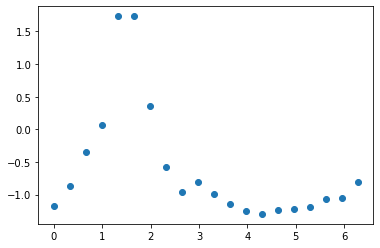

In [31]:
testRange = np.linspace(0, 2*np.pi, 20)
deNand = np.nan_to_num(processed[2])
print(deNand)
print(len(deNand))
averaged = np.mean(np.array(deNand).reshape(-1, 1), axis=1)
print(averaged)

plt.scatter(testRange, averaged)
plt.show()

two state job 34d0aa7be9644a97bc9d33f7557226da-16738746666610177


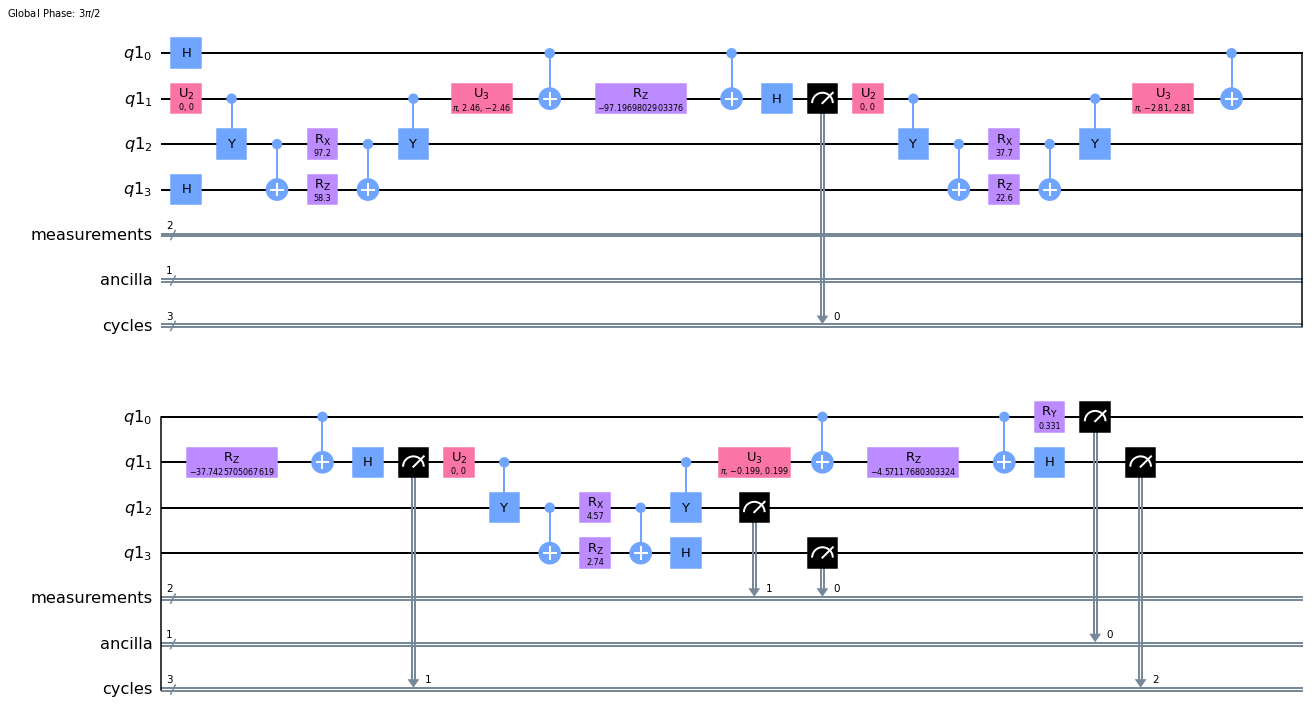

In [4]:
test = run_cont_two_state(3, 1, 2.5, 1.5, -1, 4, 2*np.pi, 20)
test[1][1].draw('mpl')

In [7]:
processed = process_energy_controlled_two_state(test[0], 3, 20, 1)
print(processed)

total
274
ancilla = 0
141
{'000 0 00': 43, '000 0 01': 51, '000 0 10': 12, '000 0 11': 35}
{'00': 43, '01': 51, '10': 12, '11': 35}
ancilla = 1
133
{'000 1 00': 33, '000 1 01': 45, '000 1 10': 14, '000 1 11': 41}
{'00': 33, '01': 45, '10': 14, '11': 41}
expectations: 
-0.11347517730496454
0.12030075187969924
total
254
ancilla = 0
126
{'000 0 00': 35, '000 0 01': 37, '000 0 10': 11, '000 0 11': 43}
{'00': 35, '01': 37, '10': 11, '11': 43}
ancilla = 1
128
{'000 1 00': 41, '000 1 01': 57, '000 1 10': 10, '000 1 11': 20}
{'00': 41, '01': 57, '10': 10, '11': 20}
expectations: 
0.12698412698412698
-0.328125
total
298
ancilla = 0
121
{'000 0 00': 21, '000 0 01': 20, '000 0 10': 26, '000 0 11': 54}
{'00': 21, '01': 20, '10': 26, '11': 54}
ancilla = 1
177
{'000 1 00': 56, '000 1 01': 94, '000 1 10': 12, '000 1 11': 15}
{'00': 56, '01': 94, '10': 12, '11': 15}
expectations: 
0.5454545454545454
-0.46327683615819215
total
267
ancilla = 0
99
{'000 0 00': 8, '000 0 01': 4, '000 0 10': 27, '000 0 11'

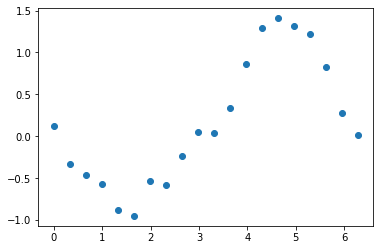

In [10]:
testRange = np.linspace(0, 2*np.pi, 20)
deNand = np.nan_to_num(processed[1])
averaged = np.mean(np.array(deNand).reshape(-1, 1), axis=1)

plt.scatter(testRange, averaged)
plt.show()

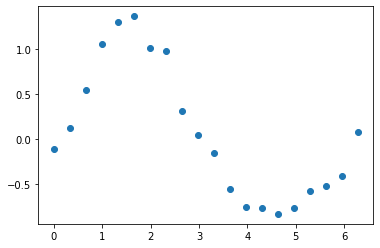

In [11]:
testRange = np.linspace(0, 2*np.pi, 20)
deNand = np.nan_to_num(processed[0])
averaged = np.mean(np.array(deNand).reshape(-1, 1), axis=1)

plt.scatter(testRange, averaged)
plt.show()

In [23]:
# test = run_cont_two_state(5, 5, 2.5, 1.5, -1, 4, 2*np.pi, 60)
# jobID = 63c54f43447dd382e03b5fa8
processed = process_energy_controlled_two_state(test[0], 5, 60, 5)

total
241
ancilla = 0
126
{'00000 0 00': 37, '00000 0 01': 29, '00000 0 10': 33, '00000 0 11': 27}
{'00': 37, '01': 29, '10': 33, '11': 27}
ancilla = 1
115
{'00000 1 00': 11, '00000 1 01': 42, '00000 1 10': 50, '00000 1 11': 12}
{'00': 11, '01': 42, '10': 50, '11': 12}
expectations: 
-0.15873015873015878
0.01739130434782607
total
269
ancilla = 0
134
{'00000 0 00': 26, '00000 0 01': 26, '00000 0 10': 42, '00000 0 11': 40}
{'00': 26, '01': 26, '10': 42, '11': 40}
ancilla = 1
135
{'00000 1 00': 11, '00000 1 01': 48, '00000 1 10': 52, '00000 1 11': 24}
{'00': 11, '01': 48, '10': 52, '11': 24}
expectations: 
0.20895522388059695
0.1925925925925926
total
276
ancilla = 0
139
{'00000 0 00': 25, '00000 0 01': 21, '00000 0 10': 53, '00000 0 11': 40}
{'00': 25, '01': 21, '10': 53, '11': 40}
ancilla = 1
137
{'00000 1 00': 15, '00000 1 01': 69, '00000 1 10': 43, '00000 1 11': 10}
{'00': 15, '01': 69, '10': 43, '11': 10}
expectations: 
0.2158273381294964
-0.07299270072992703
total
275
ancilla = 0
135

60


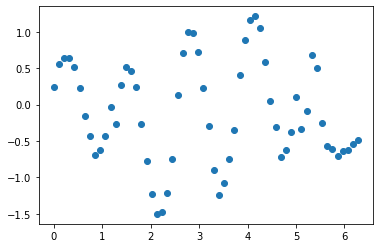

In [24]:
testRange = np.linspace(0, 2*np.pi, 60)
print(len(processed[0]))
plt.scatter(testRange, processed[0])
plt.show()

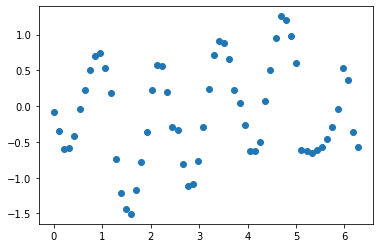

In [25]:
plt.scatter(testRange, processed[1])
plt.show()

In [32]:
test = run_cont_two_state(5, 15, 2.5, 1.5, -1, 4, 2*np.pi, 20)
processed = process_energy_controlled_two_state(test[0], 5, 20, 15)

two state job 51909db8ae344fe5afb55a747fccfdfb-1673875804597233
total
403
ancilla = 0
219
{'00000 0 00': 2, '00000 0 10': 143, '00000 0 11': 74}
{'00': 2, '01': 0.0, '10': 143, '11': 74}
ancilla = 1
184
{'00000 1 00': 1, '00000 1 01': 1, '00000 1 10': 130, '00000 1 11': 52}
{'00': 1, '01': 1, '10': 130, '11': 52}
expectations: 
0.6575342465753424
0.5543478260869564
total
420
ancilla = 0
296
{'00000 0 00': 1, '00000 0 10': 185, '00000 0 11': 110}
{'00': 1, '01': 0.0, '10': 185, '11': 110}
ancilla = 1
124
{'00000 1 00': 3, '00000 1 01': 1, '00000 1 10': 84, '00000 1 11': 36}
{'00': 3, '01': 1, '10': 84, '11': 36}
expectations: 
0.7364864864864864
0.5322580645161291
total
398
ancilla = 0
318
{'00000 0 10': 222, '00000 0 11': 96}
{'00': 0.0, '01': 0.0, '10': 222, '11': 96}
ancilla = 1
80
{'00000 1 00': 2, '00000 1 10': 58, '00000 1 11': 20}
{'00': 2, '01': 0.0, '10': 58, '11': 20}
expectations: 
0.6037735849056604
0.45
total
439
ancilla = 0
393
{'00000 0 10': 255, '00000 0 11': 138}
{'00':

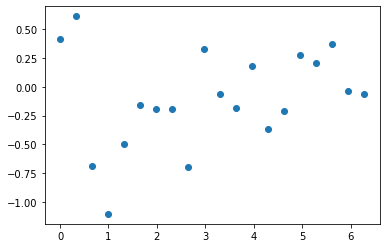

In [33]:
testRange = np.linspace(0, 2*np.pi, 20)
plt.scatter(testRange, processed[0])
plt.show()

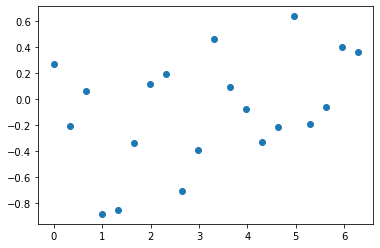

In [34]:
plt.scatter(testRange, processed[1])
plt.show()

In [31]:
print(processed)

[array([ 1.29524815e+00,  2.99475029e-01, -6.69168145e-02, -1.83009935e-01,
        3.17136188e-01,  6.28612427e-04, -3.21415972e-01, -8.07599806e-02,
        2.14908054e-01,  1.61111257e-01, -4.77798749e-01, -1.09919590e+00,
        7.95032973e-01,  3.76998246e-01, -1.69926266e-01, -1.88777865e-01,
        2.32693355e-01,  1.02223946e-01, -3.26062746e-01, -3.21281972e-01]), array([ 0.89701451,  0.18720006, -0.03111912,  0.24774026, -0.10807618,
       -0.22188756,  0.03631815,  0.14258897, -0.14039744, -0.1411723 ,
       -0.13992514, -0.72141332,  0.37905031, -0.01977474,  0.26731394,
        0.21479538, -0.13596083, -0.29740599, -0.09465695,  0.12318771])]


In [42]:
test = run_cont_two_state(5, 15, 2.5, 1.5, -1, 4, 2*np.pi, 60)
processed = process_energy_controlled_two_state(test[0], 5, 60, 15)

two state job 553edc105581403f81674c37d26fa335-16738768504710045
total
344
ancilla = 0
183
{'00000 0 00': 7, '00000 0 01': 4, '00000 0 10': 70, '00000 0 11': 102}
{'00': 7, '01': 4, '10': 70, '11': 102}
ancilla = 1
161
{'00000 1 00': 5, '00000 1 01': 7, '00000 1 10': 86, '00000 1 11': 63}
{'00': 5, '01': 7, '10': 86, '11': 63}
expectations: 
1.0382513661202184
0.7204968944099379
total
332
ancilla = 0
164
{'00000 0 00': 4, '00000 0 01': 4, '00000 0 10': 59, '00000 0 11': 97}
{'00': 4, '01': 4, '10': 59, '11': 97}
ancilla = 1
168
{'00000 1 00': 9, '00000 1 01': 5, '00000 1 10': 65, '00000 1 11': 89}
{'00': 9, '01': 5, '10': 65, '11': 89}
expectations: 
1.1341463414634145
0.9523809523809524
total
307
ancilla = 0
155
{'00000 0 00': 9, '00000 0 01': 5, '00000 0 10': 62, '00000 0 11': 79}
{'00': 9, '01': 5, '10': 62, '11': 79}
ancilla = 1
152
{'00000 1 00': 8, '00000 1 01': 4, '00000 1 10': 68, '00000 1 11': 72}
{'00': 8, '01': 4, '10': 68, '11': 72}
expectations: 
0.9032258064516129
0.84210

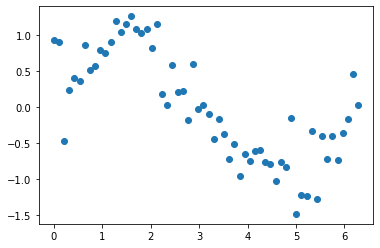

In [43]:
testRange = np.linspace(0, 2*np.pi, 60)
plt.scatter(testRange, processed[0])
plt.show()

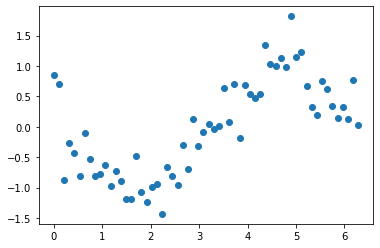

In [45]:
testRange = np.linspace(0, 2*np.pi, 60)
plt.scatter(testRange, processed[1])
plt.show()

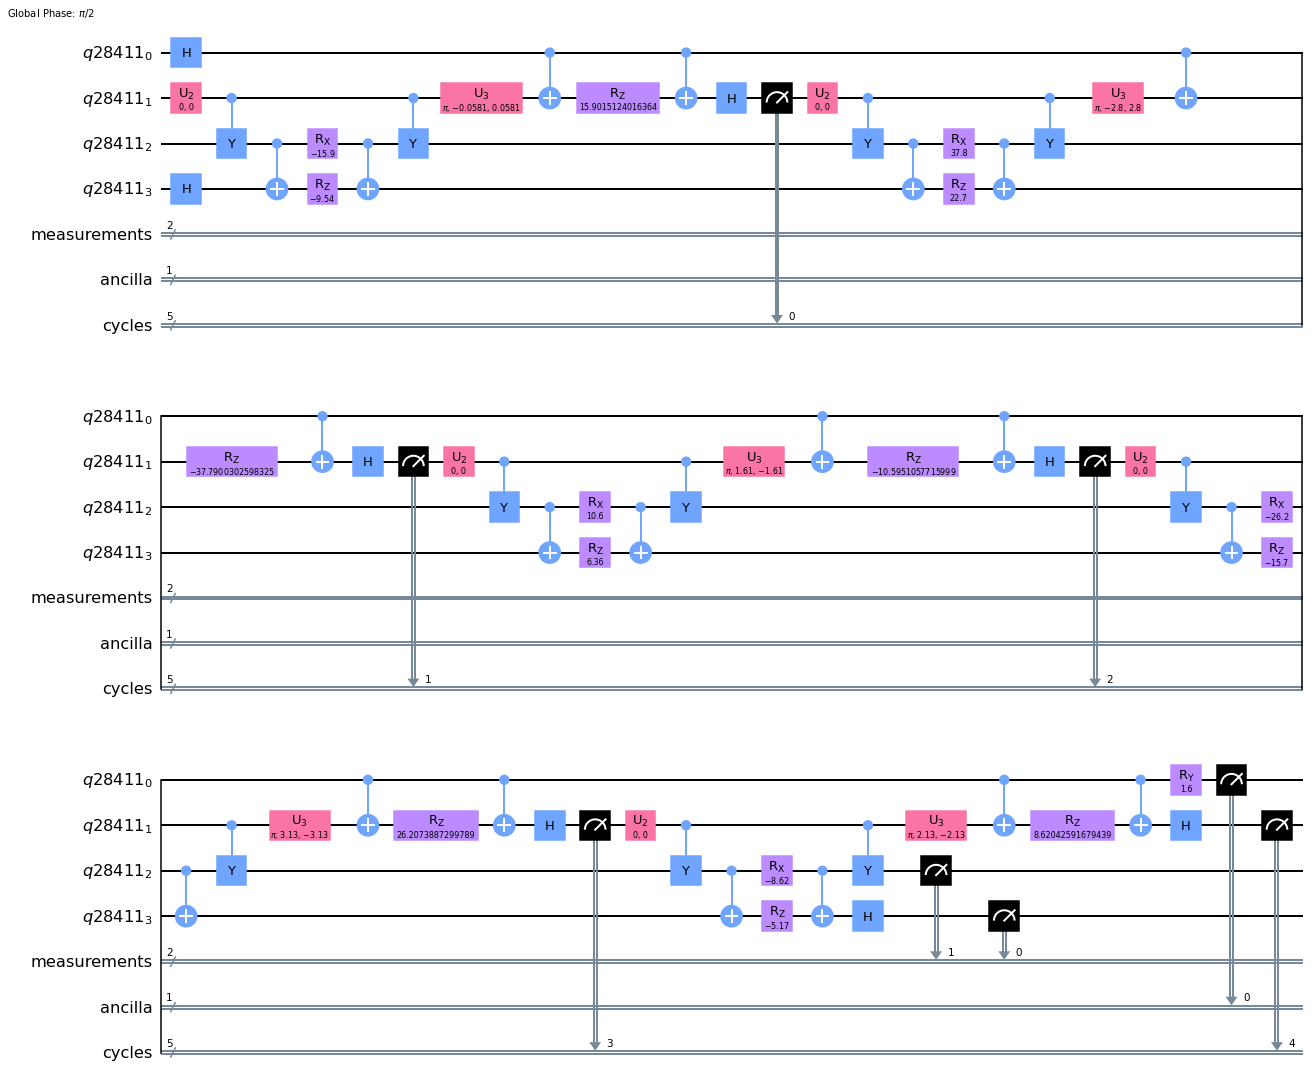

In [39]:
test[1][15].draw('mpl')

In [46]:
test = run_cont_two_state(5, 30, 2.5, 1.5, -1, 4, 2*np.pi, 10)
processed = process_energy_controlled_two_state(test[0], 5, 10, 30)

two state job e8044987e30444af9162c224a5c2d14e-16738770074542675
total
257
ancilla = 0
143
{'00000 0 00': 20, '00000 0 01': 47, '00000 0 10': 29, '00000 0 11': 47}
{'00': 20, '01': 47, '10': 29, '11': 47}
ancilla = 1
114
{'00000 1 00': 16, '00000 1 01': 41, '00000 1 10': 24, '00000 1 11': 33}
{'00': 16, '01': 41, '10': 24, '11': 33}
expectations: 
0.37762237762237755
0.29824561403508776
total
272
ancilla = 0
127
{'00000 0 00': 20, '00000 0 01': 46, '00000 0 10': 20, '00000 0 11': 41}
{'00': 20, '01': 46, '10': 20, '11': 41}
ancilla = 1
145
{'00000 1 00': 17, '00000 1 01': 67, '00000 1 10': 31, '00000 1 11': 30}
{'00': 17, '01': 67, '10': 31, '11': 30}
expectations: 
0.3307086614173228
0.1793103448275862
total
252
ancilla = 0
117
{'00000 0 00': 24, '00000 0 01': 42, '00000 0 10': 12, '00000 0 11': 39}
{'00': 24, '01': 42, '10': 12, '11': 39}
ancilla = 1
135
{'00000 1 00': 17, '00000 1 01': 45, '00000 1 10': 34, '00000 1 11': 39}
{'00': 17, '01': 45, '10': 34, '11': 39}
expectations: 
0.

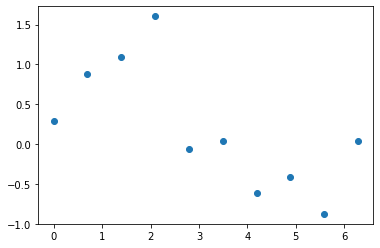

In [47]:
testRange = np.linspace(0, 2*np.pi, 10)
plt.scatter(testRange, processed[0])
plt.show()

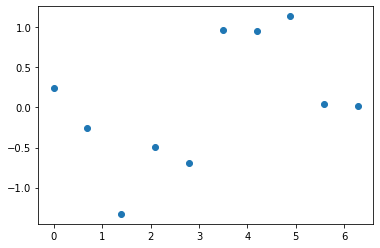

In [48]:
plt.scatter(testRange, processed[1])
plt.show()

In [3]:
test = run_cont_two_state(5, 30, 2.5, 1.5, -1, 4, 2*np.pi, 30)
processed = process_energy_controlled_two_state(test[0], 5, 10, 30)

two state job 45570454fceb4422af4fe6ac063e91c5-16744286833839924
total
257
ancilla = 0
120
{'00000 0 00': 22, '00000 0 01': 17, '00000 0 10': 57, '00000 0 11': 24}
{'00': 22, '01': 17, '10': 57, '11': 24}
ancilla = 1
137
{'00000 1 00': 44, '00000 1 01': 15, '00000 1 10': 38, '00000 1 11': 40}
{'00': 44, '01': 15, '10': 38, '11': 40}
expectations: 
0.03333333333333338
-0.058394160583941646
total
295
ancilla = 0
179
{'00000 0 00': 75, '00000 0 01': 6, '00000 0 10': 9, '00000 0 11': 89}
{'00': 75, '01': 6, '10': 9, '11': 89}
ancilla = 1
116
{'00000 1 00': 27, '00000 1 01': 21, '00000 1 10': 31, '00000 1 11': 37}
{'00': 27, '01': 21, '10': 31, '11': 37}
expectations: 
0.15642458100558654
0.17241379310344834
total
268
ancilla = 0
133
{'00000 0 00': 22, '00000 0 01': 35, '00000 0 10': 37, '00000 0 11': 39}
{'00': 22, '01': 35, '10': 37, '11': 39}
ancilla = 1
135
{'00000 1 00': 30, '00000 1 01': 27, '00000 1 10': 33, '00000 1 11': 45}
{'00': 30, '01': 27, '10': 33, '11': 45}
expectations: 
0.

total
257
ancilla = 0
120
{'00000 0 00': 22, '00000 0 01': 17, '00000 0 10': 57, '00000 0 11': 24}
{'00': 22, '01': 17, '10': 57, '11': 24}
ancilla = 1
137
{'00000 1 00': 44, '00000 1 01': 15, '00000 1 10': 38, '00000 1 11': 40}
{'00': 44, '01': 15, '10': 38, '11': 40}
expectations: 
0.03333333333333338
-0.058394160583941646
total
295
ancilla = 0
179
{'00000 0 00': 75, '00000 0 01': 6, '00000 0 10': 9, '00000 0 11': 89}
{'00': 75, '01': 6, '10': 9, '11': 89}
ancilla = 1
116
{'00000 1 00': 27, '00000 1 01': 21, '00000 1 10': 31, '00000 1 11': 37}
{'00': 27, '01': 21, '10': 31, '11': 37}
expectations: 
0.15642458100558654
0.17241379310344834
total
268
ancilla = 0
133
{'00000 0 00': 22, '00000 0 01': 35, '00000 0 10': 37, '00000 0 11': 39}
{'00': 22, '01': 35, '10': 37, '11': 39}
ancilla = 1
135
{'00000 1 00': 30, '00000 1 01': 27, '00000 1 10': 33, '00000 1 11': 45}
{'00': 30, '01': 27, '10': 33, '11': 45}
expectations: 
0.2556390977443609
0.2222222222222222
total
260
ancilla = 0
108
{'0

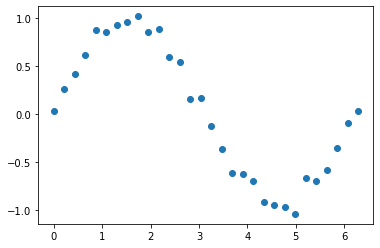

In [6]:
processed = process_energy_controlled_two_state(test[0], 5, 30, 30)
testRange = np.linspace(0, 2*np.pi, 30)
plt.scatter(testRange, processed[0])
plt.show()

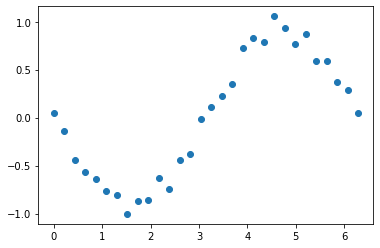

In [5]:
plt.scatter(testRange, processed[1])
plt.show()

[[Model]]
    ((Model(constant) + Model(sine, prefix='selfDifference_')) + Model(sine, prefix='interactionElement_'))
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 107
    # data points      = 30
    # variables        = 2
    chi-square         = 0.13808311
    reduced chi-square = 0.00493154
    Akaike info crit   = -157.432906
    Bayesian info crit = -154.630512
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    c:                             0 (fixed)
    selfDifference_amplitude:      0.04021915 (init = 0)
    selfDifference_frequency:      1 (fixed)
    selfDifference_shift:          1.570796 (fixed)
    interactionElement_amplitude:  0.96370793 (init = 0)
    interactionElement_frequency:  1 (fixed)
   

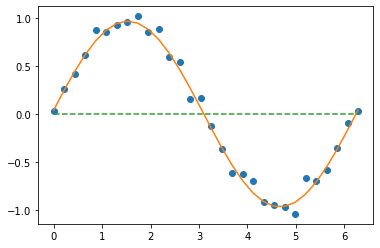

[Parameters([('c', <Parameter 'c', value=0 (fixed), bounds=[-inf:inf]>), ('selfDifference_amplitude', <Parameter 'selfDifference_amplitude', value=0.040219153302037514, bounds=[0:inf]>), ('selfDifference_frequency', <Parameter 'selfDifference_frequency', value=1 (fixed), bounds=[0:inf]>), ('selfDifference_shift', <Parameter 'selfDifference_shift', value=1.5707963267948966 (fixed), bounds=[-6.283195307179586:6.283195307179586]>), ('interactionElement_amplitude', <Parameter 'interactionElement_amplitude', value=0.9637079275373306, bounds=[0:inf]>), ('interactionElement_frequency', <Parameter 'interactionElement_frequency', value=1 (fixed), bounds=[0:inf]>), ('interactionElement_shift', <Parameter 'interactionElement_shift', value=0 (fixed), bounds=[-6.283195307179586:6.283195307179586]>)]),
 array([ 0.04021915,  0.24644757,  0.44115237,  0.61522938,  0.76053894,
         0.87028655,  0.93934053,  0.96447199,  0.94450581,  0.88037559,
         0.77507998,  0.6335425 ,  0.46238127,  0.2695

In [10]:
fit_controlled_two_state(processed, 2*np.pi, 30, printResults=True)

In [12]:
print(processed)
print(testRange)

[array([ 0.02823054,  0.26077243,  0.41443731,  0.61327959,  0.8739249 ,
        0.85125606,  0.92414828,  0.96003531,  1.01559077,  0.85094465,
        0.88611928,  0.5926875 ,  0.53871049,  0.15698119,  0.16576453,
       -0.12786223, -0.36244711, -0.6117936 , -0.62110876, -0.69925544,
       -0.90981913, -0.94162349, -0.96476969, -1.03777835, -0.66898699,
       -0.69234288, -0.58054451, -0.34872472, -0.09629657,  0.03147437]), array([ 0.04682487, -0.1446104 , -0.44500591, -0.56206373, -0.64417363,
       -0.7646307 , -0.80586536, -1.00405417, -0.86997731, -0.85700037,
       -0.62695273, -0.7492306 , -0.44419284, -0.38313218, -0.01118715,
        0.11459972,  0.22928605,  0.35368395,  0.72881521,  0.82778855,
        0.78785423,  1.05677512,  0.93773944,  0.77003103,  0.87069803,
        0.59051453,  0.58973267,  0.37288861,  0.28310018,  0.05311918])]
[0.         0.21666156 0.43332312 0.64998469 0.86664625 1.08330781
 1.29996937 1.51663094 1.7332925  1.94995406 2.16661562 2.383277